In [1]:
## Import necessary libraries
!pip install split-folders

In [2]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import splitfolders
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [34]:

# Transformation for the training dataset with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transformation for validation and testing datasets
val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),                      # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


train_dir = "/content/drive/MyDrive/food11/train"
val_dir = "/content/drive/MyDrive/food11/validation"
test_dir = "/content/drive/MyDrive/food11/test"



train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)


batch_size = 64  # Adjust batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,       # No shuffling
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)

print(f"Classes: {train_dataset.classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch labels: {labels}")
    break

Mounted at /content/drive
Classes: ['apple_pie', 'cheesecake', 'chicken_curry', 'french_fries', 'fried_rice', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sushi']
Number of training images: 2200
Number of validation images: 275
Number of test images: 275
Batch image shape: torch.Size([64, 3, 256, 256])
Batch labels: tensor([ 7,  0,  9,  1,  9,  1,  2,  1,  5,  8,  6,  4,  3,  6,  2,  9,  8, 10,
         5,  4,  8,  7,  4,  2,  0,  0,  3,  4,  6,  7,  4, 10,  3, 10,  9,  3,
         2,  5,  3,  2,  0,  3,  7,  2,  5,  7,  5,  1,  2,  2,  3,  2,  3,  2,
         2,  2,  0,  4, 10,  7,  2, 10,  9,  5])


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNR(nn.Module):

    #Constructor
    def __init__(self, num_classes=10):
        super(CNNR, self).__init__()
        # 1. Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 2. Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 3. Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.res_conv2to3 = nn.Conv2d(64, 128, kernel_size=1)
        # 4. Convolutional Layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 5. Convolutional Layer
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 16 * 16, 2048)    # first fully connected layer
        self.fc2 = nn.Linear(2048, num_classes)    # Second fully connected layer

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Residual path
        residual = self.res_conv2to3(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Residual connection
        x = x + residual

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        # 1. Conv Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2. Conv Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3. Conv Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4. Conv Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5. Conv Block
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 8 * 8, 512)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Conv Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        # Conv Block 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)


        x = torch.flatten(x, 1)

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)

        return x

In [15]:
## loss function
!pip install torchsummary
from torchsummary import summary

num_classes = 11
model = CNN(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (3, 256, 256))

# an optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=1e-4
)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
      BatchNorm2d-11          [-1, 256, 32, 32]             512
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [16]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                device,
                num_epochs=50,
                save_path=None):
    """

    Returns:
        train_losses, val_losses, train_accuracies, val_accuracies
    """
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)


        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():  # automatic mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

        # --- Validation ---
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100.0 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


    return train_losses, val_losses, train_accuracies, val_accuracies


##None resudual models with 32 batch sizes and 3 different learning rates

Model 1:

Training Hyperparameters:

>>Training Loss: 0.0268, Training Accuracy: 90.32%

>>Validation Loss: 1.6755, Validation Accuracy: 58.91%

Optimizer Type: SGD.

Learning Rate (lr): 0.001



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.



In [17]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model.pth'
)


<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 69/69 [00:07<00:00,  9.35it/s]


Training Loss: 2.2738, Training Accuracy: 18.91%


100%|██████████| 9/9 [00:00<00:00,  9.82it/s]


Validation Loss: 2.0806, Validation Accuracy: 26.18%
Epoch 2/50
------------------------------


 71%|███████   | 49/69 [00:05<00:02,  9.20it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db90c39ee80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7db90c39ee80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1564, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.11/threading.py", line 1116, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
    if w.is_alive():
 

Training Loss: 2.0359, Training Accuracy: 30.05%


100%|██████████| 9/9 [00:00<00:00,  9.65it/s]


Validation Loss: 1.9488, Validation Accuracy: 34.55%
Epoch 3/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.42it/s]


Training Loss: 1.8852, Training Accuracy: 34.14%


100%|██████████| 9/9 [00:00<00:00, 10.35it/s]


Validation Loss: 1.9588, Validation Accuracy: 33.09%
Epoch 4/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.08it/s]


Training Loss: 1.7584, Training Accuracy: 41.00%


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


Validation Loss: 1.8080, Validation Accuracy: 38.55%
Epoch 5/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.84it/s]


Training Loss: 1.6968, Training Accuracy: 42.32%


100%|██████████| 9/9 [00:00<00:00, 10.62it/s]


Validation Loss: 1.7767, Validation Accuracy: 41.82%
Epoch 6/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.35it/s]


Training Loss: 1.6463, Training Accuracy: 44.18%


100%|██████████| 9/9 [00:00<00:00, 10.78it/s]


Validation Loss: 1.7541, Validation Accuracy: 40.36%
Epoch 7/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.78it/s]


Training Loss: 1.5183, Training Accuracy: 49.36%


100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


Validation Loss: 1.7137, Validation Accuracy: 41.82%
Epoch 8/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Training Loss: 1.4577, Training Accuracy: 51.95%


100%|██████████| 9/9 [00:00<00:00, 10.68it/s]


Validation Loss: 1.6240, Validation Accuracy: 45.82%
Epoch 9/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.61it/s]


Training Loss: 1.4016, Training Accuracy: 54.00%


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Validation Loss: 1.5924, Validation Accuracy: 45.09%
Epoch 10/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.18it/s]


Training Loss: 1.3127, Training Accuracy: 56.09%


100%|██████████| 9/9 [00:00<00:00, 10.71it/s]


Validation Loss: 1.6811, Validation Accuracy: 44.73%
Epoch 11/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.53it/s]


Training Loss: 1.2306, Training Accuracy: 61.64%


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


Validation Loss: 1.6050, Validation Accuracy: 45.09%
Epoch 12/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.71it/s]


Training Loss: 1.1600, Training Accuracy: 62.64%


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


Validation Loss: 1.6157, Validation Accuracy: 44.73%
Epoch 13/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.41it/s]


Training Loss: 1.1122, Training Accuracy: 63.59%


100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


Validation Loss: 1.7064, Validation Accuracy: 43.27%
Epoch 14/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.02it/s]


Training Loss: 1.0315, Training Accuracy: 66.82%


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


Validation Loss: 1.5177, Validation Accuracy: 46.55%
Epoch 15/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.09it/s]


Training Loss: 0.9810, Training Accuracy: 68.41%


100%|██████████| 9/9 [00:00<00:00,  9.78it/s]


Validation Loss: 1.8352, Validation Accuracy: 44.73%
Epoch 16/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Training Loss: 0.8972, Training Accuracy: 71.14%


100%|██████████| 9/9 [00:00<00:00, 10.75it/s]


Validation Loss: 1.5992, Validation Accuracy: 49.09%
Epoch 17/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Training Loss: 0.7918, Training Accuracy: 74.64%


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


Validation Loss: 1.4967, Validation Accuracy: 52.36%
Epoch 18/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Training Loss: 0.7202, Training Accuracy: 77.09%


100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


Validation Loss: 1.7203, Validation Accuracy: 47.27%
Epoch 19/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.16it/s]


Training Loss: 0.7015, Training Accuracy: 76.05%


100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


Validation Loss: 1.6000, Validation Accuracy: 48.73%
Epoch 20/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Training Loss: 0.6178, Training Accuracy: 80.23%


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Validation Loss: 1.7501, Validation Accuracy: 44.36%
Epoch 21/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.43it/s]


Training Loss: 0.5490, Training Accuracy: 82.18%


100%|██████████| 9/9 [00:00<00:00,  9.75it/s]


Validation Loss: 1.5018, Validation Accuracy: 55.27%
Epoch 22/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Training Loss: 0.4754, Training Accuracy: 85.77%


100%|██████████| 9/9 [00:00<00:00, 10.53it/s]


Validation Loss: 1.6784, Validation Accuracy: 50.18%
Epoch 23/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.20it/s]


Training Loss: 0.3776, Training Accuracy: 88.68%


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


Validation Loss: 1.5358, Validation Accuracy: 54.18%
Epoch 24/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.10it/s]


Training Loss: 0.3911, Training Accuracy: 87.68%


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 1.5229, Validation Accuracy: 52.00%
Epoch 25/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.79it/s]


Training Loss: 0.3179, Training Accuracy: 90.50%


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


Validation Loss: 1.5981, Validation Accuracy: 54.18%
Epoch 26/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


Training Loss: 0.2913, Training Accuracy: 91.64%


100%|██████████| 9/9 [00:00<00:00,  9.89it/s]


Validation Loss: 1.7342, Validation Accuracy: 51.64%
Epoch 27/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.95it/s]


Training Loss: 0.2705, Training Accuracy: 92.36%


100%|██████████| 9/9 [00:00<00:00, 10.46it/s]


Validation Loss: 1.5014, Validation Accuracy: 55.64%
Epoch 28/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.49it/s]


Training Loss: 0.2415, Training Accuracy: 93.18%


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


Validation Loss: 1.5959, Validation Accuracy: 54.55%
Epoch 29/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.31it/s]


Training Loss: 0.2385, Training Accuracy: 92.55%


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


Validation Loss: 1.4098, Validation Accuracy: 55.64%
Epoch 30/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.75it/s]


Training Loss: 0.1812, Training Accuracy: 95.23%


100%|██████████| 9/9 [00:00<00:00,  9.72it/s]


Validation Loss: 1.6597, Validation Accuracy: 57.45%
Epoch 31/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Training Loss: 0.1637, Training Accuracy: 95.91%


100%|██████████| 9/9 [00:00<00:00, 10.53it/s]


Validation Loss: 1.7216, Validation Accuracy: 53.82%
Epoch 32/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Training Loss: 0.1350, Training Accuracy: 96.82%


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 1.5835, Validation Accuracy: 56.73%
Epoch 33/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.03it/s]


Training Loss: 0.1391, Training Accuracy: 96.36%


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


Validation Loss: 1.5946, Validation Accuracy: 59.64%
Epoch 34/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.87it/s]


Training Loss: 0.1305, Training Accuracy: 96.73%


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Validation Loss: 1.6059, Validation Accuracy: 55.27%
Epoch 35/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Training Loss: 0.0914, Training Accuracy: 98.27%


100%|██████████| 9/9 [00:00<00:00,  9.89it/s]


Validation Loss: 1.5597, Validation Accuracy: 56.73%
Epoch 36/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.84it/s]


Training Loss: 0.0704, Training Accuracy: 98.77%


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 1.5455, Validation Accuracy: 59.27%
Epoch 37/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.11it/s]


Training Loss: 0.0643, Training Accuracy: 99.27%


100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


Validation Loss: 1.7189, Validation Accuracy: 56.73%
Epoch 38/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.46it/s]


Training Loss: 0.0656, Training Accuracy: 98.77%


100%|██████████| 9/9 [00:00<00:00,  9.06it/s]


Validation Loss: 1.8764, Validation Accuracy: 53.82%
Epoch 39/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.18it/s]


Training Loss: 0.0869, Training Accuracy: 98.09%


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


Validation Loss: 1.6011, Validation Accuracy: 56.00%
Epoch 40/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.98it/s]


Training Loss: 0.0582, Training Accuracy: 98.68%


100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


Validation Loss: 1.7404, Validation Accuracy: 56.00%
Epoch 41/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.21it/s]


Training Loss: 0.0581, Training Accuracy: 98.82%


100%|██████████| 9/9 [00:00<00:00,  9.71it/s]


Validation Loss: 1.8960, Validation Accuracy: 55.64%
Epoch 42/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.32it/s]


Training Loss: 0.0586, Training Accuracy: 98.91%


100%|██████████| 9/9 [00:00<00:00, 10.50it/s]


Validation Loss: 1.6990, Validation Accuracy: 56.00%
Epoch 43/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.43it/s]


Training Loss: 0.0428, Training Accuracy: 99.32%


100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


Validation Loss: 1.6970, Validation Accuracy: 55.27%
Epoch 44/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Training Loss: 0.0296, Training Accuracy: 99.73%


100%|██████████| 9/9 [00:00<00:00, 10.62it/s]


Validation Loss: 1.6283, Validation Accuracy: 59.27%
Epoch 45/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Training Loss: 0.0317, Training Accuracy: 99.50%


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


Validation Loss: 1.6366, Validation Accuracy: 57.09%
Epoch 46/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.36it/s]


Training Loss: 0.0379, Training Accuracy: 99.41%


100%|██████████| 9/9 [00:00<00:00,  9.93it/s]


Validation Loss: 1.7061, Validation Accuracy: 55.64%
Epoch 47/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Training Loss: 0.0302, Training Accuracy: 99.45%


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


Validation Loss: 1.7037, Validation Accuracy: 59.64%
Epoch 48/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.37it/s]


Training Loss: 0.0282, Training Accuracy: 99.73%


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 1.6412, Validation Accuracy: 57.09%
Epoch 49/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.75it/s]


Training Loss: 0.0278, Training Accuracy: 99.59%


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


Validation Loss: 1.6943, Validation Accuracy: 58.91%
Epoch 50/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Training Loss: 0.0268, Training Accuracy: 99.68%


100%|██████████| 9/9 [00:00<00:00, 10.01it/s]

Validation Loss: 1.6755, Validation Accuracy: 60.00%


##None resudual
Model 1:

Training Hyperparameters:

>>Training Loss: 0.0450, Training Accuracy: 99.68%

>>Validation Loss: 2.3027, Validation Accuracy: 60.00%

>>Test Accuracy: 48.73%

Optimizer Type: SGD.

Learning Rate (lr): 0.001



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

Dropout : (0.3)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_plot(model,
                      train_losses,
                      val_losses,
                      train_accuracies,
                      val_accuracies,
                      test_loader,
                      test_dataset,
                      device):


    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    class_names = test_dataset.classes
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


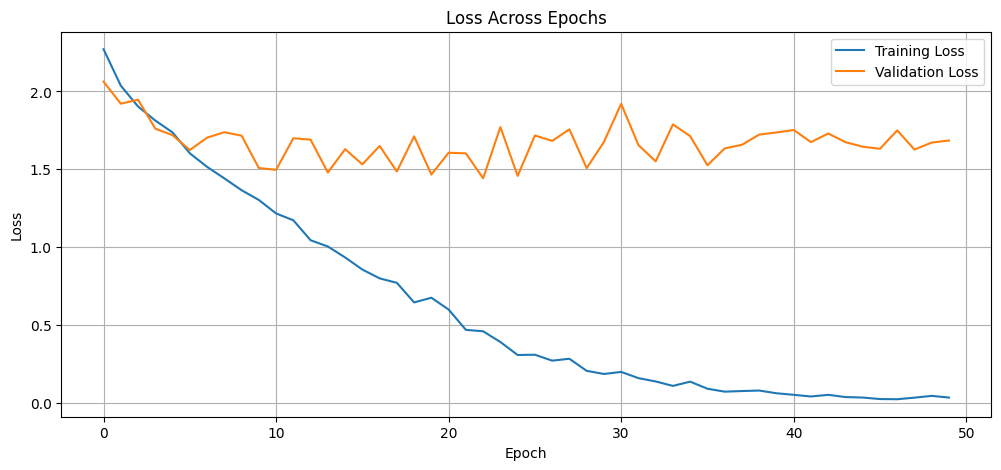

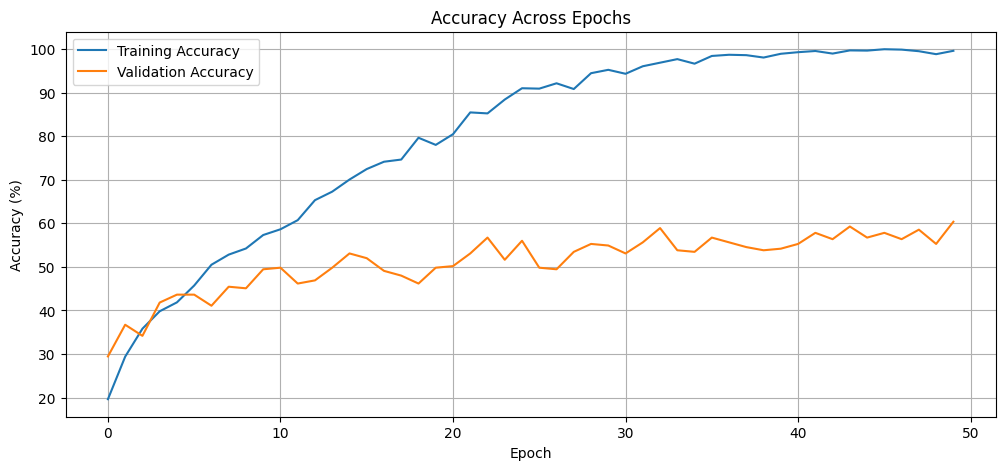

Test Accuracy: 48.73%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.62      0.32      0.42        25
   cheesecake       0.63      0.48      0.55        25
chicken_curry       0.37      0.52      0.43        25
 french_fries       0.45      0.68      0.54        25
   fried_rice       0.71      0.80      0.75        25
    hamburger       0.36      0.40      0.38        25
      hot_dog       0.36      0.20      0.26        25
    ice_cream       0.52      0.52      0.52        25
     omelette       0.53      0.32      0.40        25
        pizza       0.44      0.68      0.53        25
        sushi       0.52      0.44      0.48        25

     accuracy                           0.49       275
    macro avg       0.50      0.49      0.48       275
 weighted avg       0.50      0.49      0.48       275



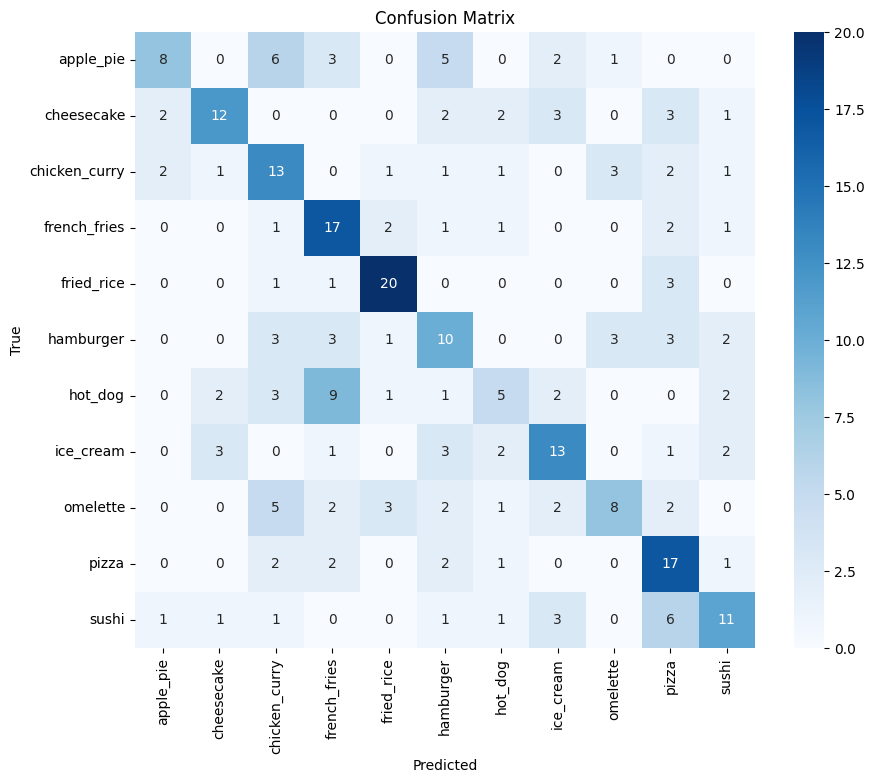

In [11]:
evaluate_and_plot(model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader, test_dataset, device)


Model 2:

Training Hyperparameters:

>>Training Loss: 0.0450, Training Accuracy: 99.36%

>>Validation Loss: 1.9283, Validation Accuracy: 55.64%

>>Test Accuracy: 49.45%


Optimizer Type: SGD.

Learning Rate (lr): 0.01



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

In [19]:


model2 = CNN(num_classes=num_classes)

criterion2 = nn.CrossEntropyLoss()

#model is on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)


optimizer2 = torch.optim.SGD(
    model2.parameters(),
    lr=0.01,

    weight_decay=1e-4
)

train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_model(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer2,
    device=device,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model2.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 69/69 [00:07<00:00,  9.79it/s]


Training Loss: 2.4853, Training Accuracy: 15.32%


100%|██████████| 9/9 [00:00<00:00, 10.41it/s]


Validation Loss: 2.1971, Validation Accuracy: 20.36%
Epoch 2/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.92it/s]


Training Loss: 2.1344, Training Accuracy: 24.00%


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


Validation Loss: 2.0957, Validation Accuracy: 26.18%
Epoch 3/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.37it/s]


Training Loss: 2.0280, Training Accuracy: 28.41%


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


Validation Loss: 2.0161, Validation Accuracy: 28.36%
Epoch 4/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Training Loss: 1.9507, Training Accuracy: 32.73%


100%|██████████| 9/9 [00:00<00:00, 10.01it/s]


Validation Loss: 1.9293, Validation Accuracy: 31.64%
Epoch 5/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.85it/s]


Training Loss: 1.8775, Training Accuracy: 34.59%


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


Validation Loss: 1.8940, Validation Accuracy: 33.09%
Epoch 6/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.48it/s]


Training Loss: 1.7823, Training Accuracy: 39.68%


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


Validation Loss: 2.0544, Validation Accuracy: 29.45%
Epoch 7/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.86it/s]


Training Loss: 1.7146, Training Accuracy: 43.09%


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


Validation Loss: 1.8145, Validation Accuracy: 41.09%
Epoch 8/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Training Loss: 1.6907, Training Accuracy: 42.86%


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


Validation Loss: 1.8884, Validation Accuracy: 38.18%
Epoch 9/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Training Loss: 1.5994, Training Accuracy: 45.32%


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


Validation Loss: 1.6995, Validation Accuracy: 44.00%
Epoch 10/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.87it/s]


Training Loss: 1.5491, Training Accuracy: 48.45%


100%|██████████| 9/9 [00:00<00:00, 10.90it/s]


Validation Loss: 1.8961, Validation Accuracy: 41.82%
Epoch 11/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Training Loss: 1.5142, Training Accuracy: 50.95%


100%|██████████| 9/9 [00:00<00:00, 10.78it/s]


Validation Loss: 1.6607, Validation Accuracy: 41.09%
Epoch 12/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Training Loss: 1.4366, Training Accuracy: 51.23%


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


Validation Loss: 1.7129, Validation Accuracy: 42.91%
Epoch 13/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.75it/s]


Training Loss: 1.3601, Training Accuracy: 55.23%


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


Validation Loss: 1.7365, Validation Accuracy: 43.64%
Epoch 14/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Training Loss: 1.3348, Training Accuracy: 55.27%


100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


Validation Loss: 1.9672, Validation Accuracy: 37.82%
Epoch 15/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.77it/s]


Training Loss: 1.2567, Training Accuracy: 58.23%


100%|██████████| 9/9 [00:00<00:00,  9.63it/s]


Validation Loss: 1.6467, Validation Accuracy: 45.45%
Epoch 16/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.76it/s]


Training Loss: 1.1743, Training Accuracy: 61.05%


100%|██████████| 9/9 [00:00<00:00, 10.81it/s]


Validation Loss: 2.0958, Validation Accuracy: 38.18%
Epoch 17/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.65it/s]


Training Loss: 1.1662, Training Accuracy: 60.00%


100%|██████████| 9/9 [00:00<00:00, 10.70it/s]


Validation Loss: 1.7533, Validation Accuracy: 42.55%
Epoch 18/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.82it/s]


Training Loss: 1.1253, Training Accuracy: 62.05%


100%|██████████| 9/9 [00:00<00:00,  9.86it/s]


Validation Loss: 1.8599, Validation Accuracy: 42.91%
Epoch 19/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.35it/s]


Training Loss: 1.0380, Training Accuracy: 65.91%


100%|██████████| 9/9 [00:01<00:00,  7.84it/s]


Validation Loss: 2.1955, Validation Accuracy: 40.00%
Epoch 20/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.71it/s]


Training Loss: 0.9870, Training Accuracy: 67.50%


100%|██████████| 9/9 [00:00<00:00, 10.63it/s]


Validation Loss: 1.7411, Validation Accuracy: 46.91%
Epoch 21/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.87it/s]


Training Loss: 0.9067, Training Accuracy: 69.73%


100%|██████████| 9/9 [00:00<00:00,  9.80it/s]


Validation Loss: 1.6900, Validation Accuracy: 49.09%
Epoch 22/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.51it/s]


Training Loss: 0.8161, Training Accuracy: 72.36%


100%|██████████| 9/9 [00:00<00:00, 10.54it/s]


Validation Loss: 1.9162, Validation Accuracy: 44.00%
Epoch 23/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Training Loss: 0.7923, Training Accuracy: 73.64%


100%|██████████| 9/9 [00:00<00:00, 10.05it/s]


Validation Loss: 1.7867, Validation Accuracy: 50.91%
Epoch 24/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.82it/s]


Training Loss: 0.7593, Training Accuracy: 74.68%


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


Validation Loss: 1.6451, Validation Accuracy: 51.64%
Epoch 25/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Training Loss: 0.7393, Training Accuracy: 75.18%


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


Validation Loss: 1.7423, Validation Accuracy: 46.55%
Epoch 26/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Training Loss: 0.6070, Training Accuracy: 80.27%


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


Validation Loss: 1.7472, Validation Accuracy: 49.09%
Epoch 27/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.00it/s]


Training Loss: 0.6121, Training Accuracy: 79.45%


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


Validation Loss: 2.9112, Validation Accuracy: 35.64%
Epoch 28/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Training Loss: 0.5288, Training Accuracy: 82.95%


100%|██████████| 9/9 [00:00<00:00, 10.76it/s]


Validation Loss: 1.7676, Validation Accuracy: 53.82%
Epoch 29/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Training Loss: 0.4783, Training Accuracy: 84.41%


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


Validation Loss: 1.9781, Validation Accuracy: 47.27%
Epoch 30/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Training Loss: 0.4192, Training Accuracy: 86.73%


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


Validation Loss: 2.0424, Validation Accuracy: 46.91%
Epoch 31/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


Training Loss: 0.4230, Training Accuracy: 86.41%


100%|██████████| 9/9 [00:00<00:00, 10.83it/s]


Validation Loss: 1.9527, Validation Accuracy: 49.45%
Epoch 32/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.81it/s]


Training Loss: 0.3601, Training Accuracy: 88.41%


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 1.5579, Validation Accuracy: 57.45%
Epoch 33/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.04it/s]


Training Loss: 0.2993, Training Accuracy: 90.64%


100%|██████████| 9/9 [00:00<00:00, 10.14it/s]


Validation Loss: 2.0881, Validation Accuracy: 44.73%
Epoch 34/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.62it/s]


Training Loss: 0.2690, Training Accuracy: 92.50%


100%|██████████| 9/9 [00:00<00:00, 11.02it/s]


Validation Loss: 1.9081, Validation Accuracy: 46.91%
Epoch 35/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.81it/s]


Training Loss: 0.2292, Training Accuracy: 93.95%


100%|██████████| 9/9 [00:00<00:00, 10.05it/s]


Validation Loss: 1.7586, Validation Accuracy: 56.00%
Epoch 36/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.96it/s]


Training Loss: 0.1726, Training Accuracy: 95.82%


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


Validation Loss: 1.8314, Validation Accuracy: 52.73%
Epoch 37/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Training Loss: 0.1588, Training Accuracy: 96.23%


100%|██████████| 9/9 [00:00<00:00, 10.44it/s]


Validation Loss: 1.8741, Validation Accuracy: 53.82%
Epoch 38/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.86it/s]


Training Loss: 0.1700, Training Accuracy: 95.68%


100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


Validation Loss: 2.0141, Validation Accuracy: 52.00%
Epoch 39/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.87it/s]


Training Loss: 0.1555, Training Accuracy: 96.09%


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


Validation Loss: 1.7032, Validation Accuracy: 56.73%
Epoch 40/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Training Loss: 0.1219, Training Accuracy: 97.27%


100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


Validation Loss: 1.7075, Validation Accuracy: 54.55%
Epoch 41/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.02it/s]


Training Loss: 0.1602, Training Accuracy: 95.82%


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Validation Loss: 1.8786, Validation Accuracy: 52.36%
Epoch 42/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Training Loss: 0.0950, Training Accuracy: 98.41%


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


Validation Loss: 1.6691, Validation Accuracy: 57.09%
Epoch 43/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.46it/s]


Training Loss: 0.0876, Training Accuracy: 98.36%


100%|██████████| 9/9 [00:00<00:00, 10.45it/s]


Validation Loss: 1.6729, Validation Accuracy: 58.18%
Epoch 44/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.97it/s]


Training Loss: 0.0879, Training Accuracy: 98.14%


100%|██████████| 9/9 [00:00<00:00, 10.58it/s]


Validation Loss: 2.0238, Validation Accuracy: 56.73%
Epoch 45/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.70it/s]


Training Loss: 0.0554, Training Accuracy: 99.32%


100%|██████████| 9/9 [00:00<00:00, 10.43it/s]


Validation Loss: 1.5983, Validation Accuracy: 58.91%
Epoch 46/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.83it/s]


Training Loss: 0.0474, Training Accuracy: 99.27%


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


Validation Loss: 1.7901, Validation Accuracy: 56.00%
Epoch 47/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.72it/s]


Training Loss: 0.0661, Training Accuracy: 98.77%


100%|██████████| 9/9 [00:00<00:00, 10.86it/s]


Validation Loss: 1.8318, Validation Accuracy: 59.27%
Epoch 48/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.57it/s]


Training Loss: 0.0855, Training Accuracy: 98.14%


100%|██████████| 9/9 [00:00<00:00,  9.60it/s]


Validation Loss: 1.7632, Validation Accuracy: 58.18%
Epoch 49/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.75it/s]


Training Loss: 0.0869, Training Accuracy: 98.23%


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 1.6805, Validation Accuracy: 57.82%
Epoch 50/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.75it/s]


Training Loss: 0.0450, Training Accuracy: 99.36%


100%|██████████| 9/9 [00:00<00:00, 10.51it/s]

Validation Loss: 1.9283, Validation Accuracy: 55.64%


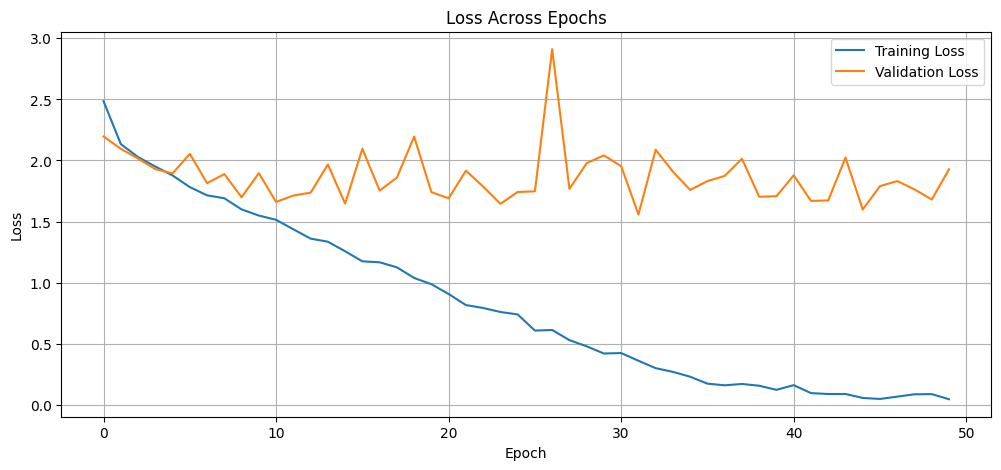

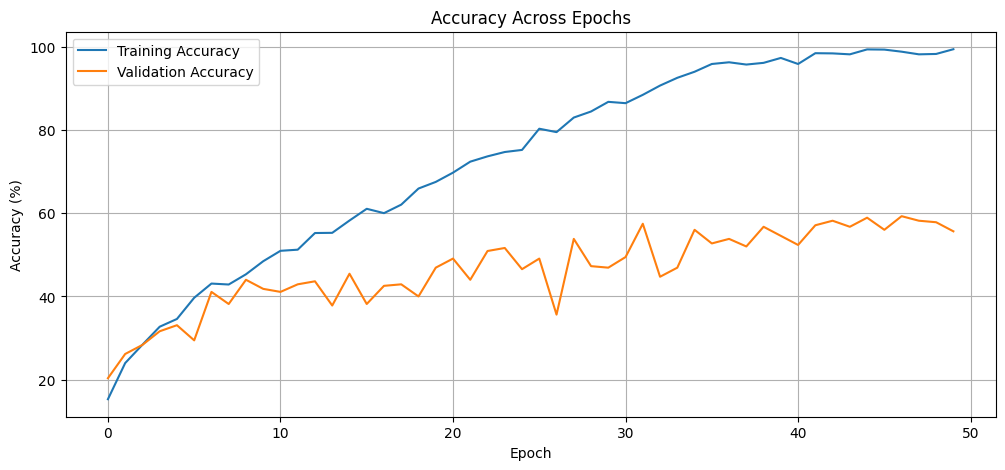

Test Accuracy: 49.45%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.62      0.20      0.30        25
   cheesecake       0.78      0.56      0.65        25
chicken_curry       0.40      0.76      0.53        25
 french_fries       0.37      0.76      0.50        25
   fried_rice       0.83      0.76      0.79        25
    hamburger       0.56      0.20      0.29        25
      hot_dog       0.23      0.28      0.25        25
    ice_cream       0.50      0.56      0.53        25
     omelette       0.53      0.32      0.40        25
        pizza       0.58      0.60      0.59        25
        sushi       0.55      0.44      0.49        25

     accuracy                           0.49       275
    macro avg       0.54      0.49      0.48       275
 weighted avg       0.54      0.49      0.48       275



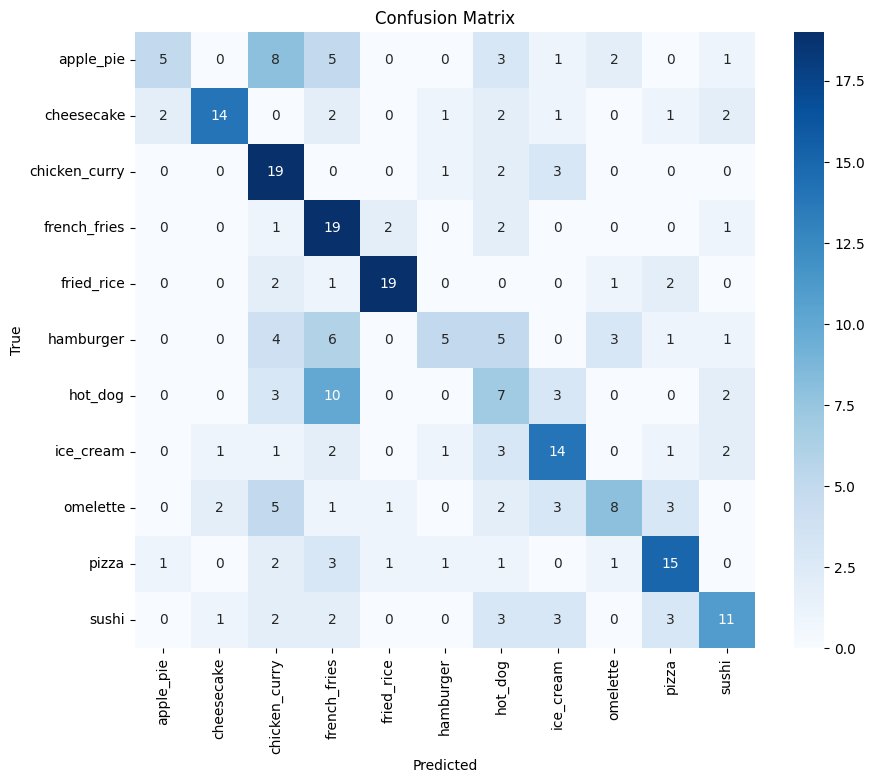

In [20]:
evaluate_and_plot(model2, train_losses2, val_losses2, train_accuracies2, val_accuracies2, test_loader, test_dataset, device)


Model 3:


>>Training Loss: 0.0986, Training Accuracy: 98.64%

>>Validation Loss: 1.5711, Validation Accuracy:57.09%

>>Test Accuracy: 47.64%


Optimizer Type: SGD.

Learning Rate (lr): 0.005



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

In [25]:


model3 = CNN(num_classes=num_classes)

criterion3 = nn.CrossEntropyLoss()

#model is on the CPU
device3 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device3)



optimizer3 = torch.optim.SGD(
    model3.parameters(),
    lr=0.005,

    weight_decay=1e-4
)

train_losses3, val_losses3, train_accuracies3, val_accuracies3 = train_model(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion3,
    optimizer=optimizer3,
    device=device3,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model3.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 69/69 [00:07<00:00,  9.46it/s]


Training Loss: 2.3210, Training Accuracy: 16.14%


100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


Validation Loss: 2.1882, Validation Accuracy: 22.91%
Epoch 2/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.18it/s]


Training Loss: 2.1182, Training Accuracy: 26.55%


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


Validation Loss: 2.0722, Validation Accuracy: 25.45%
Epoch 3/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.71it/s]


Training Loss: 1.9833, Training Accuracy: 31.68%


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


Validation Loss: 1.9503, Validation Accuracy: 31.27%
Epoch 4/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.99it/s]


Training Loss: 1.8951, Training Accuracy: 34.55%


100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


Validation Loss: 1.9864, Validation Accuracy: 30.91%
Epoch 5/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.36it/s]


Training Loss: 1.8264, Training Accuracy: 38.18%


100%|██████████| 9/9 [00:00<00:00,  9.37it/s]


Validation Loss: 1.8153, Validation Accuracy: 36.36%
Epoch 6/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.01it/s]


Training Loss: 1.7440, Training Accuracy: 41.14%


100%|██████████| 9/9 [00:00<00:00, 10.74it/s]


Validation Loss: 1.7961, Validation Accuracy: 40.00%
Epoch 7/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.24it/s]


Training Loss: 1.6625, Training Accuracy: 43.41%


100%|██████████| 9/9 [00:00<00:00, 10.54it/s]


Validation Loss: 1.9495, Validation Accuracy: 33.45%
Epoch 8/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.41it/s]


Training Loss: 1.5985, Training Accuracy: 46.95%


100%|██████████| 9/9 [00:00<00:00,  9.93it/s]


Validation Loss: 1.7734, Validation Accuracy: 37.82%
Epoch 9/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.52it/s]


Training Loss: 1.5340, Training Accuracy: 49.77%


100%|██████████| 9/9 [00:00<00:00, 10.05it/s]


Validation Loss: 2.0987, Validation Accuracy: 32.36%
Epoch 10/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.25it/s]


Training Loss: 1.4915, Training Accuracy: 50.86%


100%|██████████| 9/9 [00:00<00:00,  9.61it/s]


Validation Loss: 1.6676, Validation Accuracy: 43.64%
Epoch 11/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.44it/s]


Training Loss: 1.4136, Training Accuracy: 53.91%


100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


Validation Loss: 1.6905, Validation Accuracy: 43.27%
Epoch 12/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.43it/s]


Training Loss: 1.3633, Training Accuracy: 54.32%


100%|██████████| 9/9 [00:00<00:00, 10.06it/s]


Validation Loss: 1.5501, Validation Accuracy: 48.73%
Epoch 13/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.77it/s]


Training Loss: 1.3222, Training Accuracy: 55.27%


100%|██████████| 9/9 [00:00<00:00, 10.26it/s]


Validation Loss: 1.5736, Validation Accuracy: 45.45%
Epoch 14/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.05it/s]


Training Loss: 1.2656, Training Accuracy: 57.73%


100%|██████████| 9/9 [00:01<00:00,  8.97it/s]


Validation Loss: 1.7013, Validation Accuracy: 43.27%
Epoch 15/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.13it/s]


Training Loss: 1.2040, Training Accuracy: 60.05%


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


Validation Loss: 1.8021, Validation Accuracy: 37.45%
Epoch 16/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.94it/s]


Training Loss: 1.1630, Training Accuracy: 60.73%


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


Validation Loss: 1.4893, Validation Accuracy: 50.18%
Epoch 17/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.19it/s]


Training Loss: 1.0900, Training Accuracy: 63.95%


100%|██████████| 9/9 [00:00<00:00,  9.67it/s]


Validation Loss: 1.4872, Validation Accuracy: 50.91%
Epoch 18/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.16it/s]


Training Loss: 1.0420, Training Accuracy: 65.05%


100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


Validation Loss: 1.4449, Validation Accuracy: 52.36%
Epoch 19/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.11it/s]


Training Loss: 1.0052, Training Accuracy: 66.95%


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


Validation Loss: 1.6734, Validation Accuracy: 45.45%
Epoch 20/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.68it/s]


Training Loss: 0.9799, Training Accuracy: 67.95%


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


Validation Loss: 1.6348, Validation Accuracy: 46.55%
Epoch 21/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.94it/s]


Training Loss: 0.9232, Training Accuracy: 70.50%


100%|██████████| 9/9 [00:00<00:00,  9.51it/s]


Validation Loss: 1.6640, Validation Accuracy: 46.91%
Epoch 22/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.97it/s]


Training Loss: 0.8477, Training Accuracy: 73.41%


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


Validation Loss: 1.5873, Validation Accuracy: 48.36%
Epoch 23/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.94it/s]


Training Loss: 0.8133, Training Accuracy: 73.82%


100%|██████████| 9/9 [00:00<00:00,  9.50it/s]


Validation Loss: 1.5904, Validation Accuracy: 49.82%
Epoch 24/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  8.97it/s]


Training Loss: 0.7736, Training Accuracy: 74.82%


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


Validation Loss: 1.5553, Validation Accuracy: 49.45%
Epoch 25/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.33it/s]


Training Loss: 0.6892, Training Accuracy: 77.73%


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


Validation Loss: 1.7938, Validation Accuracy: 44.73%
Epoch 26/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.22it/s]


Training Loss: 0.6576, Training Accuracy: 79.55%


100%|██████████| 9/9 [00:00<00:00, 10.51it/s]


Validation Loss: 1.8271, Validation Accuracy: 46.91%
Epoch 27/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.69it/s]


Training Loss: 0.6313, Training Accuracy: 79.59%


100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


Validation Loss: 1.6782, Validation Accuracy: 50.18%
Epoch 28/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.64it/s]


Training Loss: 0.5760, Training Accuracy: 82.14%


100%|██████████| 9/9 [00:00<00:00, 10.51it/s]


Validation Loss: 1.5116, Validation Accuracy: 52.36%
Epoch 29/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.02it/s]


Training Loss: 0.5358, Training Accuracy: 84.09%


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


Validation Loss: 1.9364, Validation Accuracy: 44.36%
Epoch 30/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


Training Loss: 0.4790, Training Accuracy: 85.91%


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


Validation Loss: 1.8624, Validation Accuracy: 44.73%
Epoch 31/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.25it/s]


Training Loss: 0.4782, Training Accuracy: 85.86%


100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


Validation Loss: 1.5398, Validation Accuracy: 54.55%
Epoch 32/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.50it/s]


Training Loss: 0.4039, Training Accuracy: 88.45%


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


Validation Loss: 2.3795, Validation Accuracy: 37.82%
Epoch 33/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.46it/s]


Training Loss: 0.3701, Training Accuracy: 89.68%


100%|██████████| 9/9 [00:00<00:00,  9.54it/s]


Validation Loss: 1.6519, Validation Accuracy: 54.18%
Epoch 34/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.19it/s]


Training Loss: 0.3620, Training Accuracy: 89.73%


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


Validation Loss: 2.2605, Validation Accuracy: 41.82%
Epoch 35/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.08it/s]


Training Loss: 0.3423, Training Accuracy: 90.73%


100%|██████████| 9/9 [00:00<00:00, 10.53it/s]


Validation Loss: 1.5243, Validation Accuracy: 54.55%
Epoch 36/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.58it/s]


Training Loss: 0.3247, Training Accuracy: 91.18%


100%|██████████| 9/9 [00:00<00:00,  9.73it/s]


Validation Loss: 1.6261, Validation Accuracy: 51.64%
Epoch 37/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.20it/s]


Training Loss: 0.2265, Training Accuracy: 95.32%


100%|██████████| 9/9 [00:00<00:00, 10.93it/s]


Validation Loss: 1.4806, Validation Accuracy: 56.00%
Epoch 38/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.88it/s]


Training Loss: 0.2512, Training Accuracy: 93.64%


100%|██████████| 9/9 [00:00<00:00, 10.97it/s]


Validation Loss: 1.6381, Validation Accuracy: 54.18%
Epoch 39/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.21it/s]


Training Loss: 0.2136, Training Accuracy: 95.00%


100%|██████████| 9/9 [00:00<00:00, 10.63it/s]


Validation Loss: 1.6232, Validation Accuracy: 56.00%
Epoch 40/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.07it/s]


Training Loss: 0.2333, Training Accuracy: 94.36%


100%|██████████| 9/9 [00:00<00:00, 11.17it/s]


Validation Loss: 1.4941, Validation Accuracy: 56.36%
Epoch 41/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.08it/s]


Training Loss: 0.1746, Training Accuracy: 96.59%


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


Validation Loss: 1.7888, Validation Accuracy: 49.45%
Epoch 42/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.11it/s]


Training Loss: 0.1492, Training Accuracy: 97.45%


100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


Validation Loss: 1.6592, Validation Accuracy: 51.27%
Epoch 43/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.90it/s]


Training Loss: 0.1544, Training Accuracy: 96.50%


100%|██████████| 9/9 [00:00<00:00, 10.65it/s]


Validation Loss: 1.6249, Validation Accuracy: 54.55%
Epoch 44/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.13it/s]


Training Loss: 0.1311, Training Accuracy: 97.77%


100%|██████████| 9/9 [00:00<00:00, 10.79it/s]


Validation Loss: 1.4845, Validation Accuracy: 57.45%
Epoch 45/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.10it/s]


Training Loss: 0.1305, Training Accuracy: 97.45%


100%|██████████| 9/9 [00:00<00:00, 10.88it/s]


Validation Loss: 1.5235, Validation Accuracy: 53.45%
Epoch 46/50
------------------------------


100%|██████████| 69/69 [00:06<00:00,  9.91it/s]


Training Loss: 0.1059, Training Accuracy: 98.45%


100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


Validation Loss: 1.4629, Validation Accuracy: 58.18%
Epoch 47/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.35it/s]


Training Loss: 0.0945, Training Accuracy: 98.77%


100%|██████████| 9/9 [00:00<00:00, 11.07it/s]


Validation Loss: 1.4270, Validation Accuracy: 58.18%
Epoch 48/50
------------------------------


100%|██████████| 69/69 [00:07<00:00,  9.81it/s]


Training Loss: 0.1031, Training Accuracy: 98.59%


100%|██████████| 9/9 [00:00<00:00, 10.78it/s]


Validation Loss: 1.5143, Validation Accuracy: 56.36%
Epoch 49/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.13it/s]


Training Loss: 0.1070, Training Accuracy: 97.95%


100%|██████████| 9/9 [00:00<00:00, 11.11it/s]


Validation Loss: 1.4900, Validation Accuracy: 56.36%
Epoch 50/50
------------------------------


100%|██████████| 69/69 [00:06<00:00, 10.11it/s]


Training Loss: 0.0986, Training Accuracy: 98.64%


100%|██████████| 9/9 [00:00<00:00, 11.73it/s]

Validation Loss: 1.5711, Validation Accuracy: 57.09%


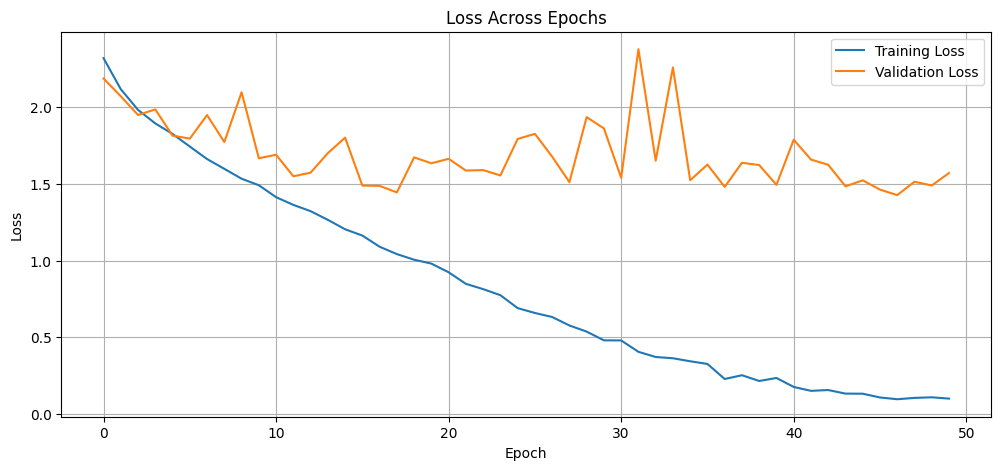

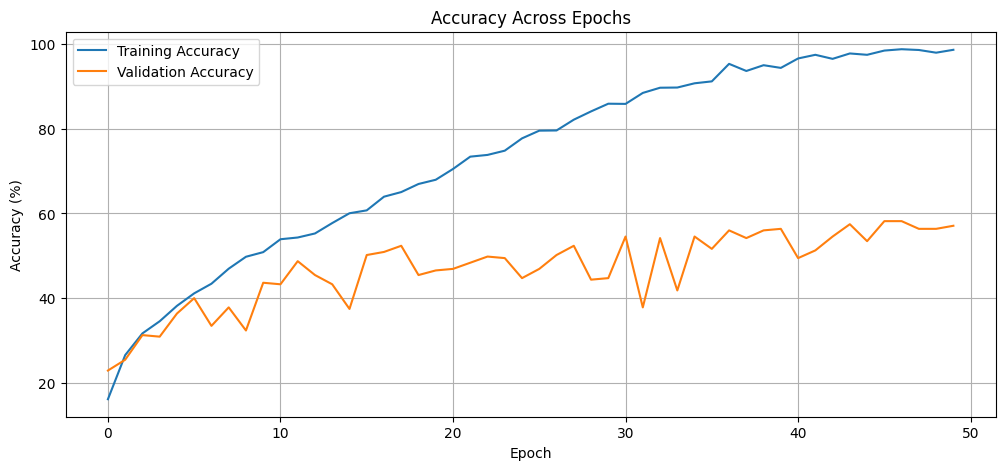

Test Accuracy: 47.64%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.40      0.40      0.40        25
   cheesecake       0.67      0.48      0.56        25
chicken_curry       0.45      0.60      0.52        25
 french_fries       0.40      0.72      0.51        25
   fried_rice       0.63      0.68      0.65        25
    hamburger       0.27      0.28      0.27        25
      hot_dog       0.44      0.28      0.34        25
    ice_cream       0.60      0.48      0.53        25
     omelette       0.36      0.20      0.26        25
        pizza       0.52      0.64      0.57        25
        sushi       0.60      0.48      0.53        25

     accuracy                           0.48       275
    macro avg       0.48      0.48      0.47       275
 weighted avg       0.48      0.48      0.47       275



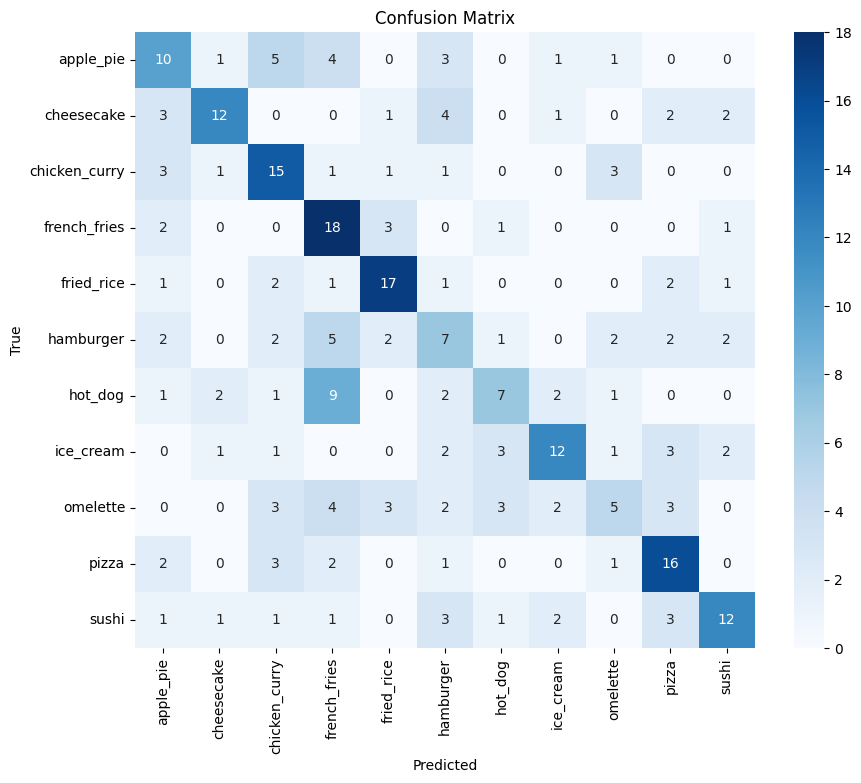

In [27]:
evaluate_and_plot(model3, train_losses3, val_losses3, train_accuracies3, val_accuracies3, test_loader, test_dataset, device3)



##CNN models with resudual  with 32 batch sizes and 3 different learning rates

Model 4:

Training Hyperparameters:

>>Training Loss: 0.3091, Training Accuracy:95.27%

>>Validation Loss: 1.5762,  Validation Accuracy: 49.82%

>>Test Accuracy: 45.*9%

Optimizer Type: SGD.

Learning Rate (lr): 0.001



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.





In [28]:


model4 = CNNR(num_classes=num_classes)

criterion4 = nn.CrossEntropyLoss()

#model is on the CPU
device4 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4.to(device4)



optimizer4 = torch.optim.SGD(
    model4.parameters(),
    lr=0.001,

    weight_decay=1e-4
)

train_losses4, val_losses4, train_accuracies4, val_accuracies4 = train_model(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion4,
    optimizer=optimizer4,
    device=device4,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model4.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 69/69 [00:08<00:00,  8.12it/s]


Training Loss: 2.3483, Training Accuracy: 15.27%


100%|██████████| 9/9 [00:00<00:00,  9.59it/s]


Validation Loss: 2.1743, Validation Accuracy: 24.00%
Epoch 2/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.14it/s]


Training Loss: 2.1404, Training Accuracy: 25.45%


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


Validation Loss: 2.0612, Validation Accuracy: 26.55%
Epoch 3/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 2.0197, Training Accuracy: 30.00%


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


Validation Loss: 1.9854, Validation Accuracy: 36.00%
Epoch 4/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 1.9155, Training Accuracy: 34.05%


100%|██████████| 9/9 [00:00<00:00, 10.07it/s]


Validation Loss: 1.8944, Validation Accuracy: 34.55%
Epoch 5/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 1.8795, Training Accuracy: 36.50%


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


Validation Loss: 1.8832, Validation Accuracy: 36.00%
Epoch 6/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.17it/s]


Training Loss: 1.8168, Training Accuracy: 38.05%


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 1.9139, Validation Accuracy: 31.64%
Epoch 7/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 1.7371, Training Accuracy: 41.36%


100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


Validation Loss: 1.8591, Validation Accuracy: 31.64%
Epoch 8/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 1.7132, Training Accuracy: 40.91%


100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


Validation Loss: 1.8071, Validation Accuracy: 38.91%
Epoch 9/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 1.6347, Training Accuracy: 44.27%


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


Validation Loss: 1.8169, Validation Accuracy: 37.09%
Epoch 10/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 1.6076, Training Accuracy: 45.73%


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


Validation Loss: 1.7532, Validation Accuracy: 37.45%
Epoch 11/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.17it/s]


Training Loss: 1.5373, Training Accuracy: 49.73%


100%|██████████| 9/9 [00:00<00:00,  9.94it/s]


Validation Loss: 1.7452, Validation Accuracy: 44.00%
Epoch 12/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.4832, Training Accuracy: 52.27%


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 1.7672, Validation Accuracy: 40.73%
Epoch 13/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 1.4350, Training Accuracy: 54.32%


100%|██████████| 9/9 [00:00<00:00, 10.41it/s]


Validation Loss: 1.7728, Validation Accuracy: 40.00%
Epoch 14/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.4110, Training Accuracy: 53.77%


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


Validation Loss: 1.8247, Validation Accuracy: 38.55%
Epoch 15/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


Training Loss: 1.3541, Training Accuracy: 55.00%


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


Validation Loss: 1.8094, Validation Accuracy: 37.45%
Epoch 16/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.3102, Training Accuracy: 58.82%


100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


Validation Loss: 1.7638, Validation Accuracy: 40.73%
Epoch 17/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Training Loss: 1.2865, Training Accuracy: 58.77%


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


Validation Loss: 1.7410, Validation Accuracy: 43.64%
Epoch 18/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.17it/s]


Training Loss: 1.2211, Training Accuracy: 61.82%


100%|██████████| 9/9 [00:00<00:00, 10.91it/s]


Validation Loss: 1.7532, Validation Accuracy: 35.64%
Epoch 19/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.1994, Training Accuracy: 61.91%


100%|██████████| 9/9 [00:00<00:00, 10.41it/s]


Validation Loss: 1.7625, Validation Accuracy: 38.91%
Epoch 20/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.1597, Training Accuracy: 62.95%


100%|██████████| 9/9 [00:00<00:00,  9.59it/s]


Validation Loss: 1.7787, Validation Accuracy: 43.27%
Epoch 21/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.17it/s]


Training Loss: 1.0856, Training Accuracy: 66.73%


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


Validation Loss: 1.7979, Validation Accuracy: 42.91%
Epoch 22/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Training Loss: 1.1098, Training Accuracy: 63.95%


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


Validation Loss: 1.7672, Validation Accuracy: 39.64%
Epoch 23/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 1.0415, Training Accuracy: 68.64%


100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


Validation Loss: 1.7802, Validation Accuracy: 39.27%
Epoch 24/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 1.0061, Training Accuracy: 70.32%


100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


Validation Loss: 1.7207, Validation Accuracy: 40.00%
Epoch 25/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.9572, Training Accuracy: 71.23%


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 1.6917, Validation Accuracy: 41.45%
Epoch 26/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.9207, Training Accuracy: 72.77%


100%|██████████| 9/9 [00:00<00:00, 10.47it/s]


Validation Loss: 1.7848, Validation Accuracy: 41.45%
Epoch 27/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.8766, Training Accuracy: 74.55%


100%|██████████| 9/9 [00:00<00:00, 10.31it/s]


Validation Loss: 1.6523, Validation Accuracy: 44.73%
Epoch 28/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.8620, Training Accuracy: 74.00%


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


Validation Loss: 1.6554, Validation Accuracy: 44.00%
Epoch 29/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.8247, Training Accuracy: 76.05%


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 1.6068, Validation Accuracy: 46.91%
Epoch 30/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.8314, Training Accuracy: 75.77%


100%|██████████| 9/9 [00:00<00:00, 10.24it/s]


Validation Loss: 1.5841, Validation Accuracy: 47.64%
Epoch 31/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.7514, Training Accuracy: 78.73%


100%|██████████| 9/9 [00:00<00:00,  9.71it/s]


Validation Loss: 1.6454, Validation Accuracy: 46.18%
Epoch 32/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.7161, Training Accuracy: 79.50%


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]


Validation Loss: 1.8752, Validation Accuracy: 41.09%
Epoch 33/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.7267, Training Accuracy: 79.41%


100%|██████████| 9/9 [00:00<00:00, 10.22it/s]


Validation Loss: 1.7040, Validation Accuracy: 44.36%
Epoch 34/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 0.6799, Training Accuracy: 81.95%


100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


Validation Loss: 1.6581, Validation Accuracy: 46.18%
Epoch 35/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.6406, Training Accuracy: 82.91%


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


Validation Loss: 1.6085, Validation Accuracy: 47.27%
Epoch 36/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.6047, Training Accuracy: 84.59%


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


Validation Loss: 1.7010, Validation Accuracy: 45.09%
Epoch 37/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.5926, Training Accuracy: 84.95%


100%|██████████| 9/9 [00:00<00:00,  9.89it/s]


Validation Loss: 1.5731, Validation Accuracy: 46.91%
Epoch 38/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.5635, Training Accuracy: 86.59%


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


Validation Loss: 1.6287, Validation Accuracy: 48.00%
Epoch 39/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 0.5624, Training Accuracy: 85.23%


100%|██████████| 9/9 [00:00<00:00, 10.84it/s]


Validation Loss: 1.6739, Validation Accuracy: 45.09%
Epoch 40/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.5117, Training Accuracy: 87.86%


100%|██████████| 9/9 [00:00<00:00, 10.74it/s]


Validation Loss: 1.6253, Validation Accuracy: 47.64%
Epoch 41/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 0.4940, Training Accuracy: 88.45%


100%|██████████| 9/9 [00:00<00:00, 10.04it/s]


Validation Loss: 1.6273, Validation Accuracy: 50.18%
Epoch 42/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.4613, Training Accuracy: 88.91%


100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


Validation Loss: 1.6120, Validation Accuracy: 48.73%
Epoch 43/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.17it/s]


Training Loss: 0.4527, Training Accuracy: 89.68%


100%|██████████| 9/9 [00:00<00:00,  9.90it/s]


Validation Loss: 1.7585, Validation Accuracy: 46.18%
Epoch 44/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.4209, Training Accuracy: 91.55%


100%|██████████| 9/9 [00:00<00:00, 10.19it/s]


Validation Loss: 1.7060, Validation Accuracy: 45.09%
Epoch 45/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.4119, Training Accuracy: 91.45%


100%|██████████| 9/9 [00:00<00:00,  9.09it/s]


Validation Loss: 1.6212, Validation Accuracy: 49.45%
Epoch 46/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Training Loss: 0.3763, Training Accuracy: 92.45%


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


Validation Loss: 1.7418, Validation Accuracy: 48.00%
Epoch 47/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Training Loss: 0.3744, Training Accuracy: 92.23%


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


Validation Loss: 1.6162, Validation Accuracy: 48.00%
Epoch 48/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.3664, Training Accuracy: 92.55%


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


Validation Loss: 1.5897, Validation Accuracy: 50.55%
Epoch 49/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.3339, Training Accuracy: 94.00%


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Validation Loss: 1.6755, Validation Accuracy: 48.73%
Epoch 50/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Training Loss: 0.3091, Training Accuracy: 95.27%


100%|██████████| 9/9 [00:00<00:00,  9.77it/s]

Validation Loss: 1.5762, Validation Accuracy: 49.82%


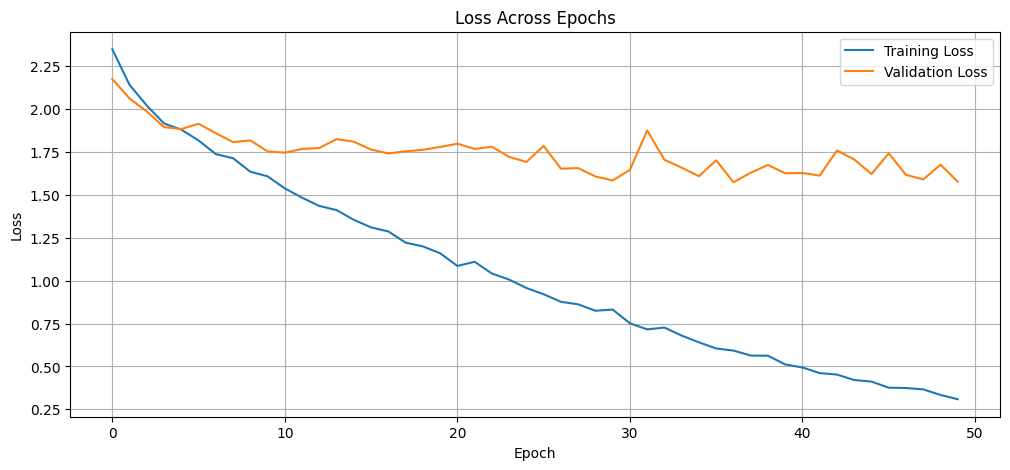

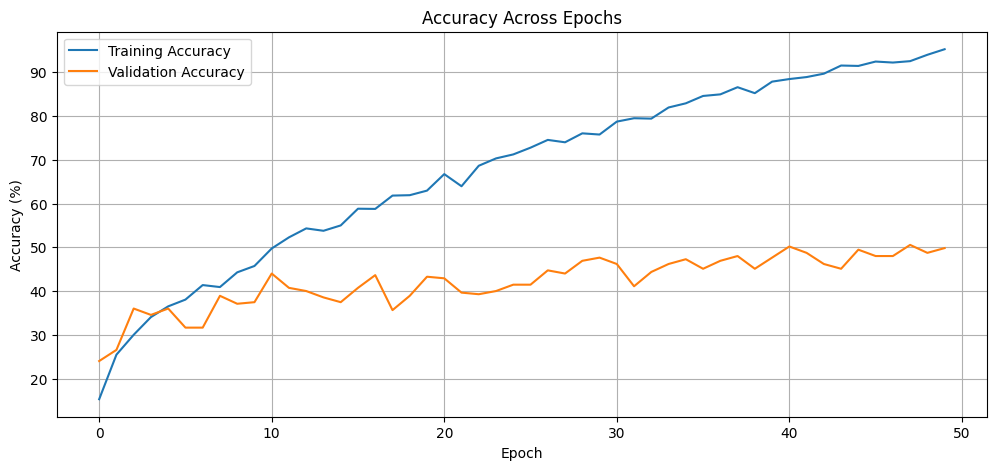

Test Accuracy: 45.09%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.45      0.40      0.43        25
   cheesecake       0.67      0.56      0.61        25
chicken_curry       0.45      0.40      0.43        25
 french_fries       0.50      0.48      0.49        25
   fried_rice       0.73      0.64      0.68        25
    hamburger       0.36      0.36      0.36        25
      hot_dog       0.21      0.24      0.22        25
    ice_cream       0.52      0.56      0.54        25
     omelette       0.44      0.28      0.34        25
        pizza       0.41      0.72      0.52        25
        sushi       0.35      0.32      0.33        25

     accuracy                           0.45       275
    macro avg       0.46      0.45      0.45       275
 weighted avg       0.46      0.45      0.45       275



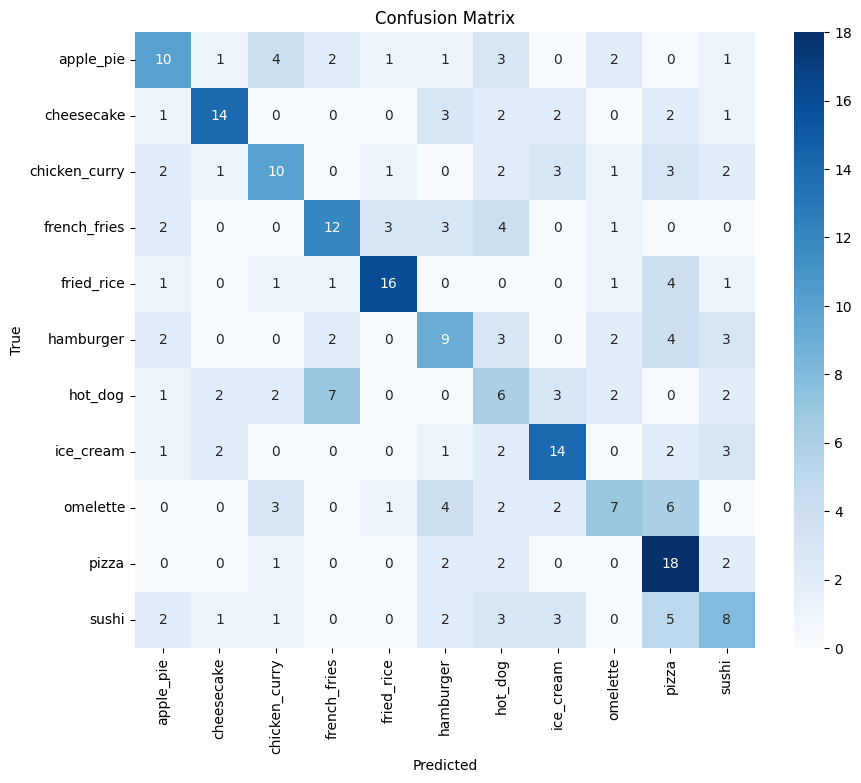

In [29]:
evaluate_and_plot(model4, train_losses4, val_losses4, train_accuracies4, val_accuracies4, test_loader, test_dataset, device4)


Model 5:

Training Hyperparameters:

>>Training Loss: 0.0238, Training Accuracy: 99.91%

>>Validation Loss: 1.7961,  Validation Accuracy: 54.91%

>>Test Accuracy: 47.27%

Optimizer Type: SGD.

Learning Rate (lr): 0.005



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.



In [30]:

model5 = CNNR(num_classes=num_classes)

criterion5 = nn.CrossEntropyLoss()

#model is on the CPU
device5 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5.to(device5)



optimizer5 = torch.optim.SGD(
    model5.parameters(),
    lr=0.005,

    weight_decay=1e-4
)

train_losses5, val_losses5, train_accuracies5, val_accuracies5 = train_model(
    model=model5,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion5,
    optimizer=optimizer5,
    device=device5,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model5.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 2.4921, Training Accuracy: 14.86%


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Validation Loss: 2.2735, Validation Accuracy: 16.00%
Epoch 2/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 2.1388, Training Accuracy: 24.45%


100%|██████████| 9/9 [00:00<00:00,  9.78it/s]


Validation Loss: 2.0162, Validation Accuracy: 35.64%
Epoch 3/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 2.0330, Training Accuracy: 29.23%


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


Validation Loss: 2.0355, Validation Accuracy: 32.00%
Epoch 4/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 1.9268, Training Accuracy: 33.09%


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


Validation Loss: 1.8849, Validation Accuracy: 35.64%
Epoch 5/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.8612, Training Accuracy: 35.77%


100%|██████████| 9/9 [00:00<00:00, 10.57it/s]


Validation Loss: 2.0907, Validation Accuracy: 26.18%
Epoch 6/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 1.7769, Training Accuracy: 40.14%


100%|██████████| 9/9 [00:00<00:00,  9.81it/s]


Validation Loss: 1.8739, Validation Accuracy: 36.00%
Epoch 7/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 1.7252, Training Accuracy: 41.00%


100%|██████████| 9/9 [00:00<00:00, 10.42it/s]


Validation Loss: 1.8943, Validation Accuracy: 32.00%
Epoch 8/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.6640, Training Accuracy: 43.09%


100%|██████████| 9/9 [00:00<00:00, 10.04it/s]


Validation Loss: 1.7817, Validation Accuracy: 40.00%
Epoch 9/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 1.5829, Training Accuracy: 46.77%


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


Validation Loss: 1.8288, Validation Accuracy: 38.18%
Epoch 10/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 1.5436, Training Accuracy: 48.23%


100%|██████████| 9/9 [00:00<00:00,  9.55it/s]


Validation Loss: 1.8238, Validation Accuracy: 40.36%
Epoch 11/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 1.4848, Training Accuracy: 50.91%


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


Validation Loss: 1.8244, Validation Accuracy: 39.27%
Epoch 12/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 1.3809, Training Accuracy: 53.95%


100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


Validation Loss: 1.7180, Validation Accuracy: 40.36%
Epoch 13/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 1.3185, Training Accuracy: 56.55%


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


Validation Loss: 1.9764, Validation Accuracy: 36.36%
Epoch 14/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 1.2457, Training Accuracy: 58.64%


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


Validation Loss: 1.7150, Validation Accuracy: 41.45%
Epoch 15/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.15it/s]


Training Loss: 1.1645, Training Accuracy: 61.64%


100%|██████████| 9/9 [00:00<00:00, 10.51it/s]


Validation Loss: 1.6490, Validation Accuracy: 46.18%
Epoch 16/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


Training Loss: 1.1148, Training Accuracy: 63.18%


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 1.7090, Validation Accuracy: 46.91%
Epoch 17/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 1.0392, Training Accuracy: 65.23%


100%|██████████| 9/9 [00:00<00:00, 10.74it/s]


Validation Loss: 1.8328, Validation Accuracy: 44.00%
Epoch 18/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.9559, Training Accuracy: 67.55%


100%|██████████| 9/9 [00:00<00:00,  9.49it/s]


Validation Loss: 1.7608, Validation Accuracy: 46.18%
Epoch 19/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.12it/s]


Training Loss: 0.8946, Training Accuracy: 70.50%


100%|██████████| 9/9 [00:00<00:00, 10.12it/s]


Validation Loss: 1.6721, Validation Accuracy: 48.36%
Epoch 20/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.7814, Training Accuracy: 75.64%


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


Validation Loss: 1.7386, Validation Accuracy: 44.73%
Epoch 21/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.6897, Training Accuracy: 78.27%


100%|██████████| 9/9 [00:00<00:00, 10.66it/s]


Validation Loss: 2.0233, Validation Accuracy: 38.55%
Epoch 22/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.6450, Training Accuracy: 79.23%


100%|██████████| 9/9 [00:00<00:00,  9.60it/s]


Validation Loss: 1.9827, Validation Accuracy: 42.18%
Epoch 23/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.6287, Training Accuracy: 80.27%


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


Validation Loss: 1.8220, Validation Accuracy: 48.73%
Epoch 24/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.5005, Training Accuracy: 85.23%


100%|██████████| 9/9 [00:00<00:00, 10.20it/s]


Validation Loss: 1.6762, Validation Accuracy: 47.27%
Epoch 25/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.4328, Training Accuracy: 87.45%


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


Validation Loss: 2.1374, Validation Accuracy: 40.00%
Epoch 26/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.4218, Training Accuracy: 88.55%


100%|██████████| 9/9 [00:00<00:00,  9.68it/s]


Validation Loss: 2.0713, Validation Accuracy: 40.36%
Epoch 27/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.3366, Training Accuracy: 90.82%


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 1.8079, Validation Accuracy: 46.55%
Epoch 28/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.3693, Training Accuracy: 90.05%


100%|██████████| 9/9 [00:00<00:00,  9.68it/s]


Validation Loss: 1.9713, Validation Accuracy: 42.18%
Epoch 29/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.2727, Training Accuracy: 93.55%


100%|██████████| 9/9 [00:00<00:00, 10.13it/s]


Validation Loss: 2.0773, Validation Accuracy: 43.27%
Epoch 30/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.2254, Training Accuracy: 93.86%


100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


Validation Loss: 1.6683, Validation Accuracy: 50.55%
Epoch 31/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.2054, Training Accuracy: 94.95%


100%|██████████| 9/9 [00:00<00:00, 10.56it/s]


Validation Loss: 1.7117, Validation Accuracy: 51.64%
Epoch 32/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.1422, Training Accuracy: 97.41%


100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


Validation Loss: 2.0400, Validation Accuracy: 46.18%
Epoch 33/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.1220, Training Accuracy: 97.95%


100%|██████████| 9/9 [00:00<00:00, 10.27it/s]


Validation Loss: 1.8141, Validation Accuracy: 47.64%
Epoch 34/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.1179, Training Accuracy: 98.05%


100%|██████████| 9/9 [00:00<00:00,  9.72it/s]


Validation Loss: 1.7332, Validation Accuracy: 53.45%
Epoch 35/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.1254, Training Accuracy: 97.77%


100%|██████████| 9/9 [00:00<00:00,  9.70it/s]


Validation Loss: 1.7636, Validation Accuracy: 49.82%
Epoch 36/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.16it/s]


Training Loss: 0.0927, Training Accuracy: 98.50%


100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


Validation Loss: 1.7634, Validation Accuracy: 51.64%
Epoch 37/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.1042, Training Accuracy: 97.95%


100%|██████████| 9/9 [00:00<00:00, 10.49it/s]


Validation Loss: 1.7065, Validation Accuracy: 53.09%
Epoch 38/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.0867, Training Accuracy: 98.91%


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


Validation Loss: 1.8309, Validation Accuracy: 49.45%
Epoch 39/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.0597, Training Accuracy: 99.23%


100%|██████████| 9/9 [00:00<00:00, 10.39it/s]


Validation Loss: 1.9479, Validation Accuracy: 51.27%
Epoch 40/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.0635, Training Accuracy: 99.32%


100%|██████████| 9/9 [00:00<00:00, 10.10it/s]


Validation Loss: 1.7818, Validation Accuracy: 53.82%
Epoch 41/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.0400, Training Accuracy: 99.77%


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


Validation Loss: 1.8770, Validation Accuracy: 51.27%
Epoch 42/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.0412, Training Accuracy: 99.64%


100%|██████████| 9/9 [00:00<00:00,  9.72it/s]


Validation Loss: 1.8483, Validation Accuracy: 53.09%
Epoch 43/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.0377, Training Accuracy: 99.73%


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


Validation Loss: 1.8615, Validation Accuracy: 51.64%
Epoch 44/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.0398, Training Accuracy: 99.73%


100%|██████████| 9/9 [00:00<00:00,  9.64it/s]


Validation Loss: 1.8708, Validation Accuracy: 50.55%
Epoch 45/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.0300, Training Accuracy: 99.86%


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


Validation Loss: 1.8356, Validation Accuracy: 52.73%
Epoch 46/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.0351, Training Accuracy: 99.59%


100%|██████████| 9/9 [00:00<00:00, 10.60it/s]


Validation Loss: 1.7924, Validation Accuracy: 52.36%
Epoch 47/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.0345, Training Accuracy: 99.82%


100%|██████████| 9/9 [00:00<00:00, 10.37it/s]


Validation Loss: 1.7886, Validation Accuracy: 53.82%
Epoch 48/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.0296, Training Accuracy: 99.86%


100%|██████████| 9/9 [00:00<00:00, 10.45it/s]


Validation Loss: 1.8480, Validation Accuracy: 52.73%
Epoch 49/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.0249, Training Accuracy: 99.95%


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


Validation Loss: 1.9034, Validation Accuracy: 49.82%
Epoch 50/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.0238, Training Accuracy: 99.91%


100%|██████████| 9/9 [00:00<00:00,  9.93it/s]

Validation Loss: 1.7961, Validation Accuracy: 54.91%


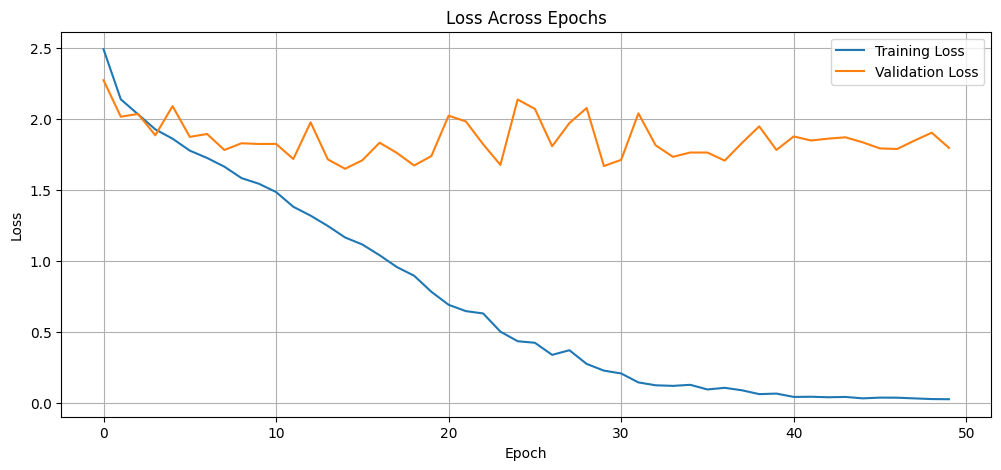

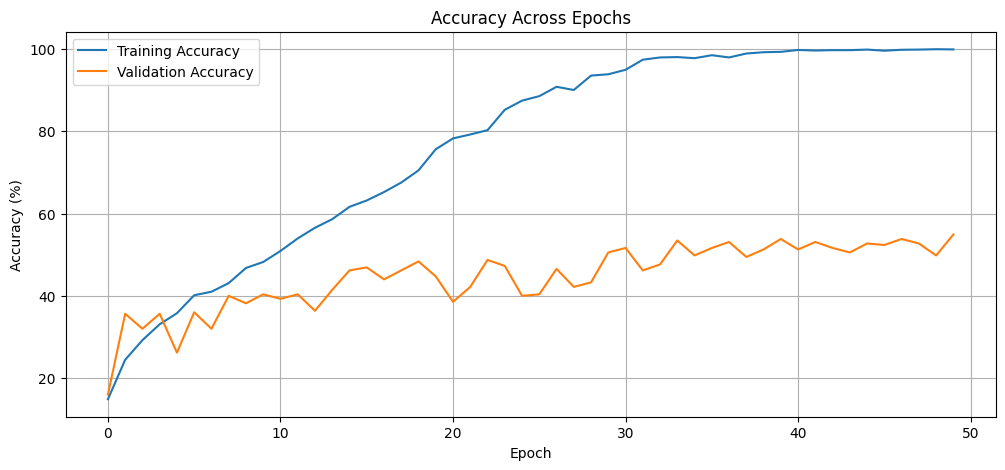

Test Accuracy: 47.27%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.69      0.44      0.54        25
   cheesecake       0.63      0.48      0.55        25
chicken_curry       0.46      0.52      0.49        25
 french_fries       0.52      0.52      0.52        25
   fried_rice       0.62      0.60      0.61        25
    hamburger       0.21      0.28      0.24        25
      hot_dog       0.32      0.28      0.30        25
    ice_cream       0.36      0.36      0.36        25
     omelette       0.44      0.32      0.37        25
        pizza       0.61      0.80      0.69        25
        sushi       0.48      0.60      0.54        25

     accuracy                           0.47       275
    macro avg       0.49      0.47      0.47       275
 weighted avg       0.49      0.47      0.47       275



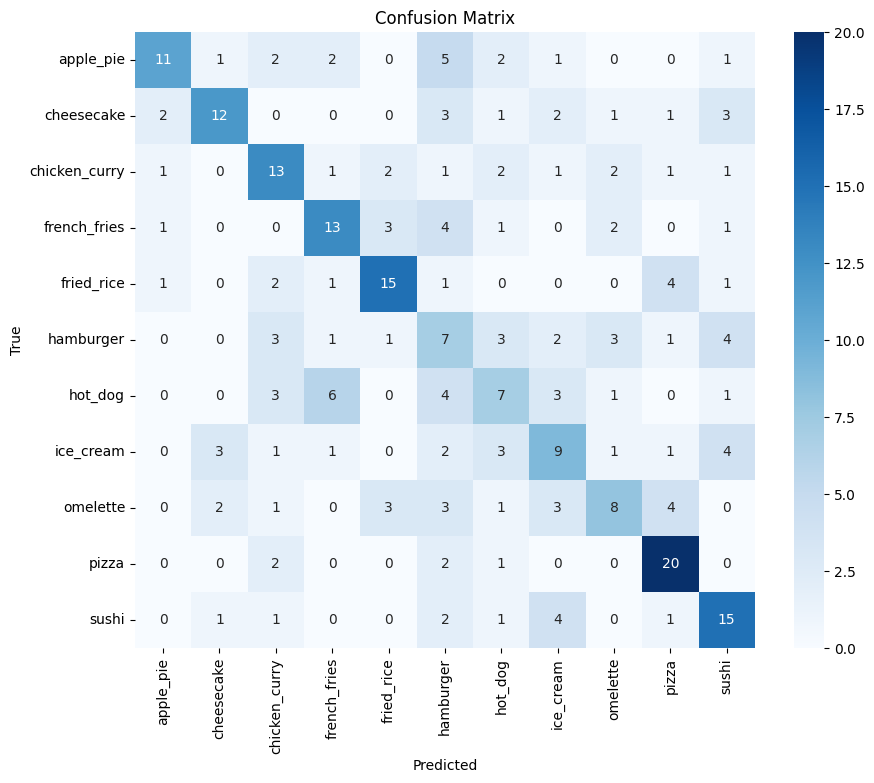

In [31]:
evaluate_and_plot(model5, train_losses5, val_losses5, train_accuracies5, val_accuracies5, test_loader, test_dataset, device5)


Model 6:



Training Hyperparameters:

>>Training Loss: 0.0259, Training Accuracy:  99.36%

>>Validation Loss: 2.6958,  Validation Accuracy: 45.82%

>>Test Accuracy: 41.82%

Optimizer Type: SGD.

Learning Rate (lr): 0.01



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.



In [32]:

model6 = CNNR(num_classes=num_classes)

criterion6 = nn.CrossEntropyLoss()

#model is on the CPU
device6 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model6.to(device6) # Move model to the correct device before calling summary



optimizer6 = torch.optim.SGD(
    model6.parameters(),
    lr=0.01,

    weight_decay=1e-4
)

train_losses6, val_losses6, train_accuracies6, val_accuracies6 = train_model(
    model=model6,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion6,
    optimizer=optimizer6,
    device=device6,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model6.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/69 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 69/69 [00:08<00:00,  8.30it/s]


Training Loss: 3.8276, Training Accuracy: 14.59%


100%|██████████| 9/9 [00:00<00:00,  9.89it/s]


Validation Loss: 2.2758, Validation Accuracy: 15.27%
Epoch 2/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 2.2211, Training Accuracy: 22.23%


100%|██████████| 9/9 [00:00<00:00,  9.66it/s]


Validation Loss: 2.1734, Validation Accuracy: 18.18%
Epoch 3/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 2.1314, Training Accuracy: 24.27%


100%|██████████| 9/9 [00:00<00:00, 10.18it/s]


Validation Loss: 2.0572, Validation Accuracy: 29.09%
Epoch 4/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 2.0455, Training Accuracy: 28.45%


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Validation Loss: 1.9589, Validation Accuracy: 29.82%
Epoch 5/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.9324, Training Accuracy: 33.32%


100%|██████████| 9/9 [00:00<00:00, 10.36it/s]


Validation Loss: 1.8651, Validation Accuracy: 37.45%
Epoch 6/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.8831, Training Accuracy: 35.45%


100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


Validation Loss: 2.0941, Validation Accuracy: 26.55%
Epoch 7/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 1.8218, Training Accuracy: 36.32%


100%|██████████| 9/9 [00:00<00:00,  9.73it/s]


Validation Loss: 1.8038, Validation Accuracy: 35.64%
Epoch 8/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.26it/s]


Training Loss: 1.7520, Training Accuracy: 40.14%


100%|██████████| 9/9 [00:00<00:00, 10.34it/s]


Validation Loss: 1.8072, Validation Accuracy: 38.55%
Epoch 9/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.6619, Training Accuracy: 44.14%


100%|██████████| 9/9 [00:00<00:00, 10.63it/s]


Validation Loss: 1.9293, Validation Accuracy: 31.27%
Epoch 10/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.27it/s]


Training Loss: 1.6252, Training Accuracy: 42.86%


100%|██████████| 9/9 [00:00<00:00,  9.79it/s]


Validation Loss: 2.0076, Validation Accuracy: 31.64%
Epoch 11/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.17it/s]


Training Loss: 1.5514, Training Accuracy: 46.86%


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


Validation Loss: 1.8474, Validation Accuracy: 39.64%
Epoch 12/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 1.4395, Training Accuracy: 51.64%


100%|██████████| 9/9 [00:00<00:00, 10.92it/s]


Validation Loss: 1.9607, Validation Accuracy: 37.82%
Epoch 13/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.3803, Training Accuracy: 53.95%


100%|██████████| 9/9 [00:00<00:00, 10.04it/s]


Validation Loss: 2.0534, Validation Accuracy: 36.36%
Epoch 14/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.2965, Training Accuracy: 56.82%


100%|██████████| 9/9 [00:00<00:00,  9.61it/s]


Validation Loss: 2.1382, Validation Accuracy: 34.55%
Epoch 15/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 1.2224, Training Accuracy: 58.05%


100%|██████████| 9/9 [00:00<00:00, 10.25it/s]


Validation Loss: 1.7604, Validation Accuracy: 43.64%
Epoch 16/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.1601, Training Accuracy: 61.41%


100%|██████████| 9/9 [00:00<00:00, 10.30it/s]


Validation Loss: 1.8574, Validation Accuracy: 40.00%
Epoch 17/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 1.0202, Training Accuracy: 66.68%


100%|██████████| 9/9 [00:00<00:00, 10.21it/s]


Validation Loss: 1.9647, Validation Accuracy: 43.27%
Epoch 18/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.9794, Training Accuracy: 68.14%


100%|██████████| 9/9 [00:00<00:00,  9.55it/s]


Validation Loss: 2.0412, Validation Accuracy: 37.09%
Epoch 19/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.9023, Training Accuracy: 69.64%


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


Validation Loss: 2.3134, Validation Accuracy: 32.73%
Epoch 20/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.8040, Training Accuracy: 73.64%


100%|██████████| 9/9 [00:00<00:00, 10.03it/s]


Validation Loss: 2.0437, Validation Accuracy: 40.00%
Epoch 21/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.6698, Training Accuracy: 77.91%


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 2.7455, Validation Accuracy: 39.64%
Epoch 22/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 0.6677, Training Accuracy: 77.86%


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


Validation Loss: 1.8676, Validation Accuracy: 44.73%
Epoch 23/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 0.5946, Training Accuracy: 79.95%


100%|██████████| 9/9 [00:00<00:00, 10.95it/s]


Validation Loss: 2.0046, Validation Accuracy: 44.36%
Epoch 24/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.4643, Training Accuracy: 85.95%


100%|██████████| 9/9 [00:00<00:00, 10.11it/s]


Validation Loss: 2.2110, Validation Accuracy: 43.27%
Epoch 25/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.4808, Training Accuracy: 84.41%


100%|██████████| 9/9 [00:00<00:00, 10.45it/s]


Validation Loss: 2.7915, Validation Accuracy: 32.36%
Epoch 26/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.3823, Training Accuracy: 87.86%


100%|██████████| 9/9 [00:00<00:00,  9.76it/s]


Validation Loss: 2.2664, Validation Accuracy: 41.09%
Epoch 27/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.3452, Training Accuracy: 88.91%


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


Validation Loss: 2.2407, Validation Accuracy: 43.27%
Epoch 28/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.3814, Training Accuracy: 89.05%


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


Validation Loss: 2.3541, Validation Accuracy: 40.36%
Epoch 29/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.2095, Training Accuracy: 93.68%


100%|██████████| 9/9 [00:00<00:00,  9.90it/s]


Validation Loss: 2.5023, Validation Accuracy: 41.45%
Epoch 30/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.2283, Training Accuracy: 92.91%


100%|██████████| 9/9 [00:00<00:00,  9.68it/s]


Validation Loss: 2.5324, Validation Accuracy: 42.18%
Epoch 31/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.1546, Training Accuracy: 95.77%


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


Validation Loss: 2.3872, Validation Accuracy: 45.45%
Epoch 32/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.25it/s]


Training Loss: 0.1183, Training Accuracy: 97.05%


100%|██████████| 9/9 [00:00<00:00, 10.32it/s]


Validation Loss: 2.4819, Validation Accuracy: 43.27%
Epoch 33/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.1453, Training Accuracy: 95.36%


100%|██████████| 9/9 [00:00<00:00, 10.15it/s]


Validation Loss: 2.6804, Validation Accuracy: 41.45%
Epoch 34/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.19it/s]


Training Loss: 0.1123, Training Accuracy: 97.18%


100%|██████████| 9/9 [00:00<00:00,  9.95it/s]


Validation Loss: 2.2133, Validation Accuracy: 48.36%
Epoch 35/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.0742, Training Accuracy: 98.32%


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


Validation Loss: 2.2386, Validation Accuracy: 48.00%
Epoch 36/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.0839, Training Accuracy: 98.18%


100%|██████████| 9/9 [00:00<00:00, 10.17it/s]


Validation Loss: 2.3631, Validation Accuracy: 44.36%
Epoch 37/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.0700, Training Accuracy: 98.18%


100%|██████████| 9/9 [00:00<00:00,  9.86it/s]


Validation Loss: 2.3495, Validation Accuracy: 46.91%
Epoch 38/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.0561, Training Accuracy: 98.82%


100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


Validation Loss: 2.3446, Validation Accuracy: 48.36%
Epoch 39/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.22it/s]


Training Loss: 0.0477, Training Accuracy: 98.82%


100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


Validation Loss: 2.3282, Validation Accuracy: 45.45%
Epoch 40/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.0320, Training Accuracy: 99.45%


100%|██████████| 9/9 [00:00<00:00, 10.28it/s]


Validation Loss: 2.4713, Validation Accuracy: 41.82%
Epoch 41/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Training Loss: 0.0439, Training Accuracy: 99.00%


100%|██████████| 9/9 [00:00<00:00, 10.16it/s]


Validation Loss: 2.4011, Validation Accuracy: 44.00%
Epoch 42/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.0376, Training Accuracy: 99.09%


100%|██████████| 9/9 [00:00<00:00,  9.57it/s]


Validation Loss: 2.6590, Validation Accuracy: 46.55%
Epoch 43/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.0341, Training Accuracy: 99.23%


100%|██████████| 9/9 [00:00<00:00, 10.55it/s]


Validation Loss: 2.4927, Validation Accuracy: 43.27%
Epoch 44/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.18it/s]


Training Loss: 0.0754, Training Accuracy: 98.00%


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


Validation Loss: 2.6164, Validation Accuracy: 45.82%
Epoch 45/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.0324, Training Accuracy: 99.32%


100%|██████████| 9/9 [00:00<00:00, 10.59it/s]


Validation Loss: 2.3727, Validation Accuracy: 45.82%
Epoch 46/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.0363, Training Accuracy: 99.14%


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


Validation Loss: 2.4858, Validation Accuracy: 48.73%
Epoch 47/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.0248, Training Accuracy: 99.59%


100%|██████████| 9/9 [00:00<00:00,  9.77it/s]


Validation Loss: 2.4579, Validation Accuracy: 49.45%
Epoch 48/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.24it/s]


Training Loss: 0.0247, Training Accuracy: 99.59%


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


Validation Loss: 2.4203, Validation Accuracy: 48.00%
Epoch 49/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.21it/s]


Training Loss: 0.0283, Training Accuracy: 99.45%


100%|██████████| 9/9 [00:00<00:00, 10.02it/s]


Validation Loss: 2.5349, Validation Accuracy: 44.73%
Epoch 50/50
------------------------------


100%|██████████| 69/69 [00:08<00:00,  8.23it/s]


Training Loss: 0.0259, Training Accuracy: 99.36%


100%|██████████| 9/9 [00:00<00:00,  9.72it/s]

Validation Loss: 2.6958, Validation Accuracy: 45.82%


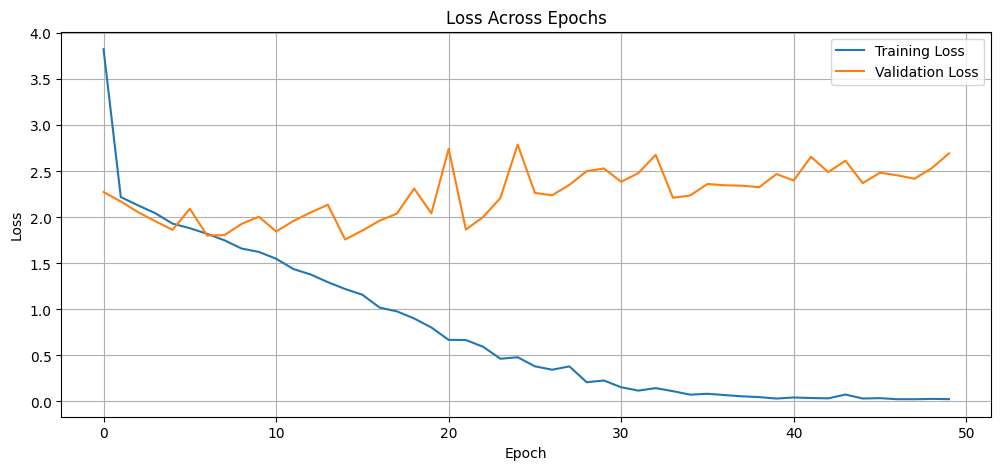

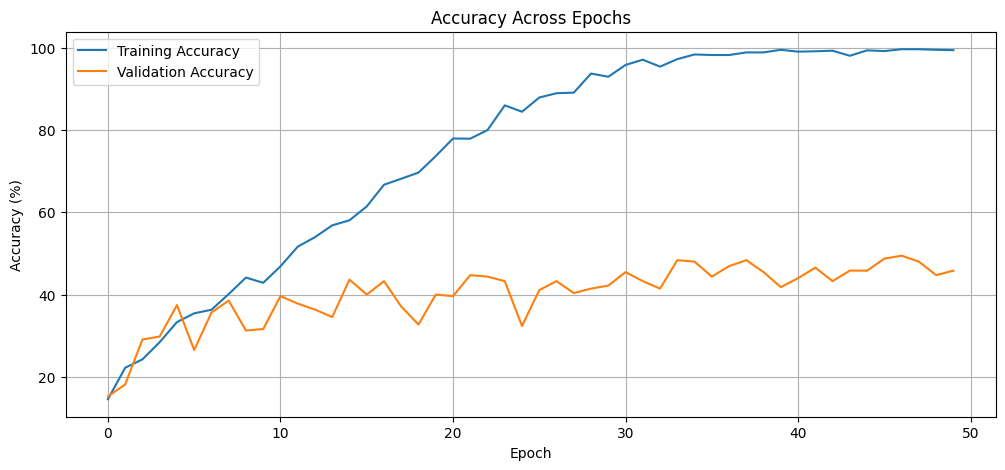

Test Accuracy: 41.82%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.41      0.44      0.42        25
   cheesecake       0.67      0.24      0.35        25
chicken_curry       0.33      0.32      0.33        25
 french_fries       0.50      0.44      0.47        25
   fried_rice       0.64      0.72      0.68        25
    hamburger       0.18      0.08      0.11        25
      hot_dog       0.29      0.20      0.24        25
    ice_cream       0.38      0.48      0.42        25
     omelette       0.28      0.32      0.30        25
        pizza       0.47      0.76      0.58        25
        sushi       0.42      0.60      0.49        25

     accuracy                           0.42       275
    macro avg       0.42      0.42      0.40       275
 weighted avg       0.42      0.42      0.40       275



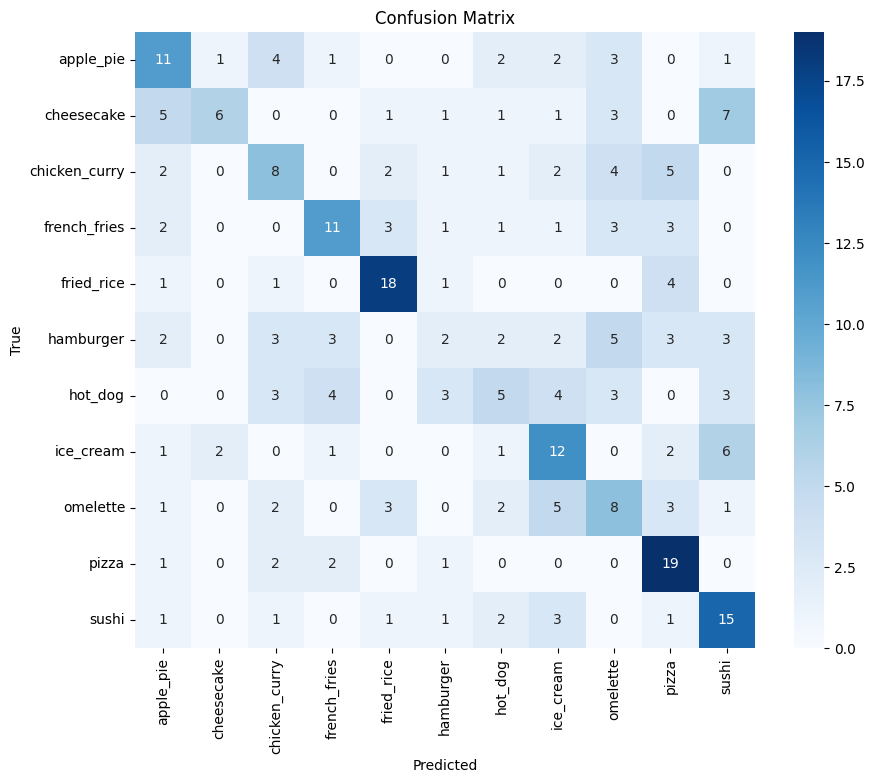

In [33]:
evaluate_and_plot(model6, train_losses6, val_losses6, train_accuracies6, val_accuracies6, test_loader, test_dataset, device6)


################################################################################

##None resudual models with 64 batch sizes and 3 different learning rates


Model 7:

Training Hyperparameters:

>>Training Loss: 0.1019, Training Accuracy: 98.55%

>>Validation Loss: 2.2136, Validation Accuracy: 46.55%

>>Test Accuracy: 40.73%

Optimizer Type: SGD.

Learning Rate (lr): 0.01



Number of Epochs: 50

Batch Size:64

Loss Function:CrossEntropy Loss for multi-class classification tasks.




In [38]:

model7 = CNN(num_classes=num_classes)

criterion7 = nn.CrossEntropyLoss()

#model is on the CPU
device7 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model7.to(device7)



optimizer7 = torch.optim.SGD(
    model7.parameters(),
    lr=0.01,

    weight_decay=1e-4
)

train_losses7, val_losses7, train_accuracies7, val_accuracies7 = train_model(
    model=model7,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion7,
    optimizer=optimizer7,
    device=device7,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model7.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:06<00:00,  5.03it/s]


Training Loss: 2.3670, Training Accuracy: 15.68%


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Validation Loss: 2.3614, Validation Accuracy: 12.73%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


Training Loss: 2.1673, Training Accuracy: 23.64%


100%|██████████| 5/5 [00:00<00:00,  5.47it/s]


Validation Loss: 2.0668, Validation Accuracy: 27.27%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 2.0451, Training Accuracy: 27.95%


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


Validation Loss: 2.0414, Validation Accuracy: 26.55%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 1.9477, Training Accuracy: 32.86%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 2.1138, Validation Accuracy: 25.45%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


Training Loss: 1.8746, Training Accuracy: 34.95%


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Validation Loss: 2.0986, Validation Accuracy: 24.73%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 1.8311, Training Accuracy: 36.14%


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


Validation Loss: 1.8394, Validation Accuracy: 36.00%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 1.7498, Training Accuracy: 39.86%


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Validation Loss: 1.9608, Validation Accuracy: 33.09%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 1.7040, Training Accuracy: 43.32%


100%|██████████| 5/5 [00:00<00:00,  5.46it/s]


Validation Loss: 2.0054, Validation Accuracy: 34.91%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 1.6781, Training Accuracy: 43.18%


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


Validation Loss: 1.8069, Validation Accuracy: 38.91%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 1.6077, Training Accuracy: 46.23%


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


Validation Loss: 1.8916, Validation Accuracy: 35.27%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 1.5547, Training Accuracy: 48.18%


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 1.8452, Validation Accuracy: 36.73%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 1.5044, Training Accuracy: 50.27%


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Validation Loss: 1.6614, Validation Accuracy: 41.45%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 1.5123, Training Accuracy: 48.41%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 1.7641, Validation Accuracy: 42.55%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 1.4256, Training Accuracy: 53.14%


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Validation Loss: 2.0341, Validation Accuracy: 38.18%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 1.3841, Training Accuracy: 53.59%


100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


Validation Loss: 1.8217, Validation Accuracy: 39.64%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 1.3480, Training Accuracy: 54.86%


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Validation Loss: 1.6762, Validation Accuracy: 42.91%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 1.2573, Training Accuracy: 58.05%


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Validation Loss: 1.6570, Validation Accuracy: 47.64%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.46it/s]


Training Loss: 1.2312, Training Accuracy: 58.41%


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Validation Loss: 2.0953, Validation Accuracy: 40.36%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.46it/s]


Training Loss: 1.1900, Training Accuracy: 60.14%


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Validation Loss: 1.7566, Validation Accuracy: 45.45%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 1.1558, Training Accuracy: 62.00%


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Validation Loss: 2.0102, Validation Accuracy: 38.18%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.48it/s]


Training Loss: 1.0883, Training Accuracy: 64.59%


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Validation Loss: 1.6382, Validation Accuracy: 45.82%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.52it/s]


Training Loss: 1.0532, Training Accuracy: 64.41%


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


Validation Loss: 2.2966, Validation Accuracy: 36.00%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.0048, Training Accuracy: 66.32%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 1.5943, Validation Accuracy: 53.09%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.9902, Training Accuracy: 66.77%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 2.1669, Validation Accuracy: 32.36%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.43it/s]


Training Loss: 0.9442, Training Accuracy: 69.23%


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Validation Loss: 2.1311, Validation Accuracy: 40.73%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 0.8967, Training Accuracy: 70.23%


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Validation Loss: 2.2420, Validation Accuracy: 33.09%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 0.8408, Training Accuracy: 71.91%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 2.2350, Validation Accuracy: 38.18%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.45it/s]


Training Loss: 0.8088, Training Accuracy: 73.41%


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Validation Loss: 1.9352, Validation Accuracy: 42.55%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.7423, Training Accuracy: 75.05%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 2.0084, Validation Accuracy: 40.36%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 0.7362, Training Accuracy: 76.09%


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Validation Loss: 1.8982, Validation Accuracy: 44.00%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.6710, Training Accuracy: 78.59%


100%|██████████| 5/5 [00:00<00:00,  5.03it/s]


Validation Loss: 2.1420, Validation Accuracy: 42.91%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.6199, Training Accuracy: 80.55%


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Validation Loss: 1.7642, Validation Accuracy: 48.00%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 0.5488, Training Accuracy: 81.73%


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Validation Loss: 1.8430, Validation Accuracy: 49.45%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.46it/s]


Training Loss: 0.5323, Training Accuracy: 83.68%


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


Validation Loss: 2.0255, Validation Accuracy: 43.27%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.59it/s]


Training Loss: 0.5111, Training Accuracy: 84.27%


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


Validation Loss: 1.9611, Validation Accuracy: 43.27%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 0.4542, Training Accuracy: 86.41%


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Validation Loss: 2.6892, Validation Accuracy: 35.27%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.4473, Training Accuracy: 87.23%


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 1.8343, Validation Accuracy: 47.27%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.3991, Training Accuracy: 88.77%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 1.7027, Validation Accuracy: 49.09%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.97it/s]


Training Loss: 0.3430, Training Accuracy: 91.18%


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Validation Loss: 1.7638, Validation Accuracy: 48.73%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 0.3124, Training Accuracy: 91.55%


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Loss: 1.6002, Validation Accuracy: 49.45%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.2888, Training Accuracy: 92.91%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 1.8013, Validation Accuracy: 48.36%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.99it/s]


Training Loss: 0.2409, Training Accuracy: 94.41%


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Loss: 1.4758, Validation Accuracy: 54.55%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 0.2090, Training Accuracy: 95.73%


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Validation Loss: 1.5723, Validation Accuracy: 55.64%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.2073, Training Accuracy: 96.32%


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Validation Loss: 1.5189, Validation Accuracy: 53.45%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.2195, Training Accuracy: 94.82%


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Validation Loss: 1.7927, Validation Accuracy: 53.09%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.1643, Training Accuracy: 97.27%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 1.4464, Validation Accuracy: 54.91%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.1503, Training Accuracy: 97.18%


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation Loss: 1.7304, Validation Accuracy: 54.18%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.1786, Training Accuracy: 96.18%


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


Validation Loss: 1.7765, Validation Accuracy: 51.27%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 0.1315, Training Accuracy: 97.68%


100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Validation Loss: 1.5447, Validation Accuracy: 54.55%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 0.1019, Training Accuracy: 98.55%


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]

Validation Loss: 2.2136, Validation Accuracy: 46.55%


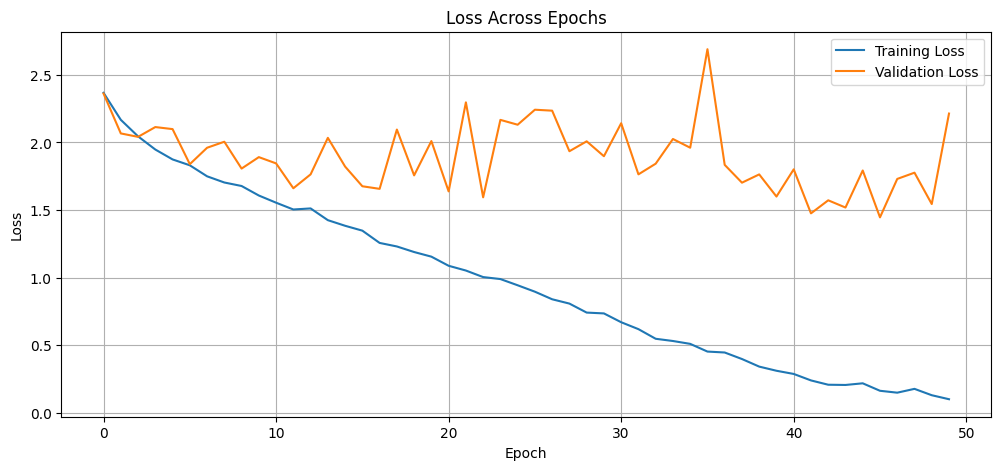

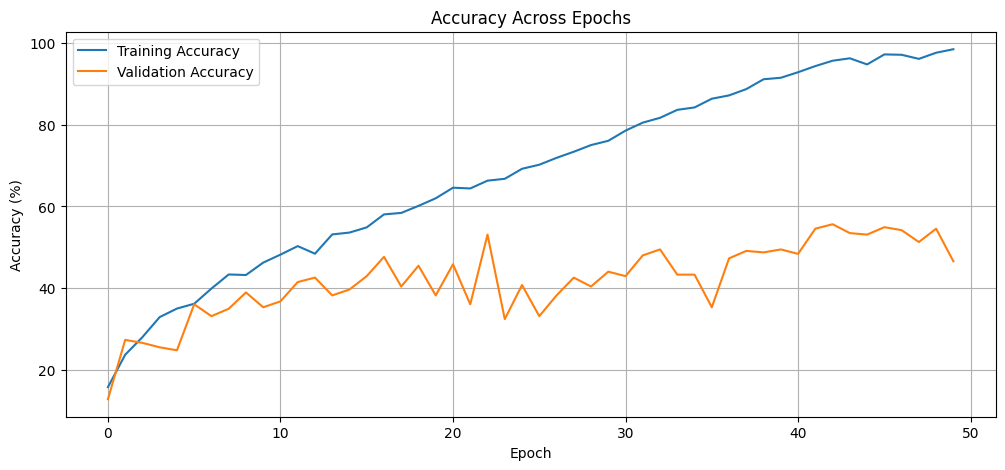

Test Accuracy: 40.73%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.24      0.72      0.36        25
   cheesecake       0.63      0.48      0.55        25
chicken_curry       0.62      0.20      0.30        25
 french_fries       0.42      0.76      0.54        25
   fried_rice       0.88      0.28      0.42        25
    hamburger       0.58      0.28      0.38        25
      hot_dog       0.26      0.28      0.27        25
    ice_cream       0.50      0.32      0.39        25
     omelette       1.00      0.04      0.08        25
        pizza       0.41      0.72      0.52        25
        sushi       0.53      0.40      0.45        25

     accuracy                           0.41       275
    macro avg       0.55      0.41      0.39       275
 weighted avg       0.55      0.41      0.39       275



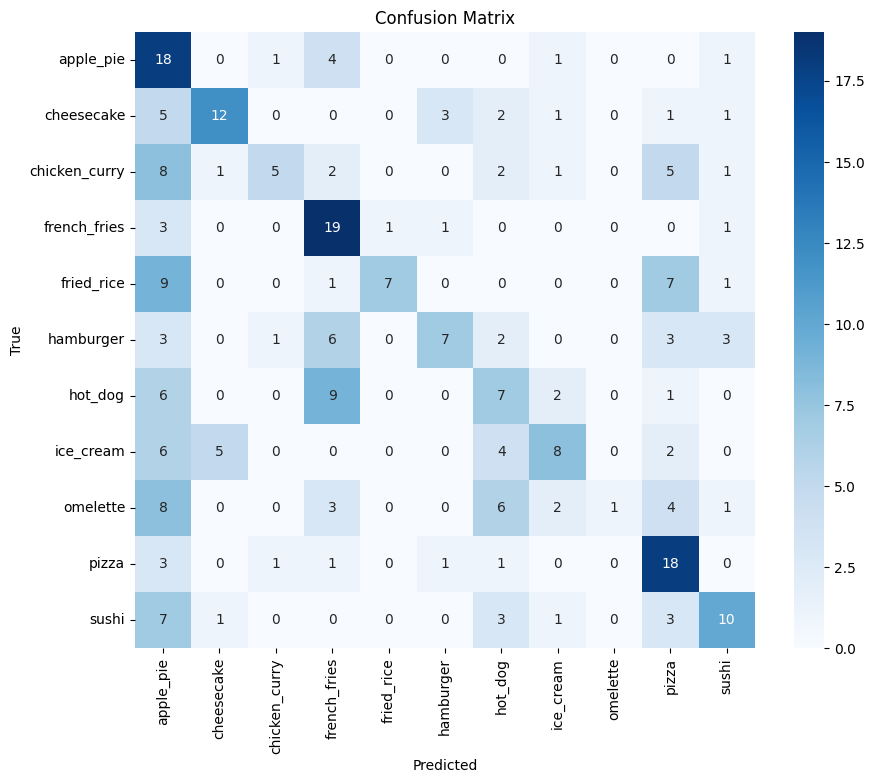

In [39]:
evaluate_and_plot(model7, train_losses7, val_losses7, train_accuracies7, val_accuracies7, test_loader, test_dataset, device7)




Model 8:

Training Hyperparameters:

>>Training Loss: 0.2893, Training Accuracy: 93.14%

>>Validation Loss: 1.7062, Validation Accuracy: 46.91%

>>Test Accuracy: 47.27%

Optimizer Type: SGD.

Learning Rate (lr): 0.005



Number of Epochs: 50

Batch Size:64

Loss Function:CrossEntropy Loss for multi-class classification tasks.

In [40]:

model8 = CNN(num_classes=num_classes)

criterion8 = nn.CrossEntropyLoss()

#model is on the CPU
device8 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model8.to(device8)

optimizer8 = torch.optim.SGD(
    model8.parameters(),
    lr=0.005,

    weight_decay=1e-4
)

train_losses8, val_losses8, train_accuracies8, val_accuracies8 = train_model(
    model=model8,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion8,
    optimizer=optimizer8,
    device=device8,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model8.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 2.3657, Training Accuracy: 15.05%


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Validation Loss: 2.2921, Validation Accuracy: 18.18%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 2.1600, Training Accuracy: 23.77%


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Validation Loss: 2.1885, Validation Accuracy: 24.73%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 2.0481, Training Accuracy: 29.64%


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Validation Loss: 2.1684, Validation Accuracy: 24.36%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.05it/s]


Training Loss: 1.9651, Training Accuracy: 30.77%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 2.1471, Validation Accuracy: 21.09%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 1.8796, Training Accuracy: 35.32%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.9403, Validation Accuracy: 31.27%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.7848, Training Accuracy: 41.14%


100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


Validation Loss: 2.0306, Validation Accuracy: 31.27%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 1.7574, Training Accuracy: 41.41%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 2.0471, Validation Accuracy: 29.82%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 1.6840, Training Accuracy: 44.05%


100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Validation Loss: 1.8408, Validation Accuracy: 32.36%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 1.6397, Training Accuracy: 44.82%


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Validation Loss: 1.9766, Validation Accuracy: 30.91%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.6168, Training Accuracy: 45.91%


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


Validation Loss: 1.8949, Validation Accuracy: 32.36%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 1.5478, Training Accuracy: 47.86%


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Validation Loss: 1.8630, Validation Accuracy: 32.00%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.58it/s]


Training Loss: 1.5168, Training Accuracy: 49.64%


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


Validation Loss: 2.0126, Validation Accuracy: 33.82%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 1.4554, Training Accuracy: 50.64%


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


Validation Loss: 1.8509, Validation Accuracy: 41.82%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.4152, Training Accuracy: 53.00%


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Validation Loss: 1.8229, Validation Accuracy: 40.73%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 1.3951, Training Accuracy: 53.91%


100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


Validation Loss: 2.1354, Validation Accuracy: 33.82%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Training Loss: 1.3706, Training Accuracy: 55.18%


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Validation Loss: 1.7500, Validation Accuracy: 39.27%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Training Loss: 1.2746, Training Accuracy: 58.41%


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Validation Loss: 1.9136, Validation Accuracy: 39.64%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.2886, Training Accuracy: 57.59%


100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Validation Loss: 1.6490, Validation Accuracy: 46.18%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 1.2001, Training Accuracy: 61.32%


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


Validation Loss: 1.8819, Validation Accuracy: 36.73%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.1651, Training Accuracy: 63.00%


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Validation Loss: 1.8804, Validation Accuracy: 38.55%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.1304, Training Accuracy: 63.41%


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


Validation Loss: 2.1028, Validation Accuracy: 32.00%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 1.1109, Training Accuracy: 64.14%


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Validation Loss: 1.8898, Validation Accuracy: 39.64%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 1.0663, Training Accuracy: 65.36%


100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Validation Loss: 1.7934, Validation Accuracy: 45.09%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.01it/s]


Training Loss: 1.0117, Training Accuracy: 68.36%


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation Loss: 1.9006, Validation Accuracy: 45.09%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.08it/s]


Training Loss: 1.0325, Training Accuracy: 67.09%


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Validation Loss: 1.5746, Validation Accuracy: 50.55%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 0.9947, Training Accuracy: 68.36%


100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Validation Loss: 1.8244, Validation Accuracy: 42.91%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.01it/s]


Training Loss: 0.9450, Training Accuracy: 70.50%


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Validation Loss: 1.4449, Validation Accuracy: 53.09%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.99it/s]


Training Loss: 0.9265, Training Accuracy: 70.32%


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Validation Loss: 2.3408, Validation Accuracy: 33.09%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 0.8955, Training Accuracy: 72.00%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 1.9487, Validation Accuracy: 41.09%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.16it/s]


Training Loss: 0.8356, Training Accuracy: 73.45%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 1.7157, Validation Accuracy: 43.27%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.03it/s]


Training Loss: 0.7874, Training Accuracy: 75.82%


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Validation Loss: 1.6804, Validation Accuracy: 46.91%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 0.7287, Training Accuracy: 77.41%


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


Validation Loss: 1.9997, Validation Accuracy: 37.82%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.7558, Training Accuracy: 76.82%


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Validation Loss: 1.6998, Validation Accuracy: 49.09%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.6593, Training Accuracy: 80.68%


100%|██████████| 5/5 [00:00<00:00,  5.20it/s]


Validation Loss: 2.1044, Validation Accuracy: 37.45%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.7294, Training Accuracy: 77.45%


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Validation Loss: 1.8305, Validation Accuracy: 41.09%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.03it/s]


Training Loss: 0.6658, Training Accuracy: 79.55%


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Validation Loss: 1.6719, Validation Accuracy: 48.00%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.02it/s]


Training Loss: 0.5859, Training Accuracy: 83.18%


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


Validation Loss: 1.8019, Validation Accuracy: 43.64%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 0.5830, Training Accuracy: 83.00%


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Validation Loss: 1.6072, Validation Accuracy: 46.55%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 0.6067, Training Accuracy: 82.00%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 1.5972, Validation Accuracy: 49.82%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


Training Loss: 0.5218, Training Accuracy: 85.55%


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Validation Loss: 1.8740, Validation Accuracy: 41.09%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 0.5226, Training Accuracy: 84.59%


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Validation Loss: 1.9004, Validation Accuracy: 46.91%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.4629, Training Accuracy: 87.36%


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


Validation Loss: 1.5385, Validation Accuracy: 54.55%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 0.4422, Training Accuracy: 88.36%


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


Validation Loss: 1.6214, Validation Accuracy: 45.82%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.4433, Training Accuracy: 87.59%


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Validation Loss: 1.4852, Validation Accuracy: 49.09%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  5.00it/s]


Training Loss: 0.3602, Training Accuracy: 91.32%


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 1.8683, Validation Accuracy: 46.18%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.3777, Training Accuracy: 90.64%


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


Validation Loss: 1.4988, Validation Accuracy: 52.73%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.3435, Training Accuracy: 91.00%


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 1.3908, Validation Accuracy: 52.73%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.09it/s]


Training Loss: 0.3318, Training Accuracy: 91.50%


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation Loss: 1.6110, Validation Accuracy: 46.91%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 0.3291, Training Accuracy: 92.41%


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Validation Loss: 1.6764, Validation Accuracy: 51.27%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 0.2893, Training Accuracy: 93.14%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]

Validation Loss: 1.7062, Validation Accuracy: 46.91%


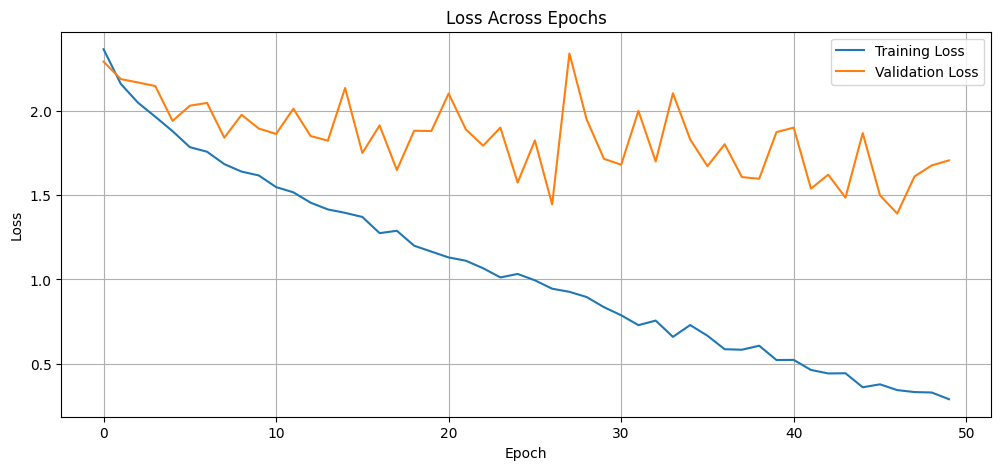

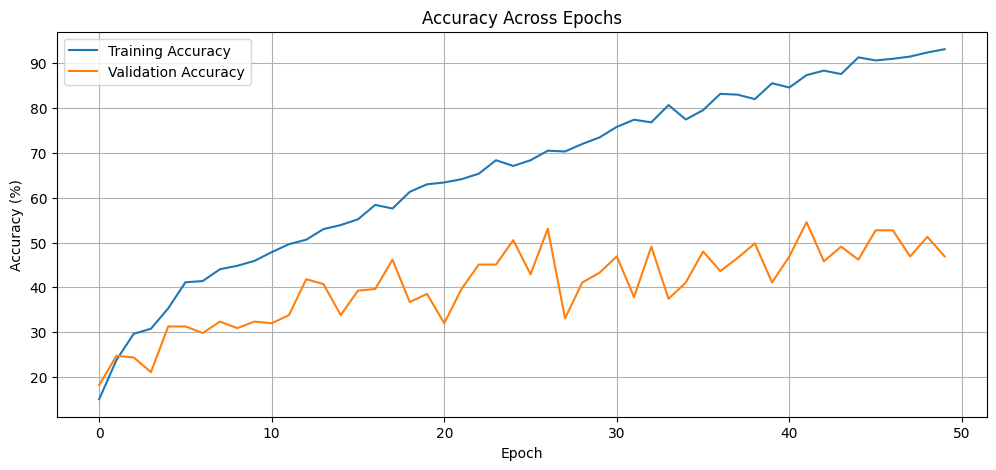

Test Accuracy: 47.27%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.67      0.40      0.50        25
   cheesecake       0.50      0.64      0.56        25
chicken_curry       0.41      0.64      0.50        25
 french_fries       0.46      0.68      0.55        25
   fried_rice       1.00      0.40      0.57        25
    hamburger       0.36      0.16      0.22        25
      hot_dog       1.00      0.12      0.21        25
    ice_cream       0.61      0.44      0.51        25
     omelette       0.25      0.56      0.35        25
        pizza       0.49      0.80      0.61        25
        sushi       0.64      0.36      0.46        25

     accuracy                           0.47       275
    macro avg       0.58      0.47      0.46       275
 weighted avg       0.58      0.47      0.46       275



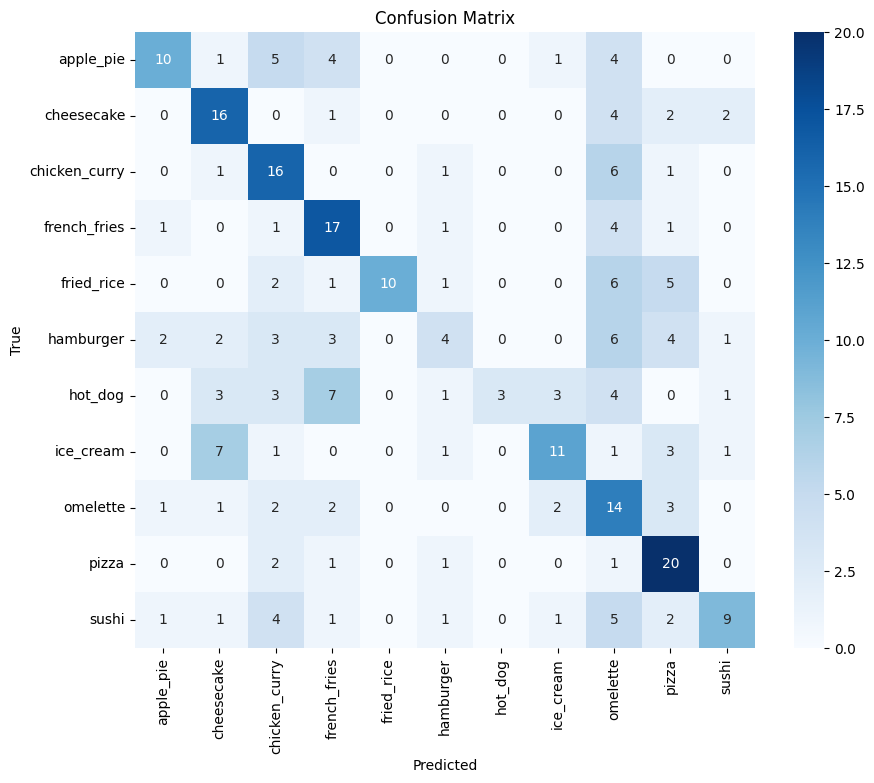

In [41]:
evaluate_and_plot(model8, train_losses8, val_losses8, train_accuracies8, val_accuracies8, test_loader, test_dataset, device8)


Model 9:

Training Hyperparameters:

>>Training Loss: 0.1252, Training Accuracy: 97.82%

>>Validation Loss: 2.6060, Validation Accuracy: 42.91%

>>Test Accuracy: 36.00%

Optimizer Type: SGD.

Learning Rate (lr): 0.001



Number of Epochs: 50

Batch Size:64

Loss Function:CrossEntropy Loss for multi-class classification tasks.

In [42]:

model9 = CNN(num_classes=num_classes)

criterion9 = nn.CrossEntropyLoss()

#model is on the CPU
device9 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model9.to(device9)


optimizer9 = torch.optim.SGD(
    model9.parameters(),
    lr=0.001,

    weight_decay=1e-4
)

train_losses9, val_losses9, train_accuracies9, val_accuracies9 = train_model(
    model=model9,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion9,
    optimizer=optimizer9,
    device=device9,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model9.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:06<00:00,  5.14it/s]


Training Loss: 2.3559, Training Accuracy: 14.41%


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Validation Loss: 2.2615, Validation Accuracy: 16.73%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.97it/s]


Training Loss: 2.1500, Training Accuracy: 24.23%


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Loss: 2.1273, Validation Accuracy: 24.00%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 2.0375, Training Accuracy: 29.27%


100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Validation Loss: 2.0983, Validation Accuracy: 25.82%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 1.9658, Training Accuracy: 33.32%


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Validation Loss: 2.0654, Validation Accuracy: 28.36%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.8783, Training Accuracy: 34.91%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 2.0670, Validation Accuracy: 28.73%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 1.8160, Training Accuracy: 38.50%


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


Validation Loss: 2.1410, Validation Accuracy: 24.73%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.13it/s]


Training Loss: 1.7688, Training Accuracy: 39.95%


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


Validation Loss: 1.8937, Validation Accuracy: 36.36%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.7215, Training Accuracy: 41.36%


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


Validation Loss: 1.8735, Validation Accuracy: 33.09%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.04it/s]


Training Loss: 1.6461, Training Accuracy: 45.82%


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Validation Loss: 3.1748, Validation Accuracy: 17.82%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 1.6556, Training Accuracy: 44.23%


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 1.9451, Validation Accuracy: 35.27%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 1.5591, Training Accuracy: 47.45%


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Validation Loss: 2.1678, Validation Accuracy: 33.82%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 1.5005, Training Accuracy: 48.86%


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Validation Loss: 2.0642, Validation Accuracy: 32.36%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 1.4848, Training Accuracy: 51.36%


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 1.8273, Validation Accuracy: 40.00%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 1.4021, Training Accuracy: 53.00%


100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Validation Loss: 1.7171, Validation Accuracy: 41.82%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 1.3708, Training Accuracy: 55.23%


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Validation Loss: 1.8442, Validation Accuracy: 37.09%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 1.3174, Training Accuracy: 56.27%


100%|██████████| 5/5 [00:00<00:00,  5.56it/s]


Validation Loss: 2.0344, Validation Accuracy: 36.36%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 1.2514, Training Accuracy: 59.36%


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Validation Loss: 2.6554, Validation Accuracy: 29.82%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.2412, Training Accuracy: 58.86%


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Validation Loss: 1.8569, Validation Accuracy: 41.45%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 1.1704, Training Accuracy: 61.59%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.8592, Validation Accuracy: 43.27%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 1.1209, Training Accuracy: 62.77%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.9635, Validation Accuracy: 38.18%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.03it/s]


Training Loss: 1.0750, Training Accuracy: 65.50%


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Validation Loss: 2.1493, Validation Accuracy: 36.73%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  5.00it/s]


Training Loss: 1.0828, Training Accuracy: 63.77%


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


Validation Loss: 1.8222, Validation Accuracy: 44.73%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.9456, Training Accuracy: 70.05%


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Validation Loss: 1.8721, Validation Accuracy: 42.18%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.07it/s]


Training Loss: 0.9712, Training Accuracy: 68.41%


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Validation Loss: 1.9502, Validation Accuracy: 41.09%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 0.8860, Training Accuracy: 71.09%


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


Validation Loss: 1.9503, Validation Accuracy: 43.27%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.8600, Training Accuracy: 71.55%


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Loss: 1.5473, Validation Accuracy: 50.55%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 0.7847, Training Accuracy: 75.05%


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Validation Loss: 2.7850, Validation Accuracy: 34.91%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.8200, Training Accuracy: 73.05%


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation Loss: 2.2950, Validation Accuracy: 35.27%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 0.7440, Training Accuracy: 76.50%


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Validation Loss: 2.0619, Validation Accuracy: 44.36%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 0.6848, Training Accuracy: 78.59%


100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


Validation Loss: 2.1863, Validation Accuracy: 42.91%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.6052, Training Accuracy: 81.64%


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Validation Loss: 1.8648, Validation Accuracy: 47.27%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 0.5912, Training Accuracy: 81.64%


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 2.4582, Validation Accuracy: 36.73%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.6767, Training Accuracy: 78.36%


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Validation Loss: 3.3102, Validation Accuracy: 35.27%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 0.5791, Training Accuracy: 82.73%


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Validation Loss: 1.9410, Validation Accuracy: 43.27%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.5114, Training Accuracy: 84.55%


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


Validation Loss: 1.6396, Validation Accuracy: 52.00%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.07it/s]


Training Loss: 0.4538, Training Accuracy: 86.59%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 1.7069, Validation Accuracy: 51.27%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 0.4198, Training Accuracy: 87.64%


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Validation Loss: 1.6888, Validation Accuracy: 53.09%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.79it/s]


Training Loss: 0.3067, Training Accuracy: 91.95%


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Validation Loss: 1.8467, Validation Accuracy: 45.45%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Training Loss: 0.4082, Training Accuracy: 88.59%


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Validation Loss: 1.6639, Validation Accuracy: 50.18%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 0.3095, Training Accuracy: 92.00%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.9641, Validation Accuracy: 41.82%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.2922, Training Accuracy: 92.14%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 1.7756, Validation Accuracy: 52.36%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.05it/s]


Training Loss: 0.2420, Training Accuracy: 95.00%


100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


Validation Loss: 1.8816, Validation Accuracy: 49.09%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


Training Loss: 0.2378, Training Accuracy: 94.23%


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


Validation Loss: 1.8503, Validation Accuracy: 51.64%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 0.2109, Training Accuracy: 95.14%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 1.5224, Validation Accuracy: 56.36%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 0.2018, Training Accuracy: 95.45%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 1.7156, Validation Accuracy: 50.18%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.1633, Training Accuracy: 97.14%


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


Validation Loss: 1.8482, Validation Accuracy: 55.64%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.1563, Training Accuracy: 97.27%


100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


Validation Loss: 1.5912, Validation Accuracy: 54.91%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 0.1231, Training Accuracy: 97.95%


100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Validation Loss: 1.9714, Validation Accuracy: 49.45%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.79it/s]


Training Loss: 0.1492, Training Accuracy: 96.95%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.4903, Validation Accuracy: 57.09%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 0.1252, Training Accuracy: 97.82%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]

Validation Loss: 2.6060, Validation Accuracy: 42.91%


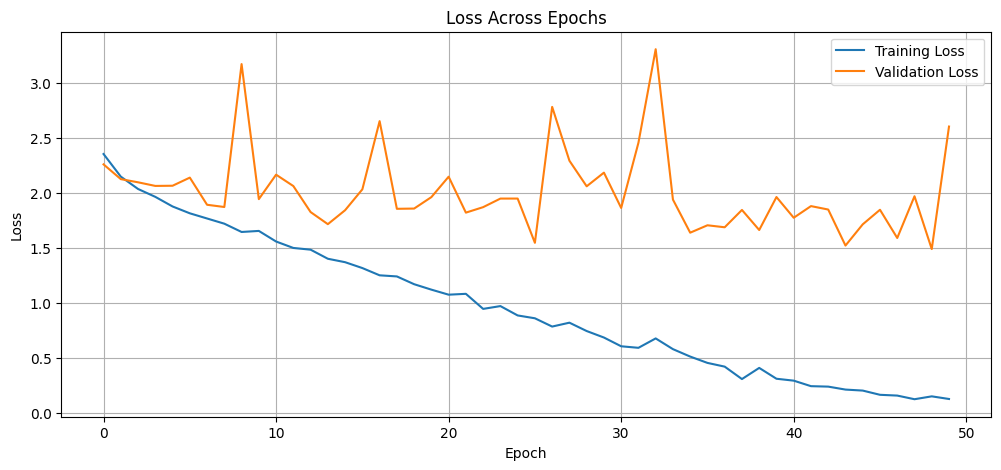

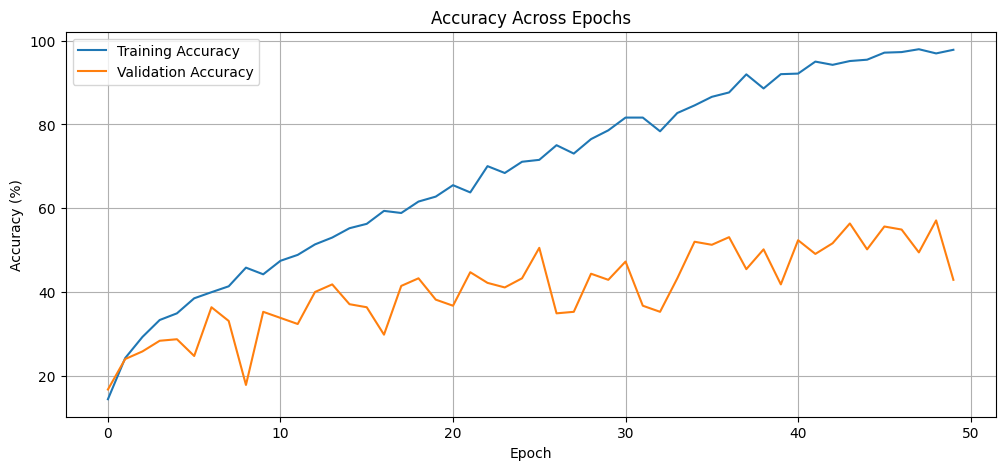

Test Accuracy: 36.00%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.67      0.16      0.26        25
   cheesecake       0.90      0.36      0.51        25
chicken_curry       0.50      0.12      0.19        25
 french_fries       0.54      0.52      0.53        25
   fried_rice       0.74      0.56      0.64        25
    hamburger       0.16      0.44      0.23        25
      hot_dog       0.25      0.20      0.22        25
    ice_cream       0.58      0.44      0.50        25
     omelette       0.36      0.32      0.34        25
        pizza       1.00      0.08      0.15        25
        sushi       0.25      0.76      0.37        25

     accuracy                           0.36       275
    macro avg       0.54      0.36      0.36       275
 weighted avg       0.54      0.36      0.36       275



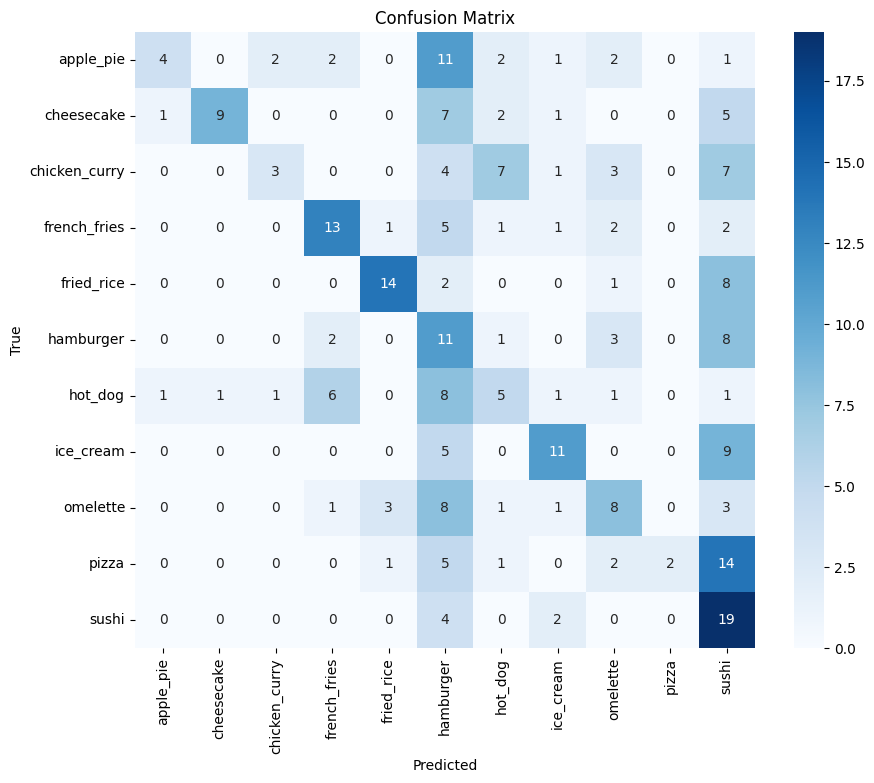

In [43]:
evaluate_and_plot(model9, train_losses9, val_losses9, train_accuracies9, val_accuracies9, test_loader, test_dataset, device9)


##CNN Models with resudual  with 64 batch sizes and 3 different learning rates



Model 10:

Training Hyperparameters:

>>Training Loss: 0.0558, Training Accuracy: 99.41%

>>Validation Loss: 2.2422, , Validation Accuracy: 46.18%

>>Test Accuracy: 43.27%

Optimizer Type: SGD.

Learning Rate (lr): 0.01



Number of Epochs: 50

Batch Size:64

Loss Function:CrossEntropy Loss for multi-class classification tasks.

In [44]:

model10 = CNNR(num_classes=num_classes)

criterion10 = nn.CrossEntropyLoss()

#model is on the CPU
device10 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model10.to(device10)


optimizer10 = torch.optim.SGD(
    model10.parameters(),
    lr=0.01,

    weight_decay=1e-4
)

train_losses10, val_losses10, train_accuracies10, val_accuracies10 = train_model(
    model=model10,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion10,
    optimizer=optimizer10,
    device=device10,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model10.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 2.9077, Training Accuracy: 13.50%


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


Validation Loss: 2.4189, Validation Accuracy: 11.64%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 2.2464, Training Accuracy: 18.82%


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


Validation Loss: 2.3359, Validation Accuracy: 17.09%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.50it/s]


Training Loss: 2.1136, Training Accuracy: 26.36%


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Validation Loss: 2.7397, Validation Accuracy: 10.91%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.58it/s]


Training Loss: 2.1090, Training Accuracy: 27.59%


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Validation Loss: 2.4589, Validation Accuracy: 15.64%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.79it/s]


Training Loss: 1.9835, Training Accuracy: 30.95%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 2.0965, Validation Accuracy: 24.00%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 1.9123, Training Accuracy: 34.91%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Validation Loss: 1.9944, Validation Accuracy: 30.91%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.8793, Training Accuracy: 36.14%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Validation Loss: 1.9721, Validation Accuracy: 28.73%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.7917, Training Accuracy: 37.86%


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


Validation Loss: 2.1128, Validation Accuracy: 26.18%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 1.7447, Training Accuracy: 41.64%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.9495, Validation Accuracy: 33.82%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 1.6753, Training Accuracy: 42.77%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 2.0399, Validation Accuracy: 34.18%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 1.6655, Training Accuracy: 43.45%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 1.9744, Validation Accuracy: 29.82%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.79it/s]


Training Loss: 1.5899, Training Accuracy: 46.55%


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Validation Loss: 2.2026, Validation Accuracy: 34.55%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 1.5510, Training Accuracy: 46.82%


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Validation Loss: 2.1025, Validation Accuracy: 33.82%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.4758, Training Accuracy: 49.45%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.8580, Validation Accuracy: 38.91%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 1.4174, Training Accuracy: 52.41%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 2.1098, Validation Accuracy: 34.55%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 1.3557, Training Accuracy: 54.59%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 2.3280, Validation Accuracy: 31.27%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 1.2976, Training Accuracy: 56.73%


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Validation Loss: 2.0326, Validation Accuracy: 32.73%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 1.2442, Training Accuracy: 58.68%


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Validation Loss: 2.0184, Validation Accuracy: 36.00%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 1.1699, Training Accuracy: 60.50%


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Validation Loss: 1.9611, Validation Accuracy: 37.45%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 1.1308, Training Accuracy: 61.77%


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Validation Loss: 2.2193, Validation Accuracy: 37.09%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 1.0823, Training Accuracy: 63.05%


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]


Validation Loss: 2.1845, Validation Accuracy: 37.45%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 0.9986, Training Accuracy: 67.05%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 2.1332, Validation Accuracy: 37.45%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 0.9095, Training Accuracy: 68.86%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 2.5341, Validation Accuracy: 34.91%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 0.8369, Training Accuracy: 71.55%


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Validation Loss: 2.6951, Validation Accuracy: 29.82%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 0.8374, Training Accuracy: 73.27%


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


Validation Loss: 2.1957, Validation Accuracy: 42.55%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.8025, Training Accuracy: 73.86%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 1.9746, Validation Accuracy: 37.09%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 0.7121, Training Accuracy: 76.59%


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


Validation Loss: 2.5856, Validation Accuracy: 32.36%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 0.5528, Training Accuracy: 83.91%


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Validation Loss: 2.1688, Validation Accuracy: 43.64%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.58it/s]


Training Loss: 0.5542, Training Accuracy: 82.82%


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Validation Loss: 2.3036, Validation Accuracy: 36.00%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.55it/s]


Training Loss: 0.4960, Training Accuracy: 84.82%


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Validation Loss: 2.1231, Validation Accuracy: 43.64%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.4320, Training Accuracy: 86.95%


100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


Validation Loss: 3.6463, Validation Accuracy: 26.91%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.4513, Training Accuracy: 87.50%


100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


Validation Loss: 3.3553, Validation Accuracy: 30.91%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.4073, Training Accuracy: 88.18%


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Validation Loss: 2.4726, Validation Accuracy: 39.64%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.3239, Training Accuracy: 91.23%


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Validation Loss: 2.1983, Validation Accuracy: 43.64%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.2344, Training Accuracy: 94.41%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 2.5157, Validation Accuracy: 39.64%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.52it/s]


Training Loss: 0.2049, Training Accuracy: 95.82%


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Validation Loss: 2.0410, Validation Accuracy: 45.09%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 0.1823, Training Accuracy: 95.32%


100%|██████████| 5/5 [00:01<00:00,  4.48it/s]


Validation Loss: 2.2833, Validation Accuracy: 44.73%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 0.1426, Training Accuracy: 97.27%


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Validation Loss: 2.0421, Validation Accuracy: 47.64%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.1087, Training Accuracy: 98.18%


100%|██████████| 5/5 [00:01<00:00,  4.87it/s]


Validation Loss: 2.0141, Validation Accuracy: 48.36%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.1070, Training Accuracy: 98.00%


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Validation Loss: 2.4096, Validation Accuracy: 44.73%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 0.1464, Training Accuracy: 96.82%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 2.1975, Validation Accuracy: 46.18%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.0772, Training Accuracy: 99.18%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 1.9897, Validation Accuracy: 49.09%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.0676, Training Accuracy: 99.23%


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Validation Loss: 2.3955, Validation Accuracy: 46.55%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 0.0570, Training Accuracy: 99.50%


100%|██████████| 5/5 [00:01<00:00,  4.55it/s]


Validation Loss: 2.6187, Validation Accuracy: 41.45%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.0633, Training Accuracy: 99.14%


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Validation Loss: 2.1856, Validation Accuracy: 48.36%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 0.0464, Training Accuracy: 99.64%


100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


Validation Loss: 2.1167, Validation Accuracy: 48.36%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 0.0392, Training Accuracy: 99.50%


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Validation Loss: 2.1378, Validation Accuracy: 51.27%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.0412, Training Accuracy: 99.45%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 2.5196, Validation Accuracy: 41.09%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.3520, Training Accuracy: 92.41%


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Validation Loss: 2.2643, Validation Accuracy: 44.00%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 0.0558, Training Accuracy: 99.41%


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

Validation Loss: 2.2422, Validation Accuracy: 46.18%


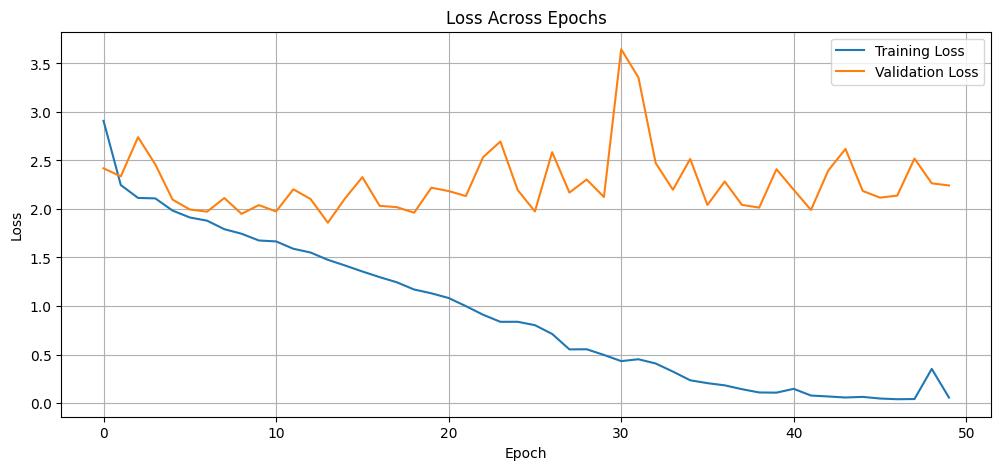

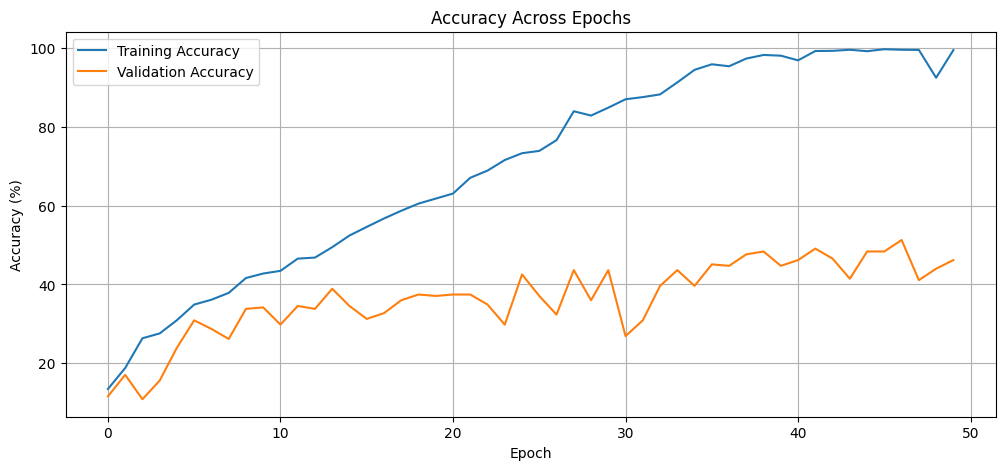

Test Accuracy: 43.27%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.60      0.12      0.20        25
   cheesecake       0.61      0.44      0.51        25
chicken_curry       0.32      0.56      0.41        25
 french_fries       0.42      0.56      0.48        25
   fried_rice       0.68      0.68      0.68        25
    hamburger       0.33      0.48      0.39        25
      hot_dog       0.29      0.20      0.24        25
    ice_cream       0.48      0.52      0.50        25
     omelette       0.20      0.20      0.20        25
        pizza       0.71      0.48      0.57        25
        sushi       0.46      0.52      0.49        25

     accuracy                           0.43       275
    macro avg       0.46      0.43      0.42       275
 weighted avg       0.46      0.43      0.42       275



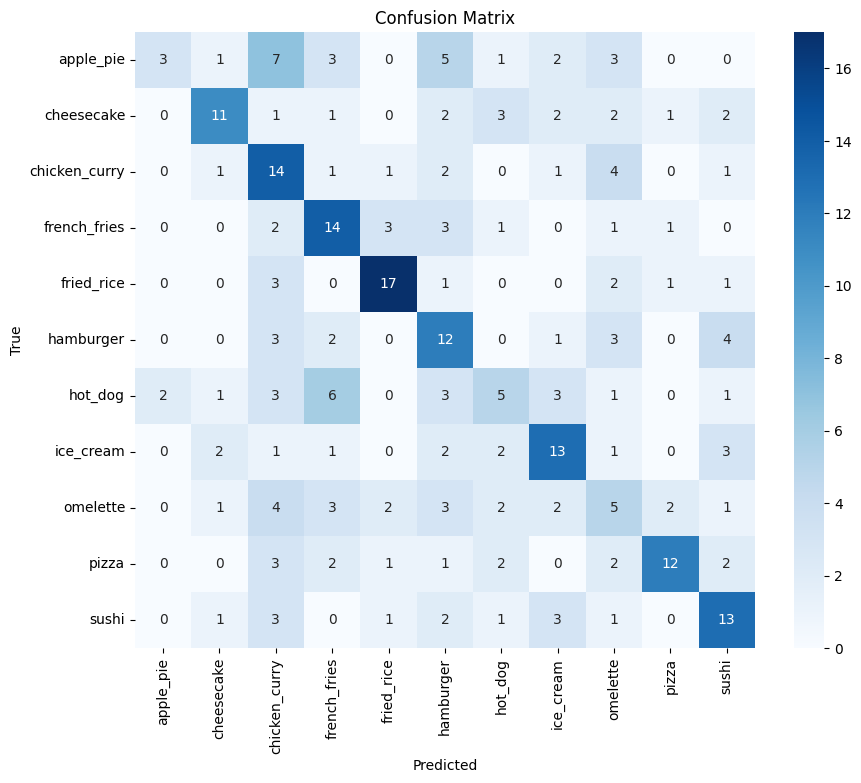

In [45]:
evaluate_and_plot(model10, train_losses10, val_losses10, train_accuracies10, val_accuracies10, test_loader, test_dataset, device10)


Model 11:

Validation Accuracy: 50.55%

Training Hyperparameters:

>>Training Loss:  0.1022, Training Accuracy: 98.86%

>>Validation Loss: 1.7752,  Validation Accuracy:50.55%

>>Test Accuracy: 40.73%

Optimizer Type: SGD.

Learning Rate (lr): 0.005



Number of Epochs: 50

Batch Size:64

Loss Function:CrossEntropy Loss for multi-class classification tasks.

In [46]:

model11 = CNNR(num_classes=num_classes)

criterion11 = nn.CrossEntropyLoss()

#model is on the CPU
device11 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model11.to(device11)

optimizer11 = torch.optim.SGD(
    model11.parameters(),
    lr=0.005,

    weight_decay=1e-4
)

train_losses11, val_losses11, train_accuracies11, val_accuracies11 = train_model(
    model=model11,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion11,
    optimizer=optimizer11,
    device=device11,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model11.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 2.7801, Training Accuracy: 14.73%


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Validation Loss: 2.3045, Validation Accuracy: 16.36%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 2.2160, Training Accuracy: 21.77%


100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Validation Loss: 2.1464, Validation Accuracy: 24.73%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 2.1149, Training Accuracy: 26.55%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 2.2097, Validation Accuracy: 20.36%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 2.0248, Training Accuracy: 29.82%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 2.0208, Validation Accuracy: 28.00%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 1.9456, Training Accuracy: 33.18%


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


Validation Loss: 2.0895, Validation Accuracy: 28.36%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 1.8889, Training Accuracy: 35.14%


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Validation Loss: 2.1401, Validation Accuracy: 22.18%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.52it/s]


Training Loss: 1.8410, Training Accuracy: 38.05%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 1.9063, Validation Accuracy: 32.73%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.7602, Training Accuracy: 40.59%


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Validation Loss: 1.8609, Validation Accuracy: 35.64%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 1.6946, Training Accuracy: 43.05%


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Validation Loss: 1.9705, Validation Accuracy: 31.27%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.58it/s]


Training Loss: 1.6863, Training Accuracy: 43.50%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 1.9257, Validation Accuracy: 30.55%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.6258, Training Accuracy: 45.77%


100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


Validation Loss: 1.9332, Validation Accuracy: 32.73%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 1.5878, Training Accuracy: 46.50%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 1.9065, Validation Accuracy: 32.73%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.5104, Training Accuracy: 50.23%


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


Validation Loss: 2.1500, Validation Accuracy: 27.27%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.53it/s]


Training Loss: 1.4968, Training Accuracy: 48.91%


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Validation Loss: 2.2443, Validation Accuracy: 30.55%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 1.4303, Training Accuracy: 51.50%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 1.9820, Validation Accuracy: 34.55%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 1.3801, Training Accuracy: 53.05%


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Validation Loss: 2.3677, Validation Accuracy: 30.18%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 1.3022, Training Accuracy: 56.73%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.9499, Validation Accuracy: 34.18%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 1.2441, Training Accuracy: 57.77%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Validation Loss: 2.0058, Validation Accuracy: 38.18%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.2257, Training Accuracy: 57.82%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.9626, Validation Accuracy: 35.27%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 1.1921, Training Accuracy: 61.68%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 1.7036, Validation Accuracy: 43.27%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 1.0936, Training Accuracy: 64.45%


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Validation Loss: 2.0827, Validation Accuracy: 37.82%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 1.1179, Training Accuracy: 63.27%


100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


Validation Loss: 1.9193, Validation Accuracy: 40.00%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 1.0099, Training Accuracy: 67.36%


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Validation Loss: 1.7773, Validation Accuracy: 41.82%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.9258, Training Accuracy: 69.91%


100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


Validation Loss: 1.7217, Validation Accuracy: 46.55%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.55it/s]


Training Loss: 0.9213, Training Accuracy: 71.18%


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Validation Loss: 1.8805, Validation Accuracy: 38.18%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 0.8590, Training Accuracy: 72.18%


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Validation Loss: 2.2219, Validation Accuracy: 35.27%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 0.8404, Training Accuracy: 73.68%


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Validation Loss: 1.8677, Validation Accuracy: 40.36%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.8076, Training Accuracy: 75.32%


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Validation Loss: 1.8378, Validation Accuracy: 44.00%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 0.7089, Training Accuracy: 77.18%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 2.1536, Validation Accuracy: 36.36%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.7298, Training Accuracy: 77.32%


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Validation Loss: 1.8205, Validation Accuracy: 46.91%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 0.6209, Training Accuracy: 81.32%


100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


Validation Loss: 1.8247, Validation Accuracy: 43.64%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 0.5556, Training Accuracy: 84.32%


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Validation Loss: 2.8199, Validation Accuracy: 30.55%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.5519, Training Accuracy: 83.82%


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Validation Loss: 1.7391, Validation Accuracy: 42.91%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.4712, Training Accuracy: 87.73%


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


Validation Loss: 2.0052, Validation Accuracy: 45.45%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.4228, Training Accuracy: 89.00%


100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


Validation Loss: 1.9194, Validation Accuracy: 42.18%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.4192, Training Accuracy: 88.59%


100%|██████████| 5/5 [00:01<00:00,  4.59it/s]


Validation Loss: 2.4556, Validation Accuracy: 30.18%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.3694, Training Accuracy: 90.73%


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Validation Loss: 2.4424, Validation Accuracy: 36.36%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 0.3422, Training Accuracy: 90.82%


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Validation Loss: 2.1963, Validation Accuracy: 41.82%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 0.3069, Training Accuracy: 92.64%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 1.7768, Validation Accuracy: 44.00%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.44it/s]


Training Loss: 0.2346, Training Accuracy: 95.45%


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Validation Loss: 2.0789, Validation Accuracy: 43.64%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 0.2380, Training Accuracy: 95.27%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 1.8734, Validation Accuracy: 48.73%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.55it/s]


Training Loss: 0.1843, Training Accuracy: 97.64%


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Validation Loss: 3.0856, Validation Accuracy: 33.09%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 0.3781, Training Accuracy: 92.14%


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


Validation Loss: 2.0963, Validation Accuracy: 42.18%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 0.1758, Training Accuracy: 97.64%


100%|██████████| 5/5 [00:01<00:00,  4.41it/s]


Validation Loss: 2.0250, Validation Accuracy: 44.00%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 0.1490, Training Accuracy: 97.55%


100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Validation Loss: 1.8728, Validation Accuracy: 46.91%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 0.1335, Training Accuracy: 98.27%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 1.8823, Validation Accuracy: 47.27%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 0.1994, Training Accuracy: 96.23%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 2.0649, Validation Accuracy: 45.82%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 0.1381, Training Accuracy: 98.05%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 1.8873, Validation Accuracy: 49.09%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 0.1040, Training Accuracy: 99.14%


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Validation Loss: 1.7883, Validation Accuracy: 50.91%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 0.1022, Training Accuracy: 98.86%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]

Validation Loss: 1.7752, Validation Accuracy: 50.55%


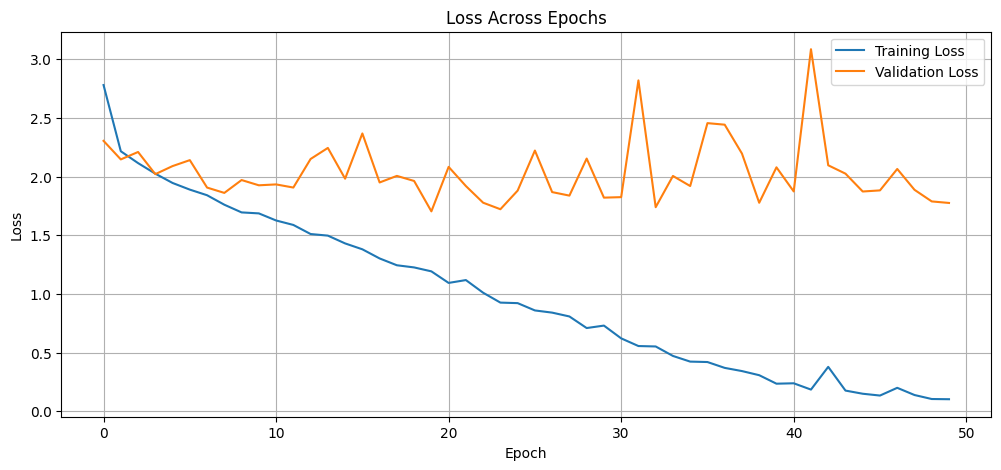

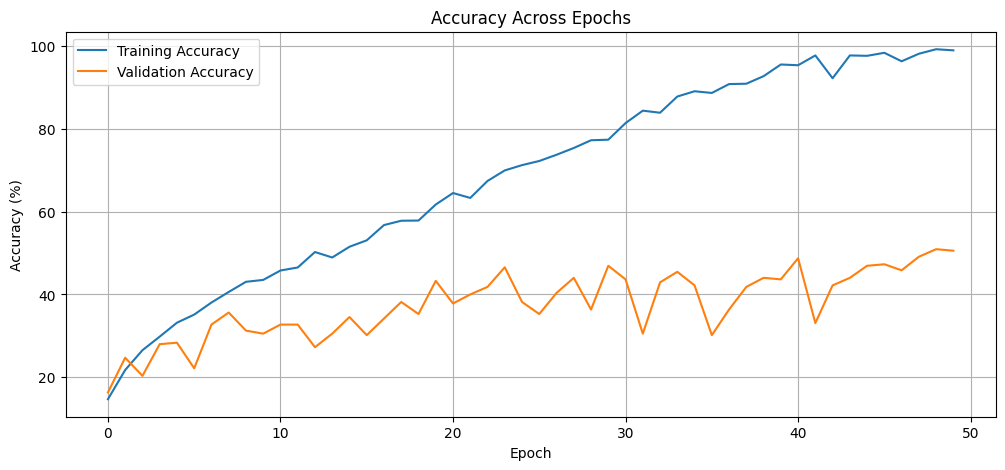

Test Accuracy: 40.73%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.32      0.28      0.30        25
   cheesecake       0.53      0.64      0.58        25
chicken_curry       0.44      0.32      0.37        25
 french_fries       0.52      0.48      0.50        25
   fried_rice       0.56      0.36      0.44        25
    hamburger       0.23      0.36      0.28        25
      hot_dog       0.21      0.16      0.18        25
    ice_cream       0.53      0.36      0.43        25
     omelette       0.35      0.28      0.31        25
        pizza       0.44      0.68      0.53        25
        sushi       0.45      0.56      0.50        25

     accuracy                           0.41       275
    macro avg       0.42      0.41      0.40       275
 weighted avg       0.42      0.41      0.40       275



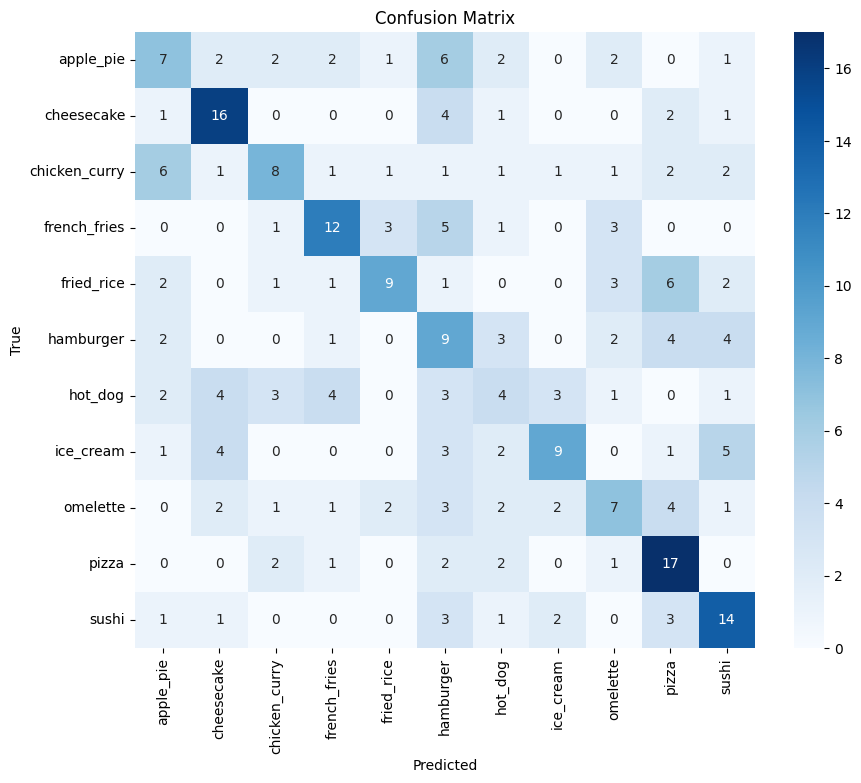

In [47]:
evaluate_and_plot(model11, train_losses11, val_losses11, train_accuracies11, val_accuracies11, test_loader, test_dataset, device11)


Model 12:


Training Hyperparameters:

>>Training Loss: 0.7231, Training Accuracy:  80.23%

>>Validation Loss: 1.6938,  Validation Accuracy: 42.55%

>>Test Accuracy: 42.55%

Optimizer Type: SGD.

Learning Rate (lr): 0.001



Number of Epochs: 50

Batch Size:64

Loss Function:CrossEntropy Loss for multi-class classification tasks.

In [48]:

model12 = CNNR(num_classes=num_classes)

criterion12 = nn.CrossEntropyLoss()

#model is on the CPU
device12 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model12.to(device12) # Move model to the correct device before calling summary



optimizer12 = torch.optim.SGD(
    model12.parameters(),
    lr=0.001,

    weight_decay=1e-4
)

train_losses12, val_losses12, train_accuracies12, val_accuracies12 = train_model(
    model=model12,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion12,
    optimizer=optimizer12,
    device=device12,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_model12.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 2.3542, Training Accuracy: 14.32%


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Validation Loss: 2.2929, Validation Accuracy: 20.00%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 2.2060, Training Accuracy: 22.77%


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Validation Loss: 2.2269, Validation Accuracy: 16.73%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 2.0955, Training Accuracy: 27.09%


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Validation Loss: 2.1896, Validation Accuracy: 21.82%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.59it/s]


Training Loss: 2.0277, Training Accuracy: 29.82%


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Validation Loss: 2.0451, Validation Accuracy: 26.91%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.9603, Training Accuracy: 32.55%


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Validation Loss: 2.0236, Validation Accuracy: 26.18%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 1.9093, Training Accuracy: 34.68%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 1.9877, Validation Accuracy: 31.27%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 1.8317, Training Accuracy: 38.91%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 2.1371, Validation Accuracy: 24.36%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 1.7991, Training Accuracy: 40.18%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 2.0875, Validation Accuracy: 25.09%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 1.7549, Training Accuracy: 42.05%


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


Validation Loss: 1.8977, Validation Accuracy: 37.09%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 1.7117, Training Accuracy: 43.18%


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Validation Loss: 1.9562, Validation Accuracy: 35.64%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.55it/s]


Training Loss: 1.6909, Training Accuracy: 43.32%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 1.9520, Validation Accuracy: 30.18%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.6526, Training Accuracy: 44.27%


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Validation Loss: 1.8263, Validation Accuracy: 37.45%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 1.5881, Training Accuracy: 47.18%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 1.7714, Validation Accuracy: 40.00%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.51it/s]


Training Loss: 1.5540, Training Accuracy: 48.91%


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Validation Loss: 1.8956, Validation Accuracy: 33.09%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.5491, Training Accuracy: 50.00%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 1.8527, Validation Accuracy: 36.00%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 1.4927, Training Accuracy: 51.27%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 1.8503, Validation Accuracy: 38.55%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 1.4942, Training Accuracy: 51.50%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 2.0068, Validation Accuracy: 34.55%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 1.4533, Training Accuracy: 51.64%


100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


Validation Loss: 1.8260, Validation Accuracy: 36.00%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.4116, Training Accuracy: 53.41%


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Validation Loss: 1.7932, Validation Accuracy: 37.45%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 1.3884, Training Accuracy: 54.05%


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Validation Loss: 1.8173, Validation Accuracy: 39.64%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 1.3555, Training Accuracy: 56.64%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 1.8184, Validation Accuracy: 36.00%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 1.3308, Training Accuracy: 56.00%


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Validation Loss: 1.7440, Validation Accuracy: 35.64%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 1.3240, Training Accuracy: 57.27%


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Validation Loss: 1.9555, Validation Accuracy: 33.82%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 1.2792, Training Accuracy: 58.41%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 1.7707, Validation Accuracy: 39.64%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 1.2719, Training Accuracy: 58.41%


100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


Validation Loss: 1.7823, Validation Accuracy: 37.09%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 1.2055, Training Accuracy: 61.91%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 1.7616, Validation Accuracy: 36.36%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 1.1702, Training Accuracy: 64.45%


100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


Validation Loss: 1.7721, Validation Accuracy: 40.00%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 1.1872, Training Accuracy: 63.59%


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]


Validation Loss: 1.7619, Validation Accuracy: 40.73%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 1.1529, Training Accuracy: 64.36%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.7776, Validation Accuracy: 42.55%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.51it/s]


Training Loss: 1.1510, Training Accuracy: 64.73%


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Validation Loss: 1.6482, Validation Accuracy: 44.00%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 1.0898, Training Accuracy: 66.36%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 1.7545, Validation Accuracy: 36.73%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 1.0919, Training Accuracy: 67.32%


100%|██████████| 5/5 [00:01<00:00,  4.71it/s]


Validation Loss: 2.6866, Validation Accuracy: 17.09%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.55it/s]


Training Loss: 1.0899, Training Accuracy: 67.91%


100%|██████████| 5/5 [00:01<00:00,  4.98it/s]


Validation Loss: 1.7731, Validation Accuracy: 37.82%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 0.9921, Training Accuracy: 70.77%


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Validation Loss: 1.7127, Validation Accuracy: 44.00%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.0097, Training Accuracy: 70.50%


100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


Validation Loss: 1.6582, Validation Accuracy: 41.82%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.9679, Training Accuracy: 70.91%


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Validation Loss: 2.0095, Validation Accuracy: 28.36%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 1.0163, Training Accuracy: 69.45%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 1.7372, Validation Accuracy: 39.27%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 0.9434, Training Accuracy: 71.91%


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


Validation Loss: 1.9789, Validation Accuracy: 34.91%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.9118, Training Accuracy: 74.59%


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Validation Loss: 1.7763, Validation Accuracy: 41.45%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.9017, Training Accuracy: 73.68%


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Validation Loss: 1.9026, Validation Accuracy: 37.82%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 0.8909, Training Accuracy: 74.09%


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Validation Loss: 1.6842, Validation Accuracy: 42.55%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 0.8813, Training Accuracy: 74.32%


100%|██████████| 5/5 [00:01<00:00,  4.63it/s]


Validation Loss: 1.8356, Validation Accuracy: 38.55%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 0.8275, Training Accuracy: 77.86%


100%|██████████| 5/5 [00:01<00:00,  4.50it/s]


Validation Loss: 1.7284, Validation Accuracy: 41.45%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.8043, Training Accuracy: 78.41%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 1.7297, Validation Accuracy: 41.82%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.8002, Training Accuracy: 78.14%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 1.6108, Validation Accuracy: 45.09%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.7735, Training Accuracy: 79.18%


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Validation Loss: 1.7646, Validation Accuracy: 44.73%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.59it/s]


Training Loss: 0.7401, Training Accuracy: 80.64%


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Validation Loss: 1.6641, Validation Accuracy: 44.36%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 0.7139, Training Accuracy: 81.59%


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Validation Loss: 1.6684, Validation Accuracy: 43.27%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.7150, Training Accuracy: 80.68%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 1.5972, Validation Accuracy: 44.00%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 0.7231, Training Accuracy: 80.23%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]

Validation Loss: 1.6938, Validation Accuracy: 42.55%


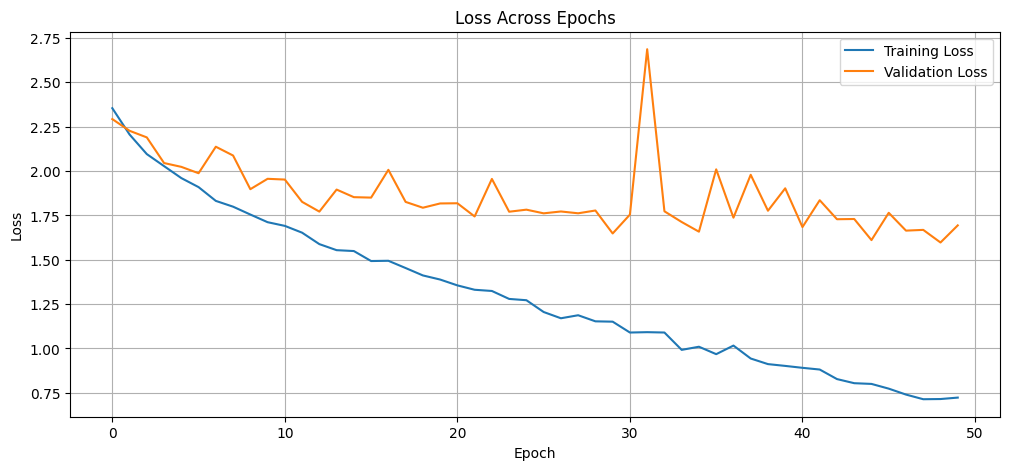

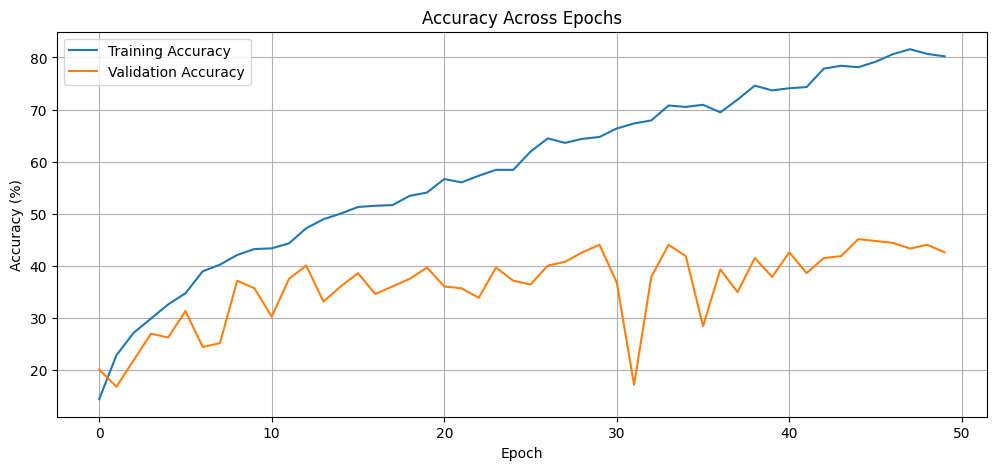

Test Accuracy: 42.55%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.33      0.32      0.33        25
   cheesecake       0.71      0.40      0.51        25
chicken_curry       0.38      0.48      0.42        25
 french_fries       0.33      0.68      0.45        25
   fried_rice       0.49      0.72      0.58        25
    hamburger       0.38      0.56      0.45        25
      hot_dog       0.22      0.08      0.12        25
    ice_cream       0.47      0.32      0.38        25
     omelette       0.60      0.12      0.20        25
        pizza       0.54      0.76      0.63        25
        sushi       0.43      0.24      0.31        25

     accuracy                           0.43       275
    macro avg       0.44      0.43      0.40       275
 weighted avg       0.44      0.43      0.40       275



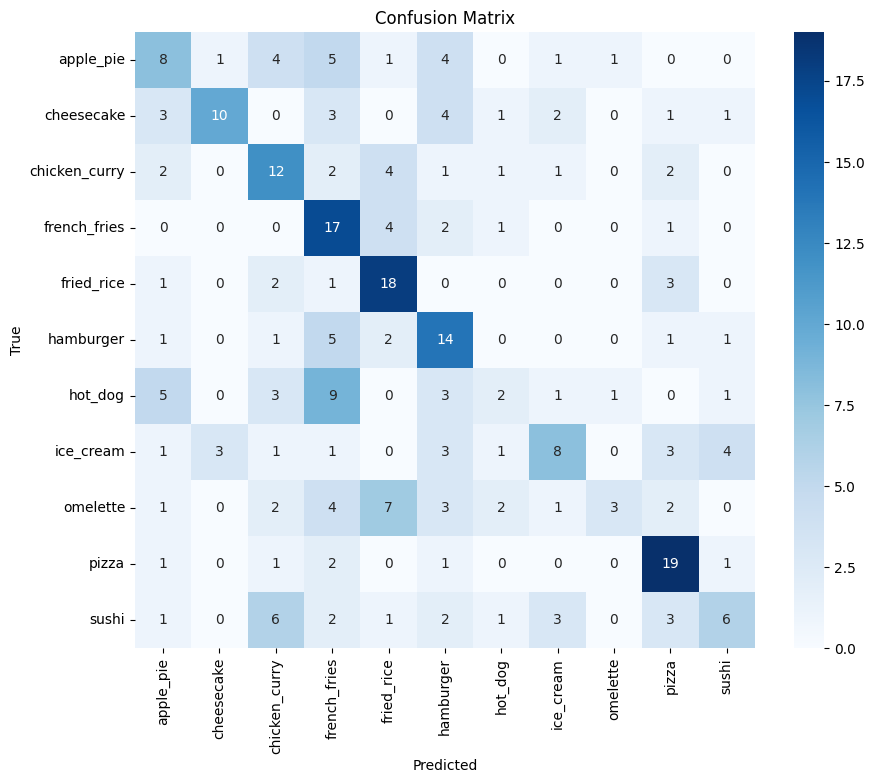

In [49]:
evaluate_and_plot(model12, train_losses12, val_losses12, train_accuracies12, val_accuracies12, test_loader, test_dataset, device12)


################################################################################

MODELS WITH DROPOUTS

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNRD(nn.Module):

    def __init__(self, num_classes=10, dropout=0.5):
        super(CNNRD, self).__init__()

        # 1. Convolutional Layer + ReLU + Max Pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2. Convolutional Layer + ReLU + Max Pooling
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3. Convolutional Layer + ReLU
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.res_conv2to3 = nn.Conv2d(64, 128, kernel_size=1)

        # 4. Convolutional Layer + ReLU + Max Pooling
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5. Convolutional Layer + ReLU + Max Pooling
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 16 * 16, 2048)
        self.dropout1 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        residual = self.res_conv2to3(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = x + residual

        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNND(nn.Module):
    def __init__(self, num_classes=10, dropout=0.3):
        super(CNND, self).__init__()

        # 1. Conv Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2. Conv Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3. Conv Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4. Conv Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 5. Conv Block
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512 * 8 * 8, 512)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


The Best Model with none residual model 2:

Model 2:

Training Hyperparameters:

>>Training Loss: 0.3547, Training Accuracy: 89.86%

>>Validation Loss: 2.2086, Validation Accuracy:45.45%

>>Test Accuracy: 38.18%


Optimizer Type: SGD.

Learning Rate (lr): 0.01



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

dropout : 0.3


In [55]:


modeld1 = CNND(num_classes=num_classes, dropout=0.3)

criteriond1 = nn.CrossEntropyLoss()

#model is on the CPU
deviced1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modeld1.to(deviced1)



optimizerd1 = torch.optim.SGD(
    modeld1.parameters(),
    lr=0.01,

    weight_decay=1e-4
)

train_lossesd1, val_lossesd1, train_accuraciesd1, val_accuraciesd1 = train_model(
    model=modeld1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criteriond1,
    optimizer=optimizerd1,
    device=deviced1,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_modeld1.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 2.4188, Training Accuracy: 13.41%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 2.3068, Validation Accuracy: 12.73%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 2.2216, Training Accuracy: 20.86%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 2.2504, Validation Accuracy: 21.09%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 2.1219, Training Accuracy: 24.09%


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Validation Loss: 2.1342, Validation Accuracy: 22.55%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 2.0422, Training Accuracy: 28.82%


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


Validation Loss: 2.2543, Validation Accuracy: 22.55%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Training Loss: 1.9782, Training Accuracy: 31.32%


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Validation Loss: 2.1070, Validation Accuracy: 24.36%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 1.9103, Training Accuracy: 33.68%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.8361, Validation Accuracy: 42.55%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 1.8780, Training Accuracy: 37.00%


100%|██████████| 5/5 [00:00<00:00,  5.11it/s]


Validation Loss: 1.8826, Validation Accuracy: 33.45%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 1.7974, Training Accuracy: 37.50%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 2.1216, Validation Accuracy: 29.82%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


Training Loss: 1.7548, Training Accuracy: 40.00%


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 1.8443, Validation Accuracy: 35.64%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 1.7305, Training Accuracy: 41.41%


100%|██████████| 5/5 [00:00<00:00,  5.26it/s]


Validation Loss: 1.8038, Validation Accuracy: 35.27%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.6963, Training Accuracy: 41.73%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 1.8417, Validation Accuracy: 35.27%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 1.6722, Training Accuracy: 43.77%


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Validation Loss: 1.7854, Validation Accuracy: 43.64%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Training Loss: 1.5973, Training Accuracy: 46.91%


100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation Loss: 1.7986, Validation Accuracy: 39.64%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 1.5695, Training Accuracy: 47.36%


100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Validation Loss: 1.7390, Validation Accuracy: 40.36%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 1.5496, Training Accuracy: 47.64%


100%|██████████| 5/5 [00:00<00:00,  5.09it/s]


Validation Loss: 1.9109, Validation Accuracy: 37.09%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 1.4980, Training Accuracy: 48.18%


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Validation Loss: 1.7243, Validation Accuracy: 41.45%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 1.4284, Training Accuracy: 52.27%


100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


Validation Loss: 1.9505, Validation Accuracy: 39.64%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.3957, Training Accuracy: 53.59%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 1.6969, Validation Accuracy: 44.36%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 1.3858, Training Accuracy: 53.23%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 1.7871, Validation Accuracy: 42.18%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 1.3529, Training Accuracy: 55.64%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 1.9552, Validation Accuracy: 36.73%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 1.3293, Training Accuracy: 56.05%


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Validation Loss: 2.2489, Validation Accuracy: 32.73%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.2672, Training Accuracy: 57.27%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 1.7225, Validation Accuracy: 44.00%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.2328, Training Accuracy: 59.09%


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Validation Loss: 2.5563, Validation Accuracy: 32.36%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 1.2115, Training Accuracy: 60.27%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 1.7749, Validation Accuracy: 42.91%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 1.1478, Training Accuracy: 61.86%


100%|██████████| 5/5 [00:00<00:00,  5.14it/s]


Validation Loss: 1.6466, Validation Accuracy: 48.36%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 1.1200, Training Accuracy: 61.95%


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Validation Loss: 1.9767, Validation Accuracy: 36.73%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.0979, Training Accuracy: 62.68%


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Validation Loss: 1.7901, Validation Accuracy: 41.82%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 1.0525, Training Accuracy: 64.59%


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Validation Loss: 1.5559, Validation Accuracy: 46.91%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 1.0246, Training Accuracy: 66.95%


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Validation Loss: 2.4120, Validation Accuracy: 34.91%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 1.0022, Training Accuracy: 65.91%


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 2.6228, Validation Accuracy: 29.82%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.9529, Training Accuracy: 69.68%


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Validation Loss: 1.7106, Validation Accuracy: 43.27%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 0.8986, Training Accuracy: 69.45%


100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


Validation Loss: 2.5610, Validation Accuracy: 29.45%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.8713, Training Accuracy: 71.18%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 1.8793, Validation Accuracy: 45.45%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 0.8599, Training Accuracy: 71.27%


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Validation Loss: 2.0997, Validation Accuracy: 41.45%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.8191, Training Accuracy: 72.32%


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Validation Loss: 2.2496, Validation Accuracy: 41.09%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.7711, Training Accuracy: 75.14%


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]


Validation Loss: 1.5016, Validation Accuracy: 54.91%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  5.00it/s]


Training Loss: 0.7220, Training Accuracy: 76.59%


100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Validation Loss: 1.6306, Validation Accuracy: 47.64%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 0.7055, Training Accuracy: 76.50%


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 1.9946, Validation Accuracy: 48.00%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.6882, Training Accuracy: 77.64%


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Validation Loss: 1.7494, Validation Accuracy: 44.36%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 0.6211, Training Accuracy: 80.41%


100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


Validation Loss: 1.6704, Validation Accuracy: 49.45%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 0.6398, Training Accuracy: 78.91%


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


Validation Loss: 1.5641, Validation Accuracy: 51.27%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 0.5586, Training Accuracy: 82.14%


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Validation Loss: 1.5364, Validation Accuracy: 48.73%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 0.5612, Training Accuracy: 82.18%


100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


Validation Loss: 2.2238, Validation Accuracy: 45.45%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.5450, Training Accuracy: 81.41%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 1.6425, Validation Accuracy: 49.45%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 0.5067, Training Accuracy: 84.73%


100%|██████████| 5/5 [00:00<00:00,  5.12it/s]


Validation Loss: 2.4613, Validation Accuracy: 38.18%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.4621, Training Accuracy: 85.14%


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 2.1545, Validation Accuracy: 47.27%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 0.4657, Training Accuracy: 84.55%


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


Validation Loss: 2.0592, Validation Accuracy: 45.45%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.99it/s]


Training Loss: 0.4186, Training Accuracy: 86.82%


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Validation Loss: 2.6914, Validation Accuracy: 38.18%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 0.4204, Training Accuracy: 87.73%


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


Validation Loss: 1.6879, Validation Accuracy: 49.45%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 0.3547, Training Accuracy: 89.86%


100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

Validation Loss: 2.2086, Validation Accuracy: 45.45%


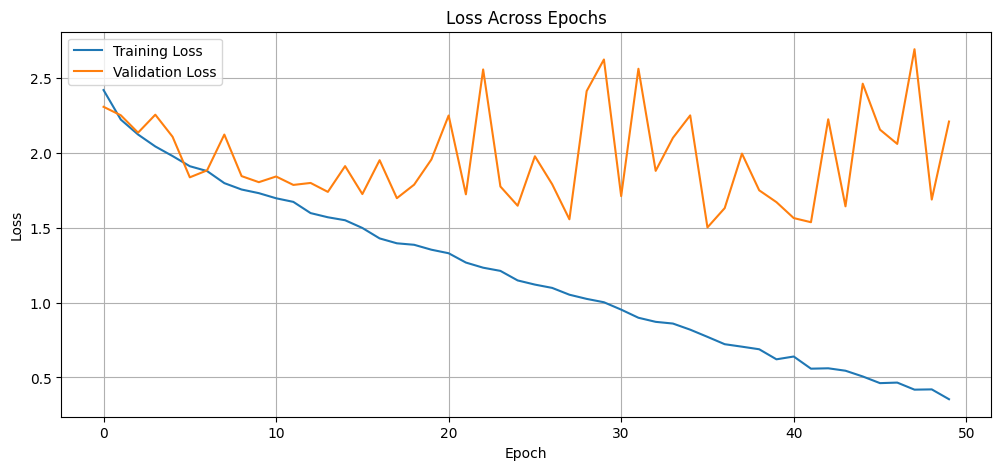

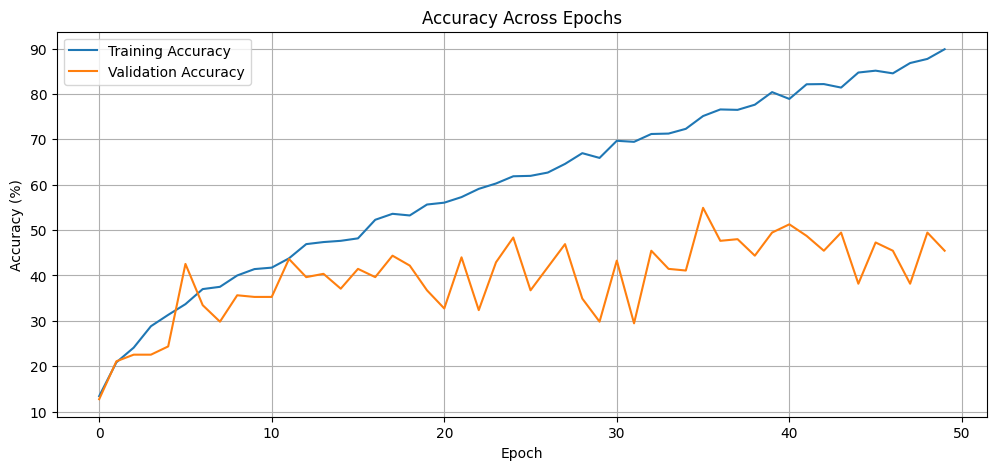

Test Accuracy: 38.18%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.45      0.20      0.28        25
   cheesecake       0.55      0.44      0.49        25
chicken_curry       0.44      0.32      0.37        25
 french_fries       0.38      0.72      0.50        25
   fried_rice       1.00      0.28      0.44        25
    hamburger       0.38      0.32      0.35        25
      hot_dog       0.18      0.44      0.25        25
    ice_cream       0.40      0.40      0.40        25
     omelette       0.00      0.00      0.00        25
        pizza       0.49      0.68      0.57        25
        sushi       0.48      0.40      0.43        25

     accuracy                           0.38       275
    macro avg       0.43      0.38      0.37       275
 weighted avg       0.43      0.38      0.37       275



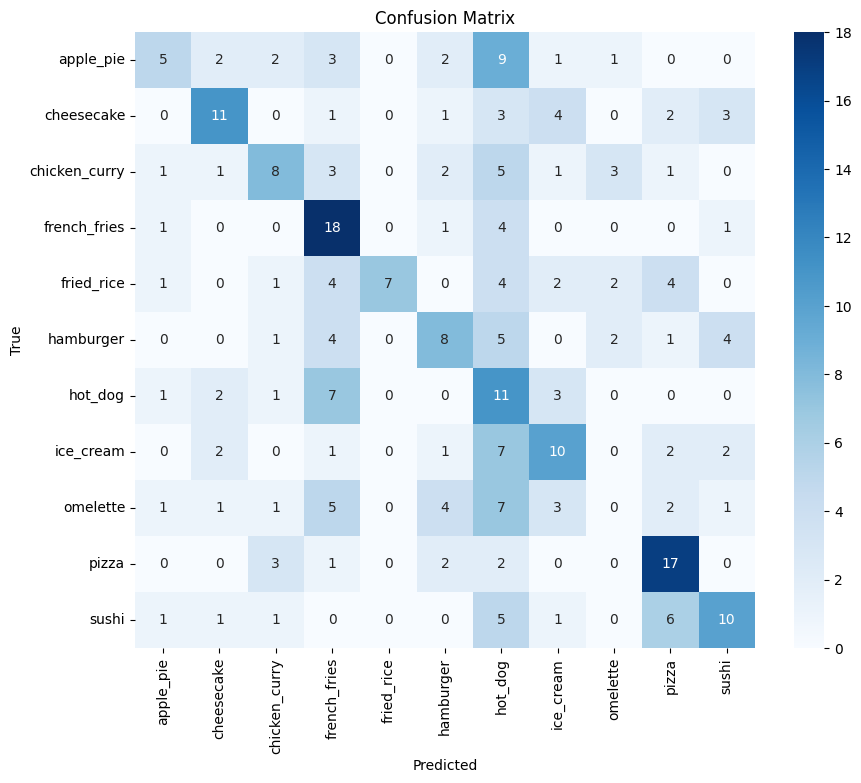

In [56]:
evaluate_and_plot(modeld1, train_lossesd1, val_lossesd1, train_accuraciesd1, val_accuraciesd1, test_loader, test_dataset, deviced1)


The Best Model with none residual model 2:

Model 2:

Training Hyperparameters:

>>Training Loss: 0.7109, Training Accuracy: 76.68%

>>Validation Loss: 1.6003,  Validation Accuracy: 53.09%

>>Test Accuracy: 45.82%


Optimizer Type: SGD.

Learning Rate (lr): 0.01



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

dropout : 0.5


In [57]:


modeld2 = CNND(num_classes=num_classes, dropout=0.5)

criteriond2 = nn.CrossEntropyLoss()

#model is on the CPU
deviced2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modeld2.to(deviced2)



optimizerd2 = torch.optim.SGD(
    modeld2.parameters(),
    lr=0.01,

    weight_decay=1e-4
)

train_lossesd2, val_lossesd2, train_accuraciesd2, val_accuraciesd2 = train_model(
    model=modeld2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criteriond2,
    optimizer=optimizerd2,
    device=deviced2,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_modeld2.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.79it/s]


Training Loss: 2.4881, Training Accuracy: 13.14%


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Loss: 2.3429, Validation Accuracy: 13.09%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 2.2675, Training Accuracy: 18.18%


100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Validation Loss: 2.2162, Validation Accuracy: 20.36%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 2.1792, Training Accuracy: 22.09%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 2.2345, Validation Accuracy: 16.73%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.97it/s]


Training Loss: 2.1038, Training Accuracy: 25.91%


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


Validation Loss: 2.1122, Validation Accuracy: 22.55%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 2.0480, Training Accuracy: 28.68%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 2.0259, Validation Accuracy: 26.91%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 1.9897, Training Accuracy: 30.23%


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Loss: 1.9974, Validation Accuracy: 30.55%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 1.9666, Training Accuracy: 31.23%


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Validation Loss: 1.9815, Validation Accuracy: 32.00%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 1.9187, Training Accuracy: 34.14%


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


Validation Loss: 1.9745, Validation Accuracy: 30.18%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 1.8813, Training Accuracy: 35.27%


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Validation Loss: 1.9814, Validation Accuracy: 34.18%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 1.8488, Training Accuracy: 37.68%


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Validation Loss: 1.8304, Validation Accuracy: 34.18%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.00it/s]


Training Loss: 1.8169, Training Accuracy: 38.00%


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


Validation Loss: 1.9057, Validation Accuracy: 33.82%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 1.7829, Training Accuracy: 39.55%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 1.7874, Validation Accuracy: 38.55%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 1.7627, Training Accuracy: 39.73%


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 1.9036, Validation Accuracy: 33.82%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 1.7441, Training Accuracy: 40.32%


100%|██████████| 5/5 [00:00<00:00,  5.42it/s]


Validation Loss: 1.7735, Validation Accuracy: 39.27%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.85it/s]


Training Loss: 1.7067, Training Accuracy: 41.55%


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 2.1120, Validation Accuracy: 32.00%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 1.6772, Training Accuracy: 43.73%


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Validation Loss: 1.7178, Validation Accuracy: 41.82%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 1.6650, Training Accuracy: 43.82%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 1.7625, Validation Accuracy: 40.36%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.6033, Training Accuracy: 45.95%


100%|██████████| 5/5 [00:00<00:00,  5.39it/s]


Validation Loss: 1.7657, Validation Accuracy: 36.00%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:06<00:00,  5.01it/s]


Training Loss: 1.5896, Training Accuracy: 46.82%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 1.9174, Validation Accuracy: 37.82%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 1.5583, Training Accuracy: 46.50%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 1.7396, Validation Accuracy: 46.55%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 1.5320, Training Accuracy: 48.91%


100%|██████████| 5/5 [00:00<00:00,  5.30it/s]


Validation Loss: 1.7204, Validation Accuracy: 41.82%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 1.4868, Training Accuracy: 49.95%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 1.8628, Validation Accuracy: 39.27%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


Training Loss: 1.4839, Training Accuracy: 49.82%


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Validation Loss: 1.6221, Validation Accuracy: 45.82%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.88it/s]


Training Loss: 1.4425, Training Accuracy: 51.59%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.5838, Validation Accuracy: 46.55%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 1.4398, Training Accuracy: 51.05%


100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation Loss: 1.5610, Validation Accuracy: 47.64%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.79it/s]


Training Loss: 1.3713, Training Accuracy: 54.50%


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Validation Loss: 1.5768, Validation Accuracy: 46.55%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 1.3499, Training Accuracy: 53.77%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 2.0242, Validation Accuracy: 32.00%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 1.3239, Training Accuracy: 56.64%


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Validation Loss: 2.2817, Validation Accuracy: 34.18%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 1.3303, Training Accuracy: 54.50%


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Validation Loss: 1.8161, Validation Accuracy: 40.36%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 1.2360, Training Accuracy: 59.36%


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Validation Loss: 1.8622, Validation Accuracy: 38.91%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 1.2276, Training Accuracy: 58.82%


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Validation Loss: 1.8445, Validation Accuracy: 45.09%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 1.2188, Training Accuracy: 59.68%


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


Validation Loss: 1.6268, Validation Accuracy: 45.82%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 1.1805, Training Accuracy: 60.64%


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


Validation Loss: 1.7779, Validation Accuracy: 47.27%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.93it/s]


Training Loss: 1.1663, Training Accuracy: 61.36%


100%|██████████| 5/5 [00:00<00:00,  5.23it/s]


Validation Loss: 1.8223, Validation Accuracy: 46.18%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 1.1279, Training Accuracy: 62.00%


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 2.0557, Validation Accuracy: 36.00%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.86it/s]


Training Loss: 1.1220, Training Accuracy: 62.36%


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Loss: 2.1134, Validation Accuracy: 41.45%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.98it/s]


Training Loss: 1.0794, Training Accuracy: 64.41%


100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


Validation Loss: 1.6997, Validation Accuracy: 40.36%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 0.9912, Training Accuracy: 67.64%


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Validation Loss: 2.4222, Validation Accuracy: 31.27%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.90it/s]


Training Loss: 0.9888, Training Accuracy: 66.64%


100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Validation Loss: 1.4514, Validation Accuracy: 52.00%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 0.9586, Training Accuracy: 67.64%


100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Validation Loss: 1.4602, Validation Accuracy: 53.45%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.82it/s]


Training Loss: 0.9311, Training Accuracy: 69.05%


100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Validation Loss: 1.4086, Validation Accuracy: 52.00%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 0.9384, Training Accuracy: 67.00%


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Validation Loss: 1.6762, Validation Accuracy: 50.18%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.95it/s]


Training Loss: 0.9226, Training Accuracy: 68.18%


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Validation Loss: 1.8864, Validation Accuracy: 44.00%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.8937, Training Accuracy: 70.95%


100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Validation Loss: 1.6748, Validation Accuracy: 54.18%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.91it/s]


Training Loss: 0.9167, Training Accuracy: 70.14%


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Validation Loss: 1.7064, Validation Accuracy: 45.45%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.94it/s]


Training Loss: 0.8309, Training Accuracy: 71.45%


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Validation Loss: 1.4887, Validation Accuracy: 52.00%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.83it/s]


Training Loss: 0.8036, Training Accuracy: 73.59%


100%|██████████| 5/5 [00:00<00:00,  5.37it/s]


Validation Loss: 1.6991, Validation Accuracy: 48.00%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.87it/s]


Training Loss: 0.7998, Training Accuracy: 72.95%


100%|██████████| 5/5 [00:00<00:00,  5.32it/s]


Validation Loss: 2.7244, Validation Accuracy: 35.64%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.96it/s]


Training Loss: 0.8324, Training Accuracy: 72.36%


100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


Validation Loss: 1.5831, Validation Accuracy: 46.55%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.7109, Training Accuracy: 76.68%


100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

Validation Loss: 1.6003, Validation Accuracy: 53.09%


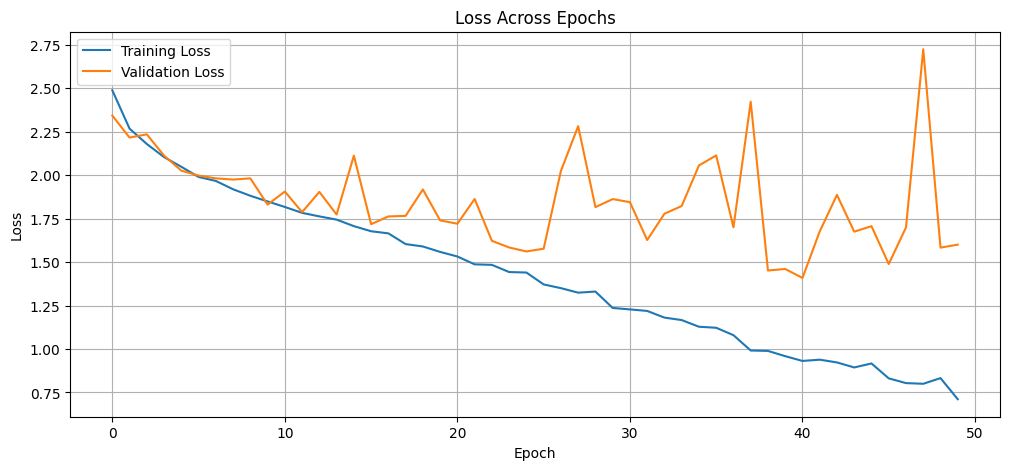

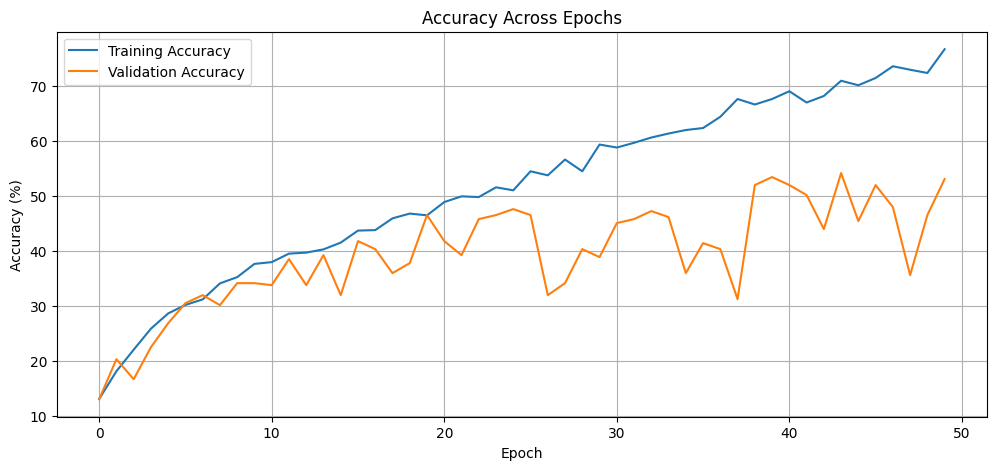

Test Accuracy: 45.82%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.77      0.40      0.53        25
   cheesecake       0.68      0.60      0.64        25
chicken_curry       0.38      0.48      0.42        25
 french_fries       0.52      0.64      0.57        25
   fried_rice       0.43      0.80      0.56        25
    hamburger       0.39      0.28      0.33        25
      hot_dog       0.60      0.12      0.20        25
    ice_cream       0.42      0.32      0.36        25
     omelette       0.62      0.20      0.30        25
        pizza       0.65      0.44      0.52        25
        sushi       0.30      0.76      0.43        25

     accuracy                           0.46       275
    macro avg       0.52      0.46      0.44       275
 weighted avg       0.52      0.46      0.44       275



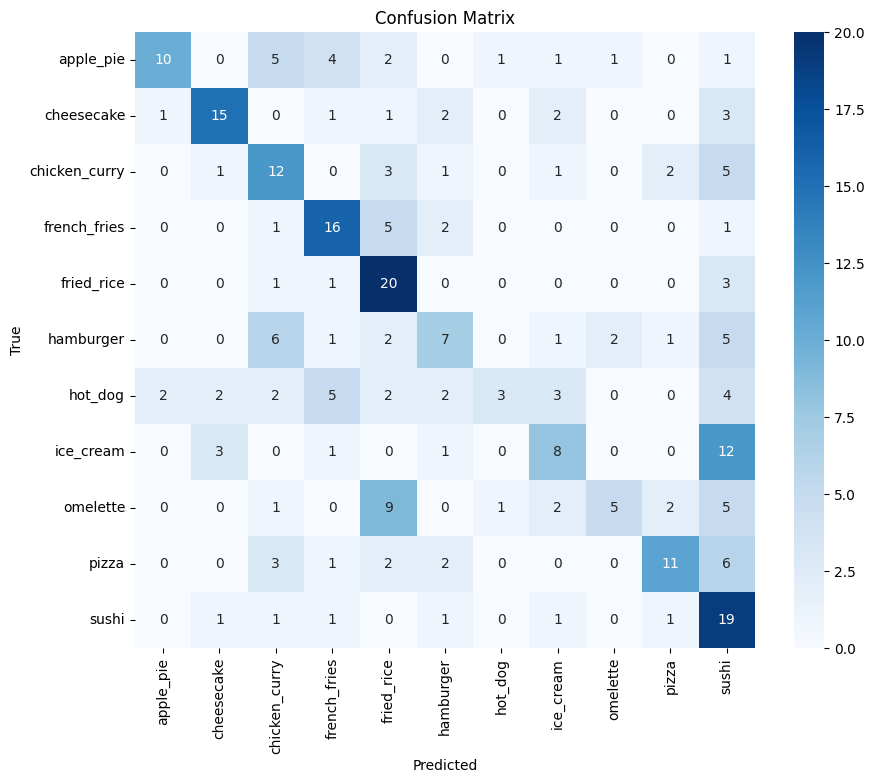

In [58]:
evaluate_and_plot(modeld2, train_lossesd2, val_lossesd2, train_accuraciesd2, val_accuraciesd2, test_loader, test_dataset, deviced2)


The Best Model with  residual model5

Model 5:

Training Hyperparameters:

>>Training Loss:0.1559, Training Accuracy: 97.18%

>>Validation Loss:  1.7111,   Validation Accuracy:49.09%

>>Test Accuracy: 43.64%

Optimizer Type: SGD.

Learning Rate (lr): 0.005



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

dropout: 0.3

In [61]:

modelrd1 = CNNRD(num_classes=num_classes, dropout=0.3)

criterionrd1 = nn.CrossEntropyLoss()

#model is on the CPU
devicerd1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelrd1.to(devicerd1) # Move model to the correct device before calling summary



optimizerrd1 = torch.optim.SGD(
    modelrd1.parameters(),
    lr=0.005,

    weight_decay=1e-4
)

train_lossesrd1, val_lossesrd1, train_accuraciesrd1, val_accuraciesrd1 = train_model(
    model=modelrd1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterionrd1,
    optimizer=optimizerrd1,
    device=devicerd1,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_modelrd1.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.64it/s]


Training Loss: 2.5022, Training Accuracy: 13.64%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 2.3037, Validation Accuracy: 14.91%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 2.2108, Training Accuracy: 21.77%


100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


Validation Loss: 2.2180, Validation Accuracy: 22.91%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.47it/s]


Training Loss: 2.1177, Training Accuracy: 25.14%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 2.1227, Validation Accuracy: 21.09%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 2.0256, Training Accuracy: 29.95%


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Validation Loss: 1.9784, Validation Accuracy: 29.09%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 1.9653, Training Accuracy: 31.77%


100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


Validation Loss: 2.2022, Validation Accuracy: 19.27%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 1.8978, Training Accuracy: 34.64%


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Validation Loss: 2.1130, Validation Accuracy: 28.73%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.8548, Training Accuracy: 36.59%


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Validation Loss: 1.8580, Validation Accuracy: 37.45%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.75it/s]


Training Loss: 1.7623, Training Accuracy: 40.64%


100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


Validation Loss: 1.9182, Validation Accuracy: 34.55%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 1.7245, Training Accuracy: 41.64%


100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Validation Loss: 2.1755, Validation Accuracy: 30.55%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 1.7121, Training Accuracy: 41.55%


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Validation Loss: 1.8546, Validation Accuracy: 39.27%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 1.6264, Training Accuracy: 44.64%


100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


Validation Loss: 1.9655, Validation Accuracy: 31.27%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.81it/s]


Training Loss: 1.6061, Training Accuracy: 45.09%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 2.3666, Validation Accuracy: 26.18%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 1.5649, Training Accuracy: 45.86%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Validation Loss: 1.9715, Validation Accuracy: 33.45%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.5232, Training Accuracy: 48.50%


100%|██████████| 5/5 [00:01<00:00,  4.52it/s]


Validation Loss: 1.9717, Validation Accuracy: 32.73%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 1.4686, Training Accuracy: 50.32%


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Validation Loss: 1.6973, Validation Accuracy: 40.00%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 1.4185, Training Accuracy: 51.32%


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Validation Loss: 2.0459, Validation Accuracy: 38.55%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 1.3875, Training Accuracy: 55.00%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 2.0266, Validation Accuracy: 37.09%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 1.3057, Training Accuracy: 56.36%


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Validation Loss: 2.2108, Validation Accuracy: 35.64%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.2576, Training Accuracy: 58.50%


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


Validation Loss: 2.3639, Validation Accuracy: 29.09%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.3015, Training Accuracy: 58.00%


100%|██████████| 5/5 [00:01<00:00,  4.91it/s]


Validation Loss: 2.2904, Validation Accuracy: 30.91%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.2127, Training Accuracy: 60.73%


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Validation Loss: 1.8016, Validation Accuracy: 37.82%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.1095, Training Accuracy: 63.05%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 2.0172, Validation Accuracy: 35.64%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 1.1134, Training Accuracy: 63.91%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 2.2118, Validation Accuracy: 32.73%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.84it/s]


Training Loss: 1.0805, Training Accuracy: 63.91%


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Validation Loss: 1.8172, Validation Accuracy: 44.36%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.9976, Training Accuracy: 66.50%


100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


Validation Loss: 1.9845, Validation Accuracy: 39.27%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 0.9531, Training Accuracy: 68.27%


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Validation Loss: 1.9990, Validation Accuracy: 42.55%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 0.9169, Training Accuracy: 69.95%


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Validation Loss: 1.6692, Validation Accuracy: 40.73%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.8725, Training Accuracy: 70.27%


100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


Validation Loss: 1.9908, Validation Accuracy: 36.36%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 0.8596, Training Accuracy: 72.64%


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Validation Loss: 2.0573, Validation Accuracy: 36.36%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.8013, Training Accuracy: 74.86%


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Validation Loss: 1.7517, Validation Accuracy: 46.55%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.7097, Training Accuracy: 77.82%


100%|██████████| 5/5 [00:01<00:00,  4.96it/s]


Validation Loss: 2.3299, Validation Accuracy: 36.73%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 0.6894, Training Accuracy: 78.14%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 2.1150, Validation Accuracy: 39.64%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 0.6282, Training Accuracy: 80.59%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 2.0332, Validation Accuracy: 36.73%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.6354, Training Accuracy: 80.91%


100%|██████████| 5/5 [00:01<00:00,  4.59it/s]


Validation Loss: 2.0734, Validation Accuracy: 39.64%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 0.5619, Training Accuracy: 83.27%


100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Validation Loss: 2.4834, Validation Accuracy: 35.27%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 0.5015, Training Accuracy: 85.50%


100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Validation Loss: 2.3752, Validation Accuracy: 38.18%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 0.5580, Training Accuracy: 84.64%


100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


Validation Loss: 2.1445, Validation Accuracy: 40.00%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.4358, Training Accuracy: 88.50%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 2.5667, Validation Accuracy: 35.64%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 0.4294, Training Accuracy: 88.23%


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Validation Loss: 1.9065, Validation Accuracy: 39.27%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.73it/s]


Training Loss: 0.3982, Training Accuracy: 88.91%


100%|██████████| 5/5 [00:01<00:00,  4.59it/s]


Validation Loss: 2.2940, Validation Accuracy: 41.45%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 0.3558, Training Accuracy: 91.09%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 1.8161, Validation Accuracy: 45.45%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 0.3313, Training Accuracy: 91.27%


100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Validation Loss: 1.6619, Validation Accuracy: 46.91%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 0.3001, Training Accuracy: 92.05%


100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


Validation Loss: 1.8722, Validation Accuracy: 43.27%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 0.2675, Training Accuracy: 93.82%


100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Validation Loss: 1.7447, Validation Accuracy: 47.27%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.53it/s]


Training Loss: 0.2606, Training Accuracy: 93.50%


100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Validation Loss: 1.6096, Validation Accuracy: 50.18%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.50it/s]


Training Loss: 0.2342, Training Accuracy: 94.73%


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Validation Loss: 1.6433, Validation Accuracy: 51.64%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 0.2082, Training Accuracy: 95.23%


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


Validation Loss: 2.0193, Validation Accuracy: 44.73%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 0.1898, Training Accuracy: 95.95%


100%|██████████| 5/5 [00:01<00:00,  4.92it/s]


Validation Loss: 3.1871, Validation Accuracy: 30.55%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.58it/s]


Training Loss: 0.2278, Training Accuracy: 94.55%


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Validation Loss: 1.7988, Validation Accuracy: 45.45%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 0.1559, Training Accuracy: 97.18%


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]

Validation Loss: 1.7111, Validation Accuracy: 49.09%


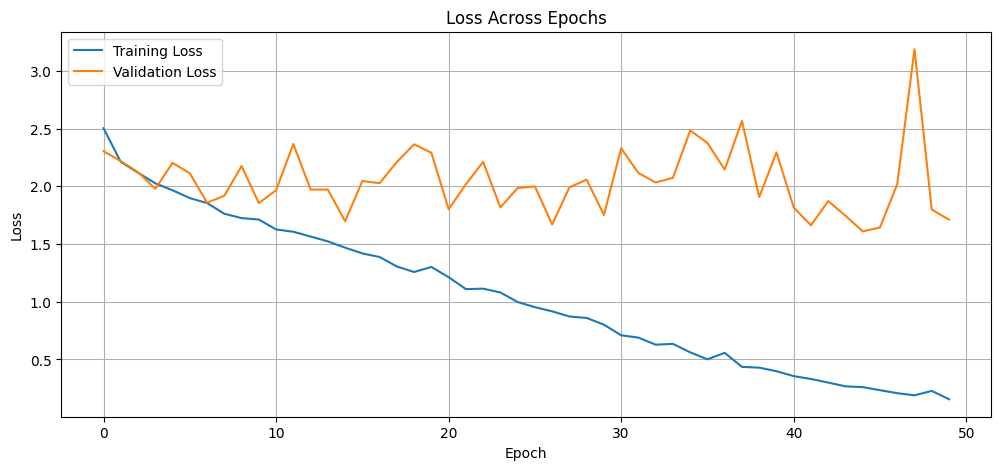

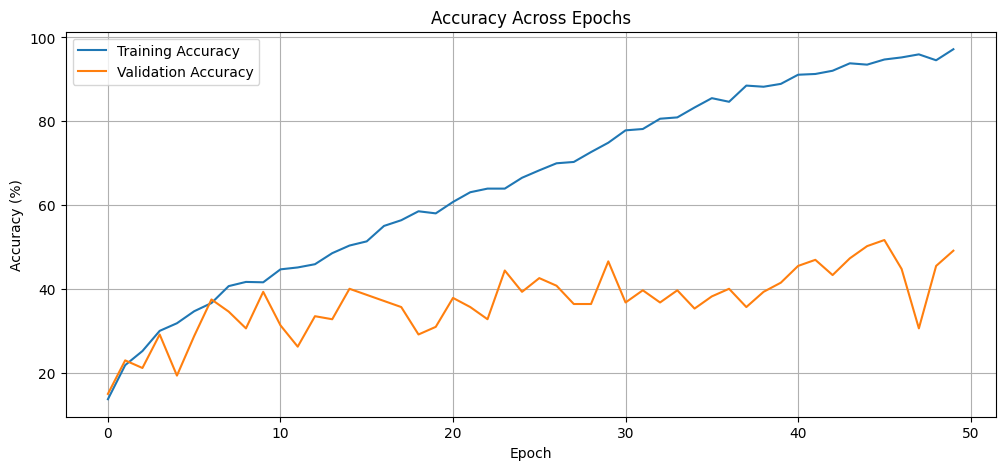

Test Accuracy: 43.64%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.28      0.52      0.37        25
   cheesecake       0.50      0.52      0.51        25
chicken_curry       0.57      0.48      0.52        25
 french_fries       0.48      0.48      0.48        25
   fried_rice       0.56      0.60      0.58        25
    hamburger       0.35      0.44      0.39        25
      hot_dog       0.20      0.16      0.18        25
    ice_cream       0.54      0.60      0.57        25
     omelette       0.36      0.16      0.22        25
        pizza       0.77      0.40      0.53        25
        sushi       0.41      0.44      0.42        25

     accuracy                           0.44       275
    macro avg       0.46      0.44      0.43       275
 weighted avg       0.46      0.44      0.43       275



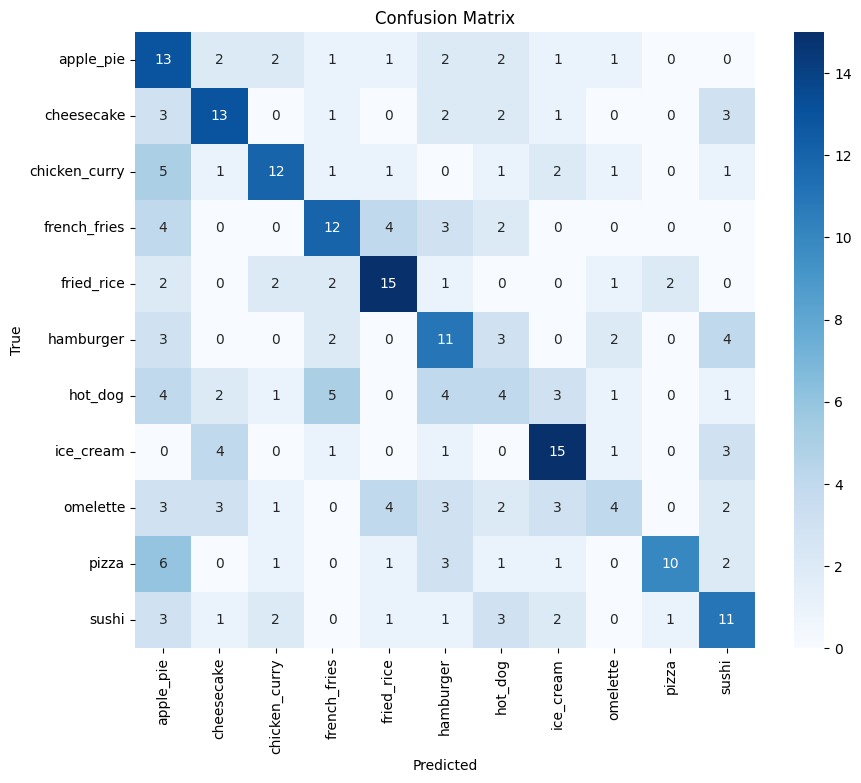

In [62]:
evaluate_and_plot(modelrd1, train_lossesrd1, val_lossesrd1, train_accuraciesrd1, val_accuraciesrd1, test_loader, test_dataset, devicerd1)


The Best Model with  residual model5

Model 5:

Training Hyperparameters:

>>Training Loss:  0.5242, Training Accuracy:83.64%

>>Validation Loss:1.9648,  Validation Accuracy:43.27%

>>Test Accuracy: 37.45%

Optimizer Type: SGD.

Learning Rate (lr): 0.005



Number of Epochs: 50

Batch Size:32

Loss Function:CrossEntropyLoss for multi-class classification tasks.

dropout: 0.5

In [63]:

modelrd2 = CNNRD(num_classes=num_classes, dropout=0.5)

criterionrd2 = nn.CrossEntropyLoss()

#model is on the CPU
devicerd2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelrd2.to(devicerd2)

optimizerrd2 = torch.optim.SGD(
    modelrd2.parameters(),
    lr=0.005,

    weight_decay=1e-4
)

train_lossesrd2, val_lossesrd2, train_accuraciesrd2, val_accuraciesrd2 = train_model(
    model=modelrd2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterionrd2,
    optimizer=optimizerrd2,
    device=devicerd2,
    num_epochs=50,
    save_path='/content/drive/MyDrive/CNN_modelrd2.pth'
)

<ipython-input-16-1d96d0d0bb5c>:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # optional for faster training on GPU


Epoch 1/50
------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-16-1d96d0d0bb5c>:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # automatic mixed precision
100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 2.8496, Training Accuracy: 11.82%


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Validation Loss: 2.3415, Validation Accuracy: 16.73%
Epoch 2/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Training Loss: 2.2920, Training Accuracy: 17.36%


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]


Validation Loss: 2.2461, Validation Accuracy: 21.45%
Epoch 3/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 2.2197, Training Accuracy: 22.23%


100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


Validation Loss: 2.1768, Validation Accuracy: 23.64%
Epoch 4/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.61it/s]


Training Loss: 2.1401, Training Accuracy: 24.77%


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Validation Loss: 2.0643, Validation Accuracy: 31.27%
Epoch 5/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 2.0852, Training Accuracy: 27.68%


100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


Validation Loss: 1.9874, Validation Accuracy: 28.73%
Epoch 6/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.59it/s]


Training Loss: 2.0285, Training Accuracy: 29.27%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 2.0486, Validation Accuracy: 29.09%
Epoch 7/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 1.9374, Training Accuracy: 34.27%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Validation Loss: 1.9503, Validation Accuracy: 31.27%
Epoch 8/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.9340, Training Accuracy: 33.00%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 2.1425, Validation Accuracy: 24.73%
Epoch 9/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.8881, Training Accuracy: 35.36%


100%|██████████| 5/5 [00:00<00:00,  5.10it/s]


Validation Loss: 1.9167, Validation Accuracy: 30.91%
Epoch 10/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 1.8253, Training Accuracy: 36.73%


100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


Validation Loss: 1.8523, Validation Accuracy: 35.64%
Epoch 11/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.78it/s]


Training Loss: 1.8076, Training Accuracy: 38.27%


100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


Validation Loss: 1.9892, Validation Accuracy: 33.09%
Epoch 12/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.67it/s]


Training Loss: 1.7629, Training Accuracy: 40.64%


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Validation Loss: 1.7601, Validation Accuracy: 41.09%
Epoch 13/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 1.7541, Training Accuracy: 39.23%


100%|██████████| 5/5 [00:01<00:00,  4.69it/s]


Validation Loss: 2.0165, Validation Accuracy: 32.73%
Epoch 14/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 1.7051, Training Accuracy: 41.68%


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Validation Loss: 1.9106, Validation Accuracy: 36.00%
Epoch 15/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.66it/s]


Training Loss: 1.6718, Training Accuracy: 43.73%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 1.9366, Validation Accuracy: 34.91%
Epoch 16/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.59it/s]


Training Loss: 1.5951, Training Accuracy: 45.41%


100%|██████████| 5/5 [00:01<00:00,  4.65it/s]


Validation Loss: 2.0370, Validation Accuracy: 32.73%
Epoch 17/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.65it/s]


Training Loss: 1.5966, Training Accuracy: 45.77%


100%|██████████| 5/5 [00:01<00:00,  4.72it/s]


Validation Loss: 1.9447, Validation Accuracy: 30.91%
Epoch 18/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.6155, Training Accuracy: 45.05%


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Validation Loss: 1.9104, Validation Accuracy: 37.09%
Epoch 19/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.55it/s]


Training Loss: 1.5258, Training Accuracy: 48.32%


100%|██████████| 5/5 [00:01<00:00,  4.94it/s]


Validation Loss: 1.8144, Validation Accuracy: 42.18%
Epoch 20/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.5070, Training Accuracy: 49.41%


100%|██████████| 5/5 [00:01<00:00,  4.85it/s]


Validation Loss: 1.8144, Validation Accuracy: 34.91%
Epoch 21/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.4515, Training Accuracy: 51.14%


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Validation Loss: 1.9141, Validation Accuracy: 37.82%
Epoch 22/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Training Loss: 1.4391, Training Accuracy: 51.32%


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Validation Loss: 1.8059, Validation Accuracy: 36.36%
Epoch 23/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.70it/s]


Training Loss: 1.3798, Training Accuracy: 54.41%


100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Validation Loss: 1.6898, Validation Accuracy: 45.09%
Epoch 24/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.3688, Training Accuracy: 54.86%


100%|██████████| 5/5 [00:01<00:00,  4.55it/s]


Validation Loss: 1.7343, Validation Accuracy: 44.00%
Epoch 25/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 1.3260, Training Accuracy: 55.59%


100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


Validation Loss: 1.8083, Validation Accuracy: 37.82%
Epoch 26/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.54it/s]


Training Loss: 1.2945, Training Accuracy: 56.50%


100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Validation Loss: 1.7822, Validation Accuracy: 44.36%
Epoch 27/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.68it/s]


Training Loss: 1.2807, Training Accuracy: 57.36%


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Validation Loss: 1.8627, Validation Accuracy: 46.55%
Epoch 28/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.2187, Training Accuracy: 59.23%


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Validation Loss: 1.9872, Validation Accuracy: 39.64%
Epoch 29/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.58it/s]


Training Loss: 1.1694, Training Accuracy: 61.50%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 1.7659, Validation Accuracy: 41.45%
Epoch 30/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.60it/s]


Training Loss: 1.1561, Training Accuracy: 61.36%


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


Validation Loss: 1.8710, Validation Accuracy: 39.27%
Epoch 31/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 1.1046, Training Accuracy: 63.50%


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Validation Loss: 2.1404, Validation Accuracy: 35.27%
Epoch 32/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.50it/s]


Training Loss: 1.0908, Training Accuracy: 64.09%


100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


Validation Loss: 1.6657, Validation Accuracy: 52.00%
Epoch 33/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 1.0608, Training Accuracy: 64.95%


100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Validation Loss: 1.8504, Validation Accuracy: 44.73%
Epoch 34/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.9896, Training Accuracy: 68.05%


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Validation Loss: 1.7908, Validation Accuracy: 44.00%
Epoch 35/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.9754, Training Accuracy: 68.05%


100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Validation Loss: 1.9023, Validation Accuracy: 36.73%
Epoch 36/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 0.9547, Training Accuracy: 67.95%


100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Validation Loss: 1.6458, Validation Accuracy: 45.09%
Epoch 37/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.77it/s]


Training Loss: 0.8677, Training Accuracy: 71.95%


100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


Validation Loss: 2.1539, Validation Accuracy: 38.55%
Epoch 38/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.8714, Training Accuracy: 70.55%


100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


Validation Loss: 2.3529, Validation Accuracy: 34.91%
Epoch 39/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.56it/s]


Training Loss: 0.8252, Training Accuracy: 73.36%


100%|██████████| 5/5 [00:01<00:00,  4.47it/s]


Validation Loss: 1.6615, Validation Accuracy: 49.09%
Epoch 40/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.63it/s]


Training Loss: 0.8168, Training Accuracy: 73.27%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 1.7455, Validation Accuracy: 47.64%
Epoch 41/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.7753, Training Accuracy: 75.05%


100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


Validation Loss: 2.0930, Validation Accuracy: 38.91%
Epoch 42/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.7081, Training Accuracy: 77.27%


100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Validation Loss: 1.9955, Validation Accuracy: 39.64%
Epoch 43/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.57it/s]


Training Loss: 0.7272, Training Accuracy: 76.14%


100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Validation Loss: 1.8114, Validation Accuracy: 44.36%
Epoch 44/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.80it/s]


Training Loss: 0.7116, Training Accuracy: 76.86%


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Validation Loss: 2.2966, Validation Accuracy: 38.55%
Epoch 45/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.6737, Training Accuracy: 78.95%


100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Validation Loss: 2.0822, Validation Accuracy: 38.18%
Epoch 46/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.59it/s]


Training Loss: 0.5967, Training Accuracy: 80.77%


100%|██████████| 5/5 [00:01<00:00,  4.51it/s]


Validation Loss: 1.6713, Validation Accuracy: 46.18%
Epoch 47/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Training Loss: 0.5586, Training Accuracy: 83.00%


100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


Validation Loss: 2.0725, Validation Accuracy: 38.91%
Epoch 48/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Training Loss: 0.5575, Training Accuracy: 81.50%


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


Validation Loss: 1.7884, Validation Accuracy: 44.73%
Epoch 49/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.62it/s]


Training Loss: 0.5501, Training Accuracy: 82.32%


100%|██████████| 5/5 [00:00<00:00,  5.06it/s]


Validation Loss: 1.9176, Validation Accuracy: 44.73%
Epoch 50/50
------------------------------


100%|██████████| 35/35 [00:07<00:00,  4.72it/s]


Training Loss: 0.5242, Training Accuracy: 83.64%


100%|██████████| 5/5 [00:01<00:00,  4.54it/s]

Validation Loss: 1.9648, Validation Accuracy: 43.27%


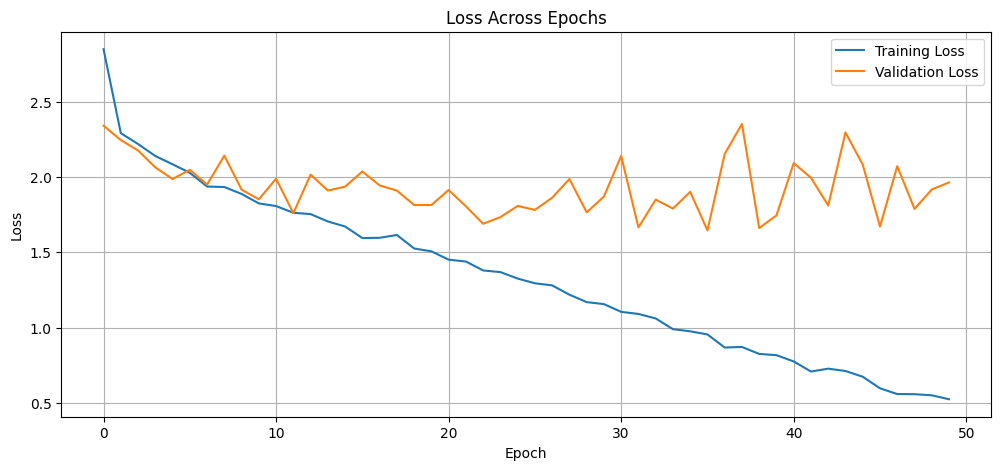

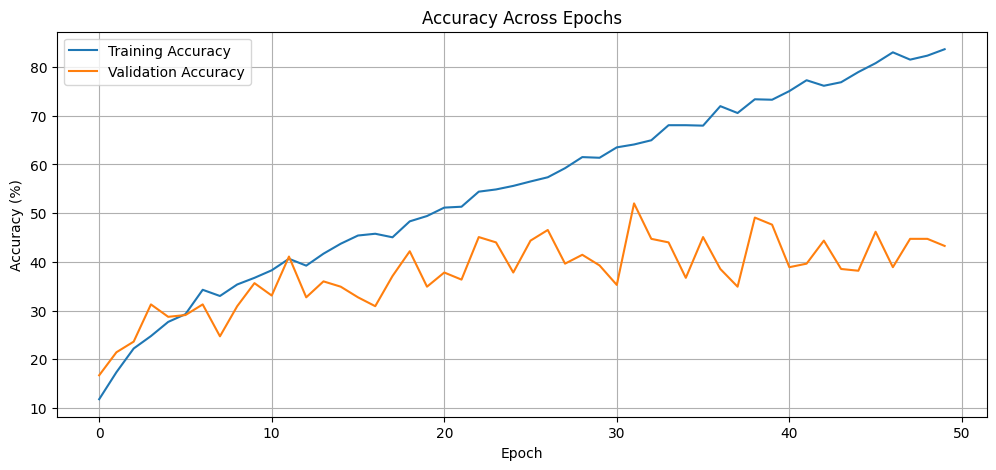

Test Accuracy: 37.45%

Classification Report:

               precision    recall  f1-score   support

    apple_pie       0.31      0.52      0.39        25
   cheesecake       0.79      0.44      0.56        25
chicken_curry       0.33      0.08      0.13        25
 french_fries       0.28      0.76      0.41        25
   fried_rice       0.71      0.40      0.51        25
    hamburger       0.39      0.28      0.33        25
      hot_dog       0.27      0.32      0.29        25
    ice_cream       0.36      0.56      0.44        25
     omelette       0.30      0.12      0.17        25
        pizza       0.45      0.60      0.52        25
        sushi       0.50      0.04      0.07        25

     accuracy                           0.37       275
    macro avg       0.43      0.37      0.35       275
 weighted avg       0.43      0.37      0.35       275



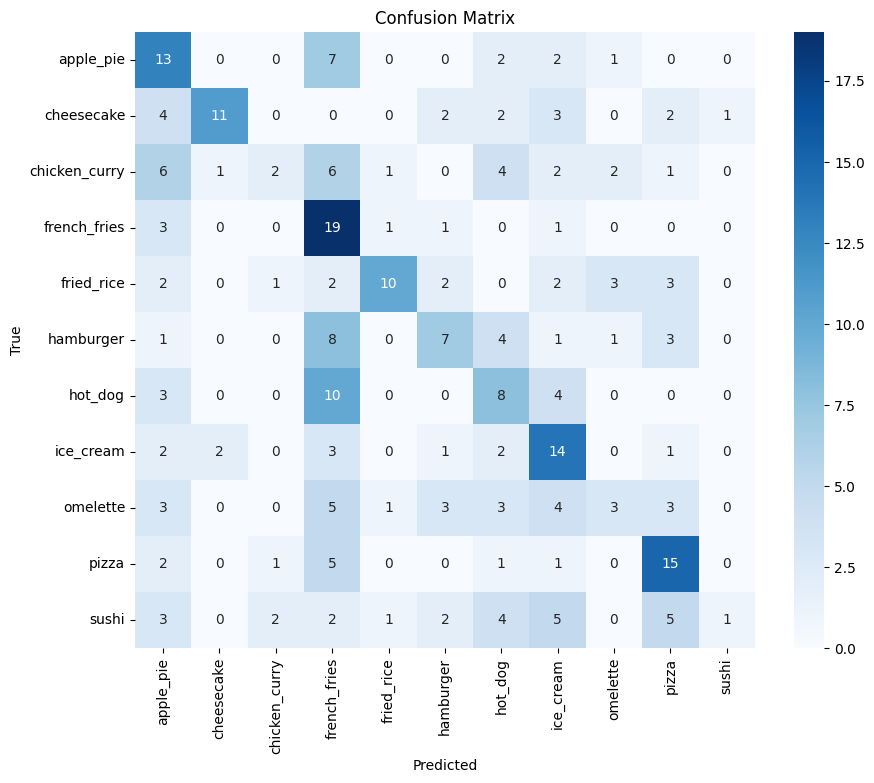

In [64]:
evaluate_and_plot(modelrd2, train_lossesrd2, val_lossesrd2, train_accuraciesrd2, val_accuraciesrd2, test_loader, test_dataset, devicerd2)



### PART 2 - Transfer Learning with CNNs


 Training CASE A: Only FC Layer


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Loss: 83.8880 - Val Accuracy: 0.1745
Epoch 2/50 - Loss: 83.6902 - Val Accuracy: 0.2800
Epoch 3/50 - Loss: 83.4664 - Val Accuracy: 0.3491
Epoch 4/50 - Loss: 83.2570 - Val Accuracy: 0.5236
Epoch 5/50 - Loss: 83.0475 - Val Accuracy: 0.5855
Epoch 6/50 - Loss: 82.8409 - Val Accuracy: 0.6109
Epoch 7/50 - Loss: 82.6214 - Val Accuracy: 0.6400
Epoch 8/50 - Loss: 82.4265 - Val Accuracy: 0.6909
Epoch 9/50 - Loss: 82.2062 - Val Accuracy: 0.7200
Epoch 10/50 - Loss: 81.9956 - Val Accuracy: 0.7345
Epoch 11/50 - Loss: 81.7749 - Val Accuracy: 0.7382
Epoch 12/50 - Loss: 81.5885 - Val Accuracy: 0.7418
Epoch 13/50 - Loss: 81.3777 - Val Accuracy: 0.7636
Epoch 14/50 - Loss: 81.1892 - Val Accuracy: 0.7673
Epoch 15/50 - Loss: 80.9680 - Val Accuracy: 0.7600
Epoch 16/50 - Loss: 80.7250 - Val Accuracy: 0.7636
Epoch 17/50 - Loss: 80.5415 - Val Accuracy: 0.7709
Epoch 18/50 - Loss: 80.3925 - Val Accuracy: 0.7527
Epoch 19/50 - Loss: 80.1881 - Val Accuracy: 0.7564
Epoch 20/50 - Loss: 79.9638 - Val Accura

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50 - Loss: 83.8411 - Val Accuracy: 0.2036
Epoch 2/50 - Loss: 83.5910 - Val Accuracy: 0.3564
Epoch 3/50 - Loss: 83.3097 - Val Accuracy: 0.4400
Epoch 4/50 - Loss: 82.9700 - Val Accuracy: 0.5964
Epoch 5/50 - Loss: 82.5472 - Val Accuracy: 0.6364
Epoch 6/50 - Loss: 81.9557 - Val Accuracy: 0.7345
Epoch 7/50 - Loss: 81.0956 - Val Accuracy: 0.7455
Epoch 8/50 - Loss: 79.7350 - Val Accuracy: 0.7055
Epoch 9/50 - Loss: 77.3542 - Val Accuracy: 0.6945
Epoch 10/50 - Loss: 73.9753 - Val Accuracy: 0.6945
Epoch 11/50 - Loss: 70.1907 - Val Accuracy: 0.7164
Epoch 12/50 - Loss: 65.2138 - Val Accuracy: 0.7309
Epoch 13/50 - Loss: 59.6686 - Val Accuracy: 0.7564
Epoch 14/50 - Loss: 54.3372 - Val Accuracy: 0.7564
Epoch 15/50 - Loss: 48.3920 - Val Accuracy: 0.8109
Epoch 16/50 - Loss: 42.0674 - Val Accuracy: 0.8255
Epoch 17/50 - Loss: 37.2061 - Val Accuracy: 0.8436
Epoch 18/50 - Loss: 32.7506 - Val Accuracy: 0.8509
Epoch 19/50 - Loss: 28.1793 - Val Accuracy: 0.8727
Epoch 20/50 - Loss: 25.0205 - Val Accura

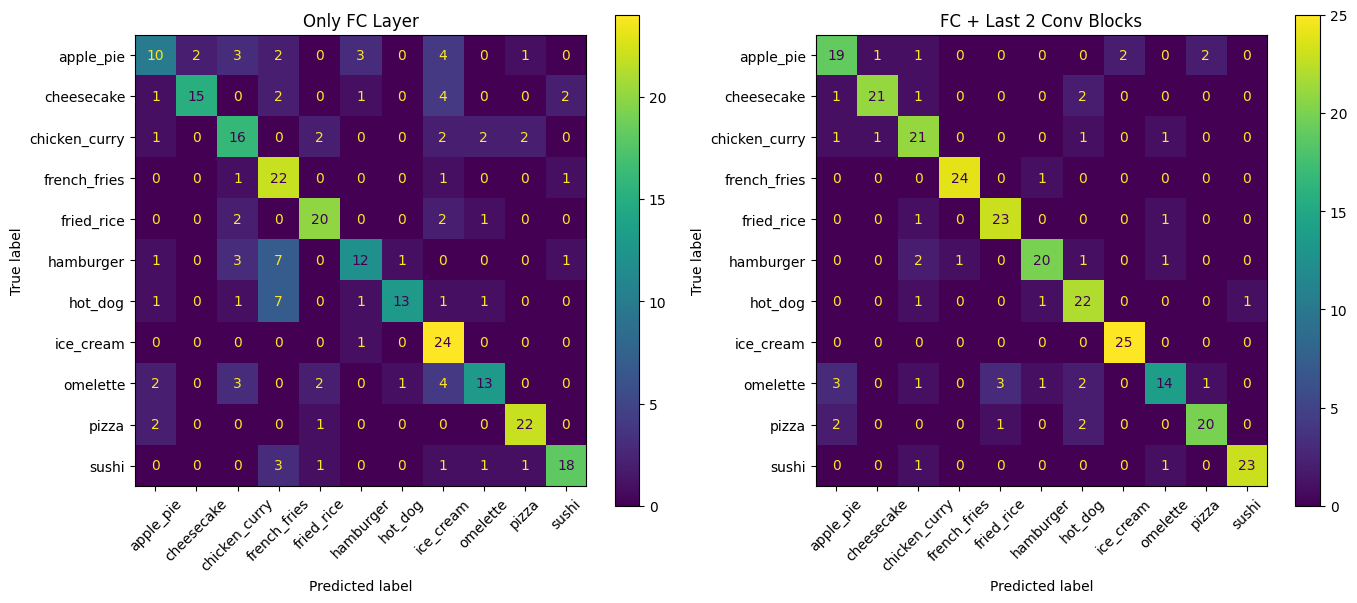

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import copy

num_classes = 11
num_epochs = 50
learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


def train_model(model, train_loader, val_loader, trainable_params):
    model = model.to(device)
    optimizer = optim.SGD(trainable_params, lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Val Accuracy: {val_acc:.4f}")

    return model



def prepare_model(train_last_blocks=False):
    model = models.shufflenet_v2_x1_0(pretrained=True)

    # Bütün katmanları dondur
    for param in model.parameters():
        param.requires_grad = False

    # FC katmanını değiştir
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # Eğer son iki konv blok da eğitilecekse
    if train_last_blocks:
        for name, param in model.named_parameters():
            if "stage3" in name or "stage4" in name or "conv5" in name:
                param.requires_grad = True

    # Sadece eğitilecek parametreleri filtrele
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    return model, trainable_params



print("\n Training CASE A: Only FC Layer")
model_fc_only, trainable_params_A = prepare_model(train_last_blocks=False)
model_fc_only = train_model(model_fc_only, train_loader, val_loader, trainable_params_A)

test_acc_A = evaluate(model_fc_only, test_loader)
print(f"\n Test Accuracy (Only FC): {test_acc_A:.4f}")

# Confusion Matrix
model_fc_only.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_fc_only(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm_A = confusion_matrix(all_labels, all_preds)



print("\n Training CASE B: FC + Last 2 Conv Blocks")
model_fc_and_blocks, trainable_params_B = prepare_model(train_last_blocks=True)
model_fc_and_blocks = train_model(model_fc_and_blocks, train_loader, val_loader, trainable_params_B)

test_acc_B = evaluate(model_fc_and_blocks, test_loader)
print(f"\n Test Accuracy (FC + Last 2 Blocks): {test_acc_B:.4f}")

# Confusion Matrix
model_fc_and_blocks.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model_fc_and_blocks(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm_B = confusion_matrix(all_labels, all_preds)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
disp_A = ConfusionMatrixDisplay(confusion_matrix=cm_A, display_labels=train_dataset.classes)
disp_B = ConfusionMatrixDisplay(confusion_matrix=cm_B, display_labels=train_dataset.classes)

disp_A.plot(ax=axes[0], xticks_rotation=45)
axes[0].set_title("Only FC Layer")

disp_B.plot(ax=axes[1], xticks_rotation=45)
axes[1].set_title("FC + Last 2 Conv Blocks")

plt.tight_layout()
plt.show()
